In [1]:
from preprocess import *

data_path = "data/epinions.txt"

preprocess(data_path, rating_minimum=20)

Processed 10000 lines
Processed 20000 lines
Processed 30000 lines
Processed 40000 lines
Processed 50000 lines
Processed 60000 lines
Processed 70000 lines
Processed 80000 lines
Processed 90000 lines
Processed 100000 lines
Processed 110000 lines
Processed 120000 lines
Processed 130000 lines
Processed 140000 lines
Processed 150000 lines
Processed 160000 lines
Processed 170000 lines
Processed 180000 lines
Processed 190000 lines
Number of users: 335
Number of items: 8999
Number of interactions: 10348
Sparsity: 0.9965674461341476


/Users/raghu/Documents/CMU/s24/10708-final-project/preprocess.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_data = pd.concat([train_data, user_data[:split_index]])
/Users/raghu/Documents/CMU/s24/10708-final-project/preprocess.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_data = pd.concat([test_data, user_data[split_index:]])
/Users/raghu/Documents/CMU/s24/10708-final-project/preprocess.py:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA ent

Train data: 8142
Validation data: 1010
Test data: 1196


In [8]:
from epinions_dataset import EpinionsDataset
import pandas as pd
import pickle
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Get user to items dictionary from pickle file
with open('data/user_to_item.pkl', 'rb') as f:
    user_to_items = pickle.load(f)

# Get items set from pickle file
with open('data/items.pkl', 'rb') as f:
    items_set = pickle.load(f)

# Create dataset
trainset = EpinionsDataset(train, user_to_items, items_set)
print(len(trainset))
print(trainset[0][0].shape)
print(trainset[0][1].shape)

# Create test dataset
testset = EpinionsDataset(test, user_to_items, items_set)

94530
torch.Size([1178])
torch.Size([15094])


In [29]:
from ncf import NCF
from torch.utils.data import DataLoader

# Create dataloader
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=1, shuffle=False)

# Create NCF model
user_input_dim = len(user_to_items)
item_input_dim = len(items_set)
hidden_layers = [64, 32]
embedding_dim = 1024
model = NCF(user_input_dim, item_input_dim, embedding_dim, hidden_layers[0], hidden_layers[1]).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [34]:
from tqdm import tqdm
import random

def test(model, test_loader, topk=10):
    model.eval()
    items_list = list(items_set)
    with torch.no_grad():
        num_hits = 0
        for user, item, label in tqdm(test_loader, desc="Testing", total=len(test_loader)):
            user, item, label = user.to(device), item.to(device), label.to(device)

            # For each user, we sample 100 items and get the model output
            negative_samples = set()
            while len(negative_samples) < 100:
                # Get random item from items list
                user_plaintext = trainset.one_hot_to_user(user[0])
                random_item = random.choice(items_list)
                if random_item not in user_to_items[user_plaintext]:
                    negative_samples.add(random_item)

            # Create batch of negative samples
            for i, sample in enumerate(negative_samples):
                one_hot = trainset.item_to_one_hot(sample)
                # Reshape one_hot to be compatible with item
                one_hot = one_hot.unsqueeze(0)
                user_temp = user[0].unsqueeze(0)
                user = torch.cat((user, user_temp), 0)
                item = torch.cat((item, one_hot), 0)

            output = model(user, item)

            # Flatten output to be 1D
            output = output.reshape(-1)

            # Shuffle output while maintaining original indices
            indices = torch.randperm(len(output))
            output = output[indices]
            index0 = torch.where(indices == 0)[0][0]

            # Check if the output of the positive sample is in the top k
            #vals, indices = torch.topk(output, topk)
            _, indices = torch.topk(output, topk)
            if index0 in indices:
                num_hits += 1

    return num_hits / len(test_loader)

def train(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    model.train()
    losses = []
    hit_rates = []
    for epoch in range(epochs):
        iterator = iter(train_loader)
        
        total_loss = []
        training_accuracy = 0
        for i, (user, item, label) in tqdm(enumerate(iterator), desc=f"Epoch {epoch+1}", total=len(train_loader)):
            user, item, label = user.to(device), item.to(device), label.to(device)
            print("user shape", user.shape)
            print("item shape", item.shape)
            print("label shape", label.shape)
            optimizer.zero_grad()
            output = model(user, item)
            label = label.unsqueeze(1).float()

            # get the training accuracy
            logit = torch.sigmoid(output)
            predicted = torch.round(logit)
            training_accuracy += (predicted == label).sum().item()

            loss = criterion(output, label)
            total_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        hit_rate = test(model, test_loader)
        hit_rates.append(hit_rate)

        training_accuracy /= len(trainset)
        
        print(f"Epoch {epoch+1} loss: {sum(total_loss)/len(total_loss)} | hit rate: {hit_rate} | training accuracy: {training_accuracy}")
        losses.append(sum(total_loss)/len(total_loss))

    return losses, hit_rates

In [35]:
# Run the training
losses, hit_rates = train(model, train_loader, test_loader, optimizer, criterion, epochs=10)

Epoch 1:   0%|          | 3/1478 [00:00<02:02, 12.09it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   0%|          | 5/1478 [00:00<01:55, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   1%|          | 9/1478 [00:00<01:50, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   1%|          | 11/1478 [00:00<01:49, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   1%|          | 15/1478 [00:01<01:47, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   1%|          | 17/1478 [00:01<01:47, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   1%|▏         | 21/1478 [00:01<01:49, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   2%|▏         | 23/1478 [00:01<01:48, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   2%|▏         | 27/1478 [00:02<01:49, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   2%|▏         | 29/1478 [00:02<01:48, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   2%|▏         | 33/1478 [00:02<01:46, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   2%|▏         | 35/1478 [00:02<01:46, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   3%|▎         | 39/1478 [00:02<01:45, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   3%|▎         | 41/1478 [00:03<01:44, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   3%|▎         | 45/1478 [00:03<01:44, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   3%|▎         | 47/1478 [00:03<01:44, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   3%|▎         | 51/1478 [00:03<01:44, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   4%|▎         | 53/1478 [00:03<01:45, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   4%|▍         | 57/1478 [00:04<01:44, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   4%|▍         | 59/1478 [00:04<01:44, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   4%|▍         | 63/1478 [00:04<01:44, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   4%|▍         | 65/1478 [00:04<01:44, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   5%|▍         | 69/1478 [00:05<01:43, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   5%|▍         | 71/1478 [00:05<01:43, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   5%|▌         | 75/1478 [00:05<01:45, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   5%|▌         | 77/1478 [00:05<01:50, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   5%|▌         | 81/1478 [00:06<01:48, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   6%|▌         | 83/1478 [00:06<01:47, 13.00it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   6%|▌         | 87/1478 [00:06<01:45, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   6%|▌         | 89/1478 [00:06<01:44, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   6%|▋         | 93/1478 [00:06<01:41, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   6%|▋         | 95/1478 [00:07<01:41, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   7%|▋         | 99/1478 [00:07<01:40, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   7%|▋         | 101/1478 [00:07<01:40, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   7%|▋         | 105/1478 [00:07<01:39, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   7%|▋         | 107/1478 [00:07<01:39, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   8%|▊         | 111/1478 [00:08<01:39, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   8%|▊         | 113/1478 [00:08<01:39, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   8%|▊         | 117/1478 [00:08<01:38, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   8%|▊         | 119/1478 [00:08<01:38, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   8%|▊         | 123/1478 [00:09<01:38, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   8%|▊         | 125/1478 [00:09<01:37, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   9%|▊         | 129/1478 [00:09<01:37, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   9%|▉         | 131/1478 [00:09<01:37, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   9%|▉         | 135/1478 [00:10<01:40, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:   9%|▉         | 137/1478 [00:10<01:41, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  10%|▉         | 141/1478 [00:10<01:39, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  10%|▉         | 143/1478 [00:10<01:38, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  10%|▉         | 147/1478 [00:10<01:37, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  10%|█         | 149/1478 [00:11<01:37, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  10%|█         | 153/1478 [00:11<01:36, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  10%|█         | 155/1478 [00:11<01:36, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  11%|█         | 159/1478 [00:11<01:38, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  11%|█         | 161/1478 [00:11<01:38, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  11%|█         | 165/1478 [00:12<01:36, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  11%|█▏        | 167/1478 [00:12<01:36, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  12%|█▏        | 171/1478 [00:12<01:35, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  12%|█▏        | 173/1478 [00:12<01:35, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  12%|█▏        | 177/1478 [00:13<01:34, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  12%|█▏        | 179/1478 [00:13<01:34, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  12%|█▏        | 183/1478 [00:13<01:34, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  13%|█▎        | 185/1478 [00:13<01:34, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  13%|█▎        | 189/1478 [00:13<01:34, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  13%|█▎        | 191/1478 [00:14<01:34, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  13%|█▎        | 195/1478 [00:14<01:34, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  13%|█▎        | 197/1478 [00:14<01:34, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  14%|█▎        | 201/1478 [00:14<01:35, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  14%|█▎        | 203/1478 [00:15<01:34, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  14%|█▍        | 207/1478 [00:15<01:33, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  14%|█▍        | 209/1478 [00:15<01:34, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  14%|█▍        | 213/1478 [00:15<01:33, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  15%|█▍        | 215/1478 [00:15<01:33, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  15%|█▍        | 219/1478 [00:16<01:32, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  15%|█▍        | 221/1478 [00:16<01:32, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  15%|█▌        | 225/1478 [00:16<01:31, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  15%|█▌        | 227/1478 [00:16<01:31, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  16%|█▌        | 231/1478 [00:17<01:30, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  16%|█▌        | 233/1478 [00:17<01:30, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  16%|█▌        | 237/1478 [00:17<01:30, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  16%|█▌        | 239/1478 [00:17<01:29, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  16%|█▋        | 243/1478 [00:17<01:29, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  17%|█▋        | 245/1478 [00:18<01:29, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  17%|█▋        | 249/1478 [00:18<01:29, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  17%|█▋        | 251/1478 [00:18<01:29, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  17%|█▋        | 255/1478 [00:18<01:29, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  17%|█▋        | 257/1478 [00:18<01:28, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  18%|█▊        | 261/1478 [00:19<01:30, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  18%|█▊        | 263/1478 [00:19<01:29, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  18%|█▊        | 267/1478 [00:19<01:28, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  18%|█▊        | 269/1478 [00:19<01:28, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  18%|█▊        | 273/1478 [00:20<01:27, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  19%|█▊        | 275/1478 [00:20<01:27, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  19%|█▉        | 279/1478 [00:20<01:28, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  19%|█▉        | 281/1478 [00:20<01:30, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  19%|█▉        | 285/1478 [00:21<01:31, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  19%|█▉        | 287/1478 [00:21<01:30, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  20%|█▉        | 291/1478 [00:21<01:32, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  20%|█▉        | 293/1478 [00:21<01:32, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  20%|██        | 297/1478 [00:21<01:32, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  20%|██        | 299/1478 [00:22<01:31, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  21%|██        | 303/1478 [00:22<01:32, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  21%|██        | 305/1478 [00:22<01:33, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  21%|██        | 309/1478 [00:22<01:31, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  21%|██        | 311/1478 [00:23<01:30, 12.94it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  21%|██▏       | 315/1478 [00:23<01:27, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  21%|██▏       | 317/1478 [00:23<01:26, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  22%|██▏       | 321/1478 [00:23<01:25, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  22%|██▏       | 323/1478 [00:23<01:24, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  22%|██▏       | 327/1478 [00:24<01:24, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  22%|██▏       | 329/1478 [00:24<01:23, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  23%|██▎       | 333/1478 [00:24<01:23, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  23%|██▎       | 335/1478 [00:24<01:23, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  23%|██▎       | 339/1478 [00:25<01:22, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  23%|██▎       | 341/1478 [00:25<01:22, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  23%|██▎       | 345/1478 [00:25<01:22, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  23%|██▎       | 347/1478 [00:25<01:21, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  24%|██▎       | 351/1478 [00:26<01:21, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  24%|██▍       | 353/1478 [00:26<01:21, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  24%|██▍       | 357/1478 [00:26<01:21, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  24%|██▍       | 359/1478 [00:26<01:21, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  25%|██▍       | 363/1478 [00:26<01:20, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  25%|██▍       | 365/1478 [00:27<01:20, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  25%|██▍       | 369/1478 [00:27<01:20, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  25%|██▌       | 371/1478 [00:27<01:20, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  25%|██▌       | 375/1478 [00:27<01:20, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  26%|██▌       | 377/1478 [00:27<01:19, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  26%|██▌       | 381/1478 [00:28<01:19, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  26%|██▌       | 383/1478 [00:28<01:19, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  26%|██▌       | 387/1478 [00:28<01:19, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  26%|██▋       | 389/1478 [00:28<01:19, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  27%|██▋       | 393/1478 [00:29<01:18, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  27%|██▋       | 395/1478 [00:29<01:18, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  27%|██▋       | 399/1478 [00:29<01:18, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  27%|██▋       | 401/1478 [00:29<01:18, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  27%|██▋       | 405/1478 [00:29<01:18, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  28%|██▊       | 407/1478 [00:30<01:17, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  28%|██▊       | 411/1478 [00:30<01:17, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  28%|██▊       | 413/1478 [00:30<01:17, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  28%|██▊       | 417/1478 [00:30<01:17, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  28%|██▊       | 419/1478 [00:30<01:16, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  29%|██▊       | 423/1478 [00:31<01:16, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  29%|██▉       | 425/1478 [00:31<01:16, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  29%|██▉       | 429/1478 [00:31<01:17, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  29%|██▉       | 431/1478 [00:31<01:16, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  29%|██▉       | 435/1478 [00:32<01:16, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  30%|██▉       | 437/1478 [00:32<01:15, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  30%|██▉       | 441/1478 [00:32<01:15, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  30%|██▉       | 443/1478 [00:32<01:15, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  30%|███       | 447/1478 [00:32<01:14, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  30%|███       | 449/1478 [00:33<01:14, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  31%|███       | 453/1478 [00:33<01:14, 13.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  31%|███       | 455/1478 [00:33<01:13, 13.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  31%|███       | 459/1478 [00:33<01:13, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  31%|███       | 461/1478 [00:34<01:13, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  31%|███▏      | 465/1478 [00:34<01:13, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  32%|███▏      | 467/1478 [00:34<01:13, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  32%|███▏      | 471/1478 [00:34<01:12, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  32%|███▏      | 473/1478 [00:34<01:12, 13.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  32%|███▏      | 477/1478 [00:35<01:12, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  32%|███▏      | 479/1478 [00:35<01:12, 13.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  33%|███▎      | 483/1478 [00:35<01:12, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  33%|███▎      | 485/1478 [00:35<01:11, 13.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  33%|███▎      | 489/1478 [00:36<01:11, 13.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  33%|███▎      | 491/1478 [00:36<01:11, 13.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  33%|███▎      | 495/1478 [00:36<01:11, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  34%|███▎      | 497/1478 [00:36<01:11, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  34%|███▍      | 501/1478 [00:36<01:10, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  34%|███▍      | 503/1478 [00:37<01:11, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  34%|███▍      | 507/1478 [00:37<01:11, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  34%|███▍      | 509/1478 [00:37<01:10, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  35%|███▍      | 513/1478 [00:37<01:10, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  35%|███▍      | 515/1478 [00:37<01:10, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  35%|███▌      | 519/1478 [00:38<01:09, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  35%|███▌      | 521/1478 [00:38<01:09, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  36%|███▌      | 525/1478 [00:38<01:08, 13.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  36%|███▌      | 527/1478 [00:38<01:08, 13.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  36%|███▌      | 531/1478 [00:39<01:08, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  36%|███▌      | 533/1478 [00:39<01:08, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  36%|███▋      | 537/1478 [00:39<01:08, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  36%|███▋      | 539/1478 [00:39<01:07, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  37%|███▋      | 543/1478 [00:39<01:07, 13.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  37%|███▋      | 545/1478 [00:40<01:07, 13.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  37%|███▋      | 549/1478 [00:40<01:07, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  37%|███▋      | 551/1478 [00:40<01:07, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  38%|███▊      | 555/1478 [00:40<01:06, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  38%|███▊      | 557/1478 [00:40<01:06, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  38%|███▊      | 561/1478 [00:41<01:06, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  38%|███▊      | 563/1478 [00:41<01:06, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  38%|███▊      | 567/1478 [00:41<01:06, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  38%|███▊      | 569/1478 [00:41<01:05, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  39%|███▉      | 573/1478 [00:42<01:05, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  39%|███▉      | 575/1478 [00:42<01:05, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  39%|███▉      | 579/1478 [00:42<01:05, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  39%|███▉      | 581/1478 [00:42<01:04, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  40%|███▉      | 585/1478 [00:43<01:04, 13.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  40%|███▉      | 587/1478 [00:43<01:04, 13.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  40%|███▉      | 591/1478 [00:43<01:04, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  40%|████      | 593/1478 [00:43<01:04, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  40%|████      | 597/1478 [00:43<01:04, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  41%|████      | 599/1478 [00:44<01:03, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  41%|████      | 603/1478 [00:44<01:03, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  41%|████      | 605/1478 [00:44<01:03, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  41%|████      | 609/1478 [00:44<01:03, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  41%|████▏     | 611/1478 [00:44<01:02, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  42%|████▏     | 615/1478 [00:45<01:02, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  42%|████▏     | 617/1478 [00:45<01:02, 13.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  42%|████▏     | 621/1478 [00:45<01:01, 13.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  42%|████▏     | 623/1478 [00:45<01:01, 13.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  42%|████▏     | 627/1478 [00:46<01:01, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  43%|████▎     | 629/1478 [00:46<01:01, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  43%|████▎     | 633/1478 [00:46<01:01, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  43%|████▎     | 635/1478 [00:46<01:01, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  43%|████▎     | 639/1478 [00:46<01:00, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  43%|████▎     | 641/1478 [00:47<01:01, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  44%|████▎     | 645/1478 [00:47<01:00, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  44%|████▍     | 647/1478 [00:47<01:00, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  44%|████▍     | 651/1478 [00:47<01:00, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  44%|████▍     | 653/1478 [00:47<01:00, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  44%|████▍     | 657/1478 [00:48<01:00, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  45%|████▍     | 659/1478 [00:48<00:59, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  45%|████▍     | 663/1478 [00:48<00:59, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  45%|████▍     | 665/1478 [00:48<00:59, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  45%|████▌     | 669/1478 [00:49<00:58, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  45%|████▌     | 671/1478 [00:49<00:58, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  46%|████▌     | 675/1478 [00:49<00:58, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  46%|████▌     | 677/1478 [00:49<00:57, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  46%|████▌     | 681/1478 [00:49<00:57, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  46%|████▌     | 683/1478 [00:50<00:57, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  46%|████▋     | 687/1478 [00:50<00:57, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  47%|████▋     | 689/1478 [00:50<00:57, 13.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  47%|████▋     | 693/1478 [00:50<00:56, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  47%|████▋     | 695/1478 [00:50<00:56, 13.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  47%|████▋     | 699/1478 [00:51<00:56, 13.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  47%|████▋     | 701/1478 [00:51<00:56, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  48%|████▊     | 705/1478 [00:51<00:56, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  48%|████▊     | 707/1478 [00:51<00:55, 13.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  48%|████▊     | 711/1478 [00:52<00:55, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  48%|████▊     | 713/1478 [00:52<00:55, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  49%|████▊     | 717/1478 [00:52<00:55, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  49%|████▊     | 719/1478 [00:52<00:55, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  49%|████▉     | 723/1478 [00:53<00:54, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  49%|████▉     | 725/1478 [00:53<00:54, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  49%|████▉     | 729/1478 [00:53<00:54, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  49%|████▉     | 731/1478 [00:53<00:54, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  50%|████▉     | 735/1478 [00:53<00:54, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  50%|████▉     | 737/1478 [00:54<00:54, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  50%|█████     | 741/1478 [00:54<00:53, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  50%|█████     | 743/1478 [00:54<00:53, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  51%|█████     | 747/1478 [00:54<00:53, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  51%|█████     | 749/1478 [00:54<00:52, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  51%|█████     | 753/1478 [00:55<00:53, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  51%|█████     | 755/1478 [00:55<00:52, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  51%|█████▏    | 759/1478 [00:55<00:52, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  51%|█████▏    | 761/1478 [00:55<00:52, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  52%|█████▏    | 765/1478 [00:56<00:52, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  52%|█████▏    | 767/1478 [00:56<00:51, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  52%|█████▏    | 771/1478 [00:56<00:51, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  52%|█████▏    | 773/1478 [00:56<00:51, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  53%|█████▎    | 777/1478 [00:56<00:51, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  53%|█████▎    | 779/1478 [00:57<00:51, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  53%|█████▎    | 783/1478 [00:57<00:50, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  53%|█████▎    | 785/1478 [00:57<00:50, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  53%|█████▎    | 789/1478 [00:57<00:50, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  54%|█████▎    | 791/1478 [00:58<00:49, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  54%|█████▍    | 795/1478 [00:58<00:49, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  54%|█████▍    | 797/1478 [00:58<00:49, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  54%|█████▍    | 801/1478 [00:58<00:49, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  54%|█████▍    | 803/1478 [00:58<00:48, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  55%|█████▍    | 807/1478 [00:59<00:48, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  55%|█████▍    | 809/1478 [00:59<00:48, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  55%|█████▌    | 813/1478 [00:59<00:48, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  55%|█████▌    | 815/1478 [00:59<00:48, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  55%|█████▌    | 819/1478 [01:00<00:48, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  56%|█████▌    | 821/1478 [01:00<00:48, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  56%|█████▌    | 825/1478 [01:00<00:47, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  56%|█████▌    | 827/1478 [01:00<00:47, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  56%|█████▌    | 831/1478 [01:00<00:47, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  56%|█████▋    | 833/1478 [01:01<00:46, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  57%|█████▋    | 837/1478 [01:01<00:46, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  57%|█████▋    | 839/1478 [01:01<00:46, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  57%|█████▋    | 843/1478 [01:01<00:46, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  57%|█████▋    | 845/1478 [01:01<00:45, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  57%|█████▋    | 849/1478 [01:02<00:45, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  58%|█████▊    | 851/1478 [01:02<00:45, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  58%|█████▊    | 855/1478 [01:02<00:45, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  58%|█████▊    | 857/1478 [01:02<00:45, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  58%|█████▊    | 861/1478 [01:03<00:44, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  58%|█████▊    | 863/1478 [01:03<00:44, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  59%|█████▊    | 867/1478 [01:03<00:44, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  59%|█████▉    | 869/1478 [01:03<00:44, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  59%|█████▉    | 873/1478 [01:03<00:43, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  59%|█████▉    | 875/1478 [01:04<00:43, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  59%|█████▉    | 879/1478 [01:04<00:43, 13.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  60%|█████▉    | 881/1478 [01:04<00:43, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  60%|█████▉    | 885/1478 [01:04<00:43, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  60%|██████    | 887/1478 [01:04<00:42, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  60%|██████    | 891/1478 [01:05<00:42, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  60%|██████    | 893/1478 [01:05<00:42, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  61%|██████    | 897/1478 [01:05<00:42, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  61%|██████    | 899/1478 [01:05<00:42, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  61%|██████    | 903/1478 [01:06<00:42, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  61%|██████    | 905/1478 [01:06<00:41, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  62%|██████▏   | 909/1478 [01:06<00:41, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  62%|██████▏   | 911/1478 [01:06<00:41, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  62%|██████▏   | 915/1478 [01:07<00:40, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  62%|██████▏   | 917/1478 [01:07<00:40, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  62%|██████▏   | 921/1478 [01:07<00:40, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  62%|██████▏   | 923/1478 [01:07<00:40, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  63%|██████▎   | 927/1478 [01:07<00:39, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  63%|██████▎   | 929/1478 [01:08<00:39, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  63%|██████▎   | 933/1478 [01:08<00:39, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  63%|██████▎   | 935/1478 [01:08<00:39, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  64%|██████▎   | 939/1478 [01:08<00:39, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  64%|██████▎   | 941/1478 [01:08<00:39, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  64%|██████▍   | 945/1478 [01:09<00:39, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  64%|██████▍   | 947/1478 [01:09<00:38, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  64%|██████▍   | 951/1478 [01:09<00:38, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  64%|██████▍   | 953/1478 [01:09<00:38, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  65%|██████▍   | 957/1478 [01:10<00:37, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  65%|██████▍   | 959/1478 [01:10<00:37, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  65%|██████▌   | 963/1478 [01:10<00:37, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  65%|██████▌   | 965/1478 [01:10<00:37, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  66%|██████▌   | 969/1478 [01:10<00:37, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  66%|██████▌   | 971/1478 [01:11<00:37, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  66%|██████▌   | 975/1478 [01:11<00:37, 13.40it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  66%|██████▌   | 977/1478 [01:11<00:37, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  66%|██████▋   | 981/1478 [01:11<00:36, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  67%|██████▋   | 983/1478 [01:12<00:36, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  67%|██████▋   | 987/1478 [01:12<00:36, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  67%|██████▋   | 989/1478 [01:12<00:35, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  67%|██████▋   | 993/1478 [01:12<00:35, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  67%|██████▋   | 995/1478 [01:12<00:35, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  68%|██████▊   | 999/1478 [01:13<00:35, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  68%|██████▊   | 1001/1478 [01:13<00:34, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  68%|██████▊   | 1005/1478 [01:13<00:34, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  68%|██████▊   | 1007/1478 [01:13<00:34, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  68%|██████▊   | 1011/1478 [01:14<00:33, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  69%|██████▊   | 1013/1478 [01:14<00:33, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  69%|██████▉   | 1017/1478 [01:14<00:33, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  69%|██████▉   | 1019/1478 [01:14<00:33, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  69%|██████▉   | 1023/1478 [01:14<00:33, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  69%|██████▉   | 1025/1478 [01:15<00:32, 13.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  70%|██████▉   | 1029/1478 [01:15<00:32, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  70%|██████▉   | 1031/1478 [01:15<00:32, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  70%|███████   | 1035/1478 [01:15<00:32, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  70%|███████   | 1037/1478 [01:15<00:32, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  70%|███████   | 1041/1478 [01:16<00:31, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  71%|███████   | 1043/1478 [01:16<00:31, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  71%|███████   | 1047/1478 [01:16<00:31, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  71%|███████   | 1049/1478 [01:16<00:31, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  71%|███████   | 1053/1478 [01:17<00:30, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  71%|███████▏  | 1055/1478 [01:17<00:30, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  72%|███████▏  | 1059/1478 [01:17<00:30, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  72%|███████▏  | 1061/1478 [01:17<00:30, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  72%|███████▏  | 1065/1478 [01:17<00:30, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  72%|███████▏  | 1067/1478 [01:18<00:29, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  72%|███████▏  | 1071/1478 [01:18<00:29, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  73%|███████▎  | 1073/1478 [01:18<00:29, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  73%|███████▎  | 1077/1478 [01:18<00:29, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  73%|███████▎  | 1079/1478 [01:19<00:28, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  73%|███████▎  | 1083/1478 [01:19<00:28, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  73%|███████▎  | 1085/1478 [01:19<00:28, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  74%|███████▎  | 1089/1478 [01:19<00:28, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  74%|███████▍  | 1091/1478 [01:19<00:28, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  74%|███████▍  | 1095/1478 [01:20<00:27, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  74%|███████▍  | 1097/1478 [01:20<00:27, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  74%|███████▍  | 1101/1478 [01:20<00:27, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  75%|███████▍  | 1103/1478 [01:20<00:27, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  75%|███████▍  | 1107/1478 [01:21<00:26, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  75%|███████▌  | 1109/1478 [01:21<00:26, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  75%|███████▌  | 1113/1478 [01:21<00:26, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  75%|███████▌  | 1115/1478 [01:21<00:26, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  76%|███████▌  | 1119/1478 [01:21<00:26, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  76%|███████▌  | 1121/1478 [01:22<00:25, 13.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  76%|███████▌  | 1125/1478 [01:22<00:25, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  76%|███████▋  | 1127/1478 [01:22<00:25, 13.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  77%|███████▋  | 1131/1478 [01:22<00:25, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  77%|███████▋  | 1133/1478 [01:22<00:25, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  77%|███████▋  | 1137/1478 [01:23<00:25, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  77%|███████▋  | 1139/1478 [01:23<00:24, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  77%|███████▋  | 1143/1478 [01:23<00:24, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  77%|███████▋  | 1145/1478 [01:23<00:24, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  78%|███████▊  | 1149/1478 [01:24<00:23, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  78%|███████▊  | 1151/1478 [01:24<00:23, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  78%|███████▊  | 1155/1478 [01:24<00:23, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  78%|███████▊  | 1157/1478 [01:24<00:23, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  79%|███████▊  | 1161/1478 [01:24<00:23, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  79%|███████▊  | 1163/1478 [01:25<00:22, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  79%|███████▉  | 1167/1478 [01:25<00:22, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  79%|███████▉  | 1169/1478 [01:25<00:22, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  79%|███████▉  | 1173/1478 [01:25<00:22, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  79%|███████▉  | 1175/1478 [01:26<00:22, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  80%|███████▉  | 1179/1478 [01:26<00:21, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  80%|███████▉  | 1181/1478 [01:26<00:21, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  80%|████████  | 1185/1478 [01:26<00:21, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  80%|████████  | 1187/1478 [01:26<00:21, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  81%|████████  | 1191/1478 [01:27<00:20, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  81%|████████  | 1193/1478 [01:27<00:20, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  81%|████████  | 1197/1478 [01:27<00:20, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  81%|████████  | 1199/1478 [01:27<00:20, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  81%|████████▏ | 1203/1478 [01:28<00:20, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  82%|████████▏ | 1205/1478 [01:28<00:20, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  82%|████████▏ | 1209/1478 [01:28<00:19, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  82%|████████▏ | 1211/1478 [01:28<00:19, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  82%|████████▏ | 1215/1478 [01:28<00:19, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  82%|████████▏ | 1217/1478 [01:29<00:19, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  83%|████████▎ | 1221/1478 [01:29<00:18, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  83%|████████▎ | 1223/1478 [01:29<00:18, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  83%|████████▎ | 1227/1478 [01:29<00:18, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  83%|████████▎ | 1229/1478 [01:29<00:18, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  83%|████████▎ | 1233/1478 [01:30<00:17, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  84%|████████▎ | 1235/1478 [01:30<00:17, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  84%|████████▍ | 1239/1478 [01:30<00:17, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  84%|████████▍ | 1241/1478 [01:30<00:17, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  84%|████████▍ | 1245/1478 [01:31<00:17, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  84%|████████▍ | 1247/1478 [01:31<00:16, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  85%|████████▍ | 1251/1478 [01:31<00:16, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  85%|████████▍ | 1253/1478 [01:31<00:16, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  85%|████████▌ | 1257/1478 [01:32<00:16, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  85%|████████▌ | 1259/1478 [01:32<00:15, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  85%|████████▌ | 1263/1478 [01:32<00:15, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  86%|████████▌ | 1265/1478 [01:32<00:15, 13.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  86%|████████▌ | 1269/1478 [01:32<00:15, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  86%|████████▌ | 1271/1478 [01:33<00:15, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  86%|████████▋ | 1275/1478 [01:33<00:14, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  86%|████████▋ | 1277/1478 [01:33<00:14, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  87%|████████▋ | 1281/1478 [01:33<00:14, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  87%|████████▋ | 1283/1478 [01:33<00:14, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  87%|████████▋ | 1287/1478 [01:34<00:13, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  87%|████████▋ | 1289/1478 [01:34<00:13, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  87%|████████▋ | 1293/1478 [01:34<00:13, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  88%|████████▊ | 1295/1478 [01:34<00:13, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  88%|████████▊ | 1299/1478 [01:35<00:13, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  88%|████████▊ | 1301/1478 [01:35<00:13, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  88%|████████▊ | 1305/1478 [01:35<00:12, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  88%|████████▊ | 1307/1478 [01:35<00:12, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  89%|████████▊ | 1311/1478 [01:35<00:12, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  89%|████████▉ | 1313/1478 [01:36<00:12, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  89%|████████▉ | 1317/1478 [01:36<00:11, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  89%|████████▉ | 1319/1478 [01:36<00:11, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  90%|████████▉ | 1323/1478 [01:36<00:11, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  90%|████████▉ | 1325/1478 [01:36<00:11, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  90%|████████▉ | 1329/1478 [01:37<00:10, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  90%|█████████ | 1331/1478 [01:37<00:10, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  90%|█████████ | 1335/1478 [01:37<00:10, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  90%|█████████ | 1337/1478 [01:37<00:10, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  91%|█████████ | 1341/1478 [01:38<00:10, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  91%|█████████ | 1343/1478 [01:38<00:09, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  91%|█████████ | 1347/1478 [01:38<00:09, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  91%|█████████▏| 1349/1478 [01:38<00:09, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  92%|█████████▏| 1353/1478 [01:39<00:09, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  92%|█████████▏| 1355/1478 [01:39<00:08, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  92%|█████████▏| 1359/1478 [01:39<00:08, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  92%|█████████▏| 1361/1478 [01:39<00:08, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  92%|█████████▏| 1365/1478 [01:39<00:08, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  92%|█████████▏| 1367/1478 [01:40<00:08, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  93%|█████████▎| 1371/1478 [01:40<00:07, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  93%|█████████▎| 1373/1478 [01:40<00:07, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  93%|█████████▎| 1377/1478 [01:40<00:07, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  93%|█████████▎| 1379/1478 [01:40<00:07, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  94%|█████████▎| 1383/1478 [01:41<00:06, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  94%|█████████▎| 1385/1478 [01:41<00:06, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  94%|█████████▍| 1389/1478 [01:41<00:06, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  94%|█████████▍| 1391/1478 [01:41<00:06, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  94%|█████████▍| 1395/1478 [01:42<00:06, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  95%|█████████▍| 1397/1478 [01:42<00:05, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  95%|█████████▍| 1401/1478 [01:42<00:05, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  95%|█████████▍| 1403/1478 [01:42<00:05, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  95%|█████████▌| 1407/1478 [01:42<00:05, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  95%|█████████▌| 1409/1478 [01:43<00:05, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  96%|█████████▌| 1413/1478 [01:43<00:04, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  96%|█████████▌| 1415/1478 [01:43<00:04, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  96%|█████████▌| 1419/1478 [01:43<00:04, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  96%|█████████▌| 1421/1478 [01:44<00:04, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  96%|█████████▋| 1425/1478 [01:44<00:03, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  97%|█████████▋| 1427/1478 [01:44<00:03, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  97%|█████████▋| 1431/1478 [01:44<00:03, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  97%|█████████▋| 1433/1478 [01:44<00:03, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  97%|█████████▋| 1437/1478 [01:45<00:02, 13.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  97%|█████████▋| 1439/1478 [01:45<00:02, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  98%|█████████▊| 1443/1478 [01:45<00:02, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  98%|█████████▊| 1445/1478 [01:45<00:02, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  98%|█████████▊| 1449/1478 [01:46<00:02, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  98%|█████████▊| 1451/1478 [01:46<00:01, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  98%|█████████▊| 1455/1478 [01:46<00:01, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  99%|█████████▊| 1457/1478 [01:46<00:01, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  99%|█████████▉| 1461/1478 [01:46<00:01, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  99%|█████████▉| 1463/1478 [01:47<00:01, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  99%|█████████▉| 1467/1478 [01:47<00:00, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1:  99%|█████████▉| 1469/1478 [01:47<00:00, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1: 100%|█████████▉| 1473/1478 [01:47<00:00, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1: 100%|█████████▉| 1475/1478 [01:47<00:00, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 1: 100%|██████████| 1478/1478 [01:48<00:00, 13.67it/s]


user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([2, 1178])
item shape torch.Size([2, 15094])
label shape torch.Size([2])


Testing: 100%|██████████| 1178/1178 [01:49<00:00, 10.76it/s]


Epoch 1 loss: 0.5009586793523034 | hit rate: 0.0899830220713073 | training accuracy: 0.2000846292182376


Epoch 2:   0%|          | 2/1478 [00:00<01:47, 13.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   0%|          | 6/1478 [00:00<01:47, 13.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   1%|          | 8/1478 [00:00<01:46, 13.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   1%|          | 12/1478 [00:00<01:47, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   1%|          | 14/1478 [00:01<01:47, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   1%|          | 18/1478 [00:01<01:47, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   1%|▏         | 20/1478 [00:01<01:46, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   2%|▏         | 24/1478 [00:01<01:46, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   2%|▏         | 26/1478 [00:01<01:45, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   2%|▏         | 30/1478 [00:02<01:45, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   2%|▏         | 32/1478 [00:02<01:45, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   2%|▏         | 36/1478 [00:02<01:45, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   3%|▎         | 38/1478 [00:02<01:44, 13.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   3%|▎         | 42/1478 [00:03<01:44, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   3%|▎         | 44/1478 [00:03<01:45, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   3%|▎         | 48/1478 [00:03<01:44, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   3%|▎         | 50/1478 [00:03<01:44, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   4%|▎         | 54/1478 [00:03<01:46, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   4%|▍         | 56/1478 [00:04<01:45, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   4%|▍         | 60/1478 [00:04<01:44, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   4%|▍         | 62/1478 [00:04<01:43, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   4%|▍         | 66/1478 [00:04<01:43, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   5%|▍         | 68/1478 [00:04<01:43, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   5%|▍         | 72/1478 [00:05<01:42, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   5%|▌         | 74/1478 [00:05<01:42, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   5%|▌         | 78/1478 [00:05<01:42, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   5%|▌         | 80/1478 [00:05<01:42, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   6%|▌         | 84/1478 [00:06<01:42, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   6%|▌         | 86/1478 [00:06<01:41, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   6%|▌         | 90/1478 [00:06<01:41, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   6%|▌         | 92/1478 [00:06<01:41, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   6%|▋         | 96/1478 [00:07<01:41, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   7%|▋         | 98/1478 [00:07<01:41, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   7%|▋         | 102/1478 [00:07<01:40, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   7%|▋         | 104/1478 [00:07<01:40, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   7%|▋         | 108/1478 [00:07<01:41, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   7%|▋         | 110/1478 [00:08<01:40, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   8%|▊         | 114/1478 [00:08<01:40, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   8%|▊         | 116/1478 [00:08<01:39, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   8%|▊         | 120/1478 [00:08<01:39, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   8%|▊         | 122/1478 [00:08<01:39, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   9%|▊         | 126/1478 [00:09<01:39, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   9%|▊         | 128/1478 [00:09<01:39, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   9%|▉         | 132/1478 [00:09<01:38, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   9%|▉         | 134/1478 [00:09<01:38, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   9%|▉         | 138/1478 [00:10<01:38, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:   9%|▉         | 140/1478 [00:10<01:38, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  10%|▉         | 144/1478 [00:10<01:37, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  10%|▉         | 146/1478 [00:10<01:37, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  10%|█         | 150/1478 [00:10<01:37, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  10%|█         | 152/1478 [00:11<01:37, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  11%|█         | 156/1478 [00:11<01:36, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  11%|█         | 158/1478 [00:11<01:36, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  11%|█         | 162/1478 [00:11<01:36, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  11%|█         | 164/1478 [00:12<01:36, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  11%|█▏        | 168/1478 [00:12<01:35, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  12%|█▏        | 170/1478 [00:12<01:35, 13.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  12%|█▏        | 174/1478 [00:12<01:35, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  12%|█▏        | 176/1478 [00:12<01:35, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  12%|█▏        | 180/1478 [00:13<01:36, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  12%|█▏        | 182/1478 [00:13<01:35, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  13%|█▎        | 186/1478 [00:13<01:35, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  13%|█▎        | 188/1478 [00:13<01:35, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  13%|█▎        | 192/1478 [00:14<01:34, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  13%|█▎        | 194/1478 [00:14<01:34, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  13%|█▎        | 198/1478 [00:14<01:33, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  14%|█▎        | 200/1478 [00:14<01:33, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  14%|█▍        | 204/1478 [00:14<01:33, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  14%|█▍        | 206/1478 [00:15<01:33, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  14%|█▍        | 210/1478 [00:15<01:32, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  14%|█▍        | 212/1478 [00:15<01:33, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  15%|█▍        | 216/1478 [00:15<01:32, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  15%|█▍        | 218/1478 [00:15<01:32, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  15%|█▌        | 222/1478 [00:16<01:31, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  15%|█▌        | 224/1478 [00:16<01:31, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  15%|█▌        | 228/1478 [00:16<01:31, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  16%|█▌        | 230/1478 [00:16<01:31, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  16%|█▌        | 234/1478 [00:17<01:31, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  16%|█▌        | 236/1478 [00:17<01:31, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  16%|█▌        | 240/1478 [00:17<01:31, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  16%|█▋        | 242/1478 [00:17<01:30, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  17%|█▋        | 246/1478 [00:18<01:30, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  17%|█▋        | 248/1478 [00:18<01:29, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  17%|█▋        | 252/1478 [00:18<01:29, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  17%|█▋        | 254/1478 [00:18<01:30, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  17%|█▋        | 258/1478 [00:18<01:30, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  18%|█▊        | 260/1478 [00:19<01:29, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  18%|█▊        | 264/1478 [00:19<01:29, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  18%|█▊        | 266/1478 [00:19<01:28, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  18%|█▊        | 270/1478 [00:19<01:29, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  18%|█▊        | 272/1478 [00:19<01:28, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  19%|█▊        | 276/1478 [00:20<01:28, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  19%|█▉        | 278/1478 [00:20<01:27, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  19%|█▉        | 282/1478 [00:20<01:27, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  19%|█▉        | 284/1478 [00:20<01:27, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  19%|█▉        | 288/1478 [00:21<01:27, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  20%|█▉        | 290/1478 [00:21<01:27, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  20%|█▉        | 294/1478 [00:21<01:27, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  20%|██        | 296/1478 [00:21<01:27, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  20%|██        | 300/1478 [00:22<01:27, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  20%|██        | 302/1478 [00:22<01:26, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  21%|██        | 306/1478 [00:22<01:26, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  21%|██        | 308/1478 [00:22<01:25, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  21%|██        | 312/1478 [00:22<01:26, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  21%|██        | 314/1478 [00:23<01:26, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  22%|██▏       | 318/1478 [00:23<01:25, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  22%|██▏       | 320/1478 [00:23<01:25, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  22%|██▏       | 324/1478 [00:23<01:25, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  22%|██▏       | 326/1478 [00:23<01:24, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  22%|██▏       | 330/1478 [00:24<01:24, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  22%|██▏       | 332/1478 [00:24<01:23, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  23%|██▎       | 336/1478 [00:24<01:23, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  23%|██▎       | 338/1478 [00:24<01:24, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  23%|██▎       | 342/1478 [00:25<01:23, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  23%|██▎       | 344/1478 [00:25<01:23, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  24%|██▎       | 348/1478 [00:25<01:23, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  24%|██▎       | 350/1478 [00:25<01:22, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  24%|██▍       | 354/1478 [00:26<01:22, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  24%|██▍       | 356/1478 [00:26<01:22, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  24%|██▍       | 360/1478 [00:26<01:21, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  24%|██▍       | 362/1478 [00:26<01:21, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  25%|██▍       | 366/1478 [00:26<01:21, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  25%|██▍       | 368/1478 [00:27<01:21, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  25%|██▌       | 372/1478 [00:27<01:20, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  25%|██▌       | 374/1478 [00:27<01:20, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  26%|██▌       | 378/1478 [00:27<01:21, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  26%|██▌       | 380/1478 [00:27<01:21, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  26%|██▌       | 384/1478 [00:28<01:20, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  26%|██▌       | 386/1478 [00:28<01:20, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  26%|██▋       | 390/1478 [00:28<01:19, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  27%|██▋       | 392/1478 [00:28<01:19, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  27%|██▋       | 396/1478 [00:29<01:19, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  27%|██▋       | 398/1478 [00:29<01:19, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  27%|██▋       | 402/1478 [00:29<01:19, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  27%|██▋       | 404/1478 [00:29<01:19, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  28%|██▊       | 408/1478 [00:29<01:19, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  28%|██▊       | 410/1478 [00:30<01:18, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  28%|██▊       | 414/1478 [00:30<01:18, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  28%|██▊       | 416/1478 [00:30<01:17, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  28%|██▊       | 420/1478 [00:30<01:17, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  29%|██▊       | 422/1478 [00:31<01:17, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  29%|██▉       | 426/1478 [00:31<01:17, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  29%|██▉       | 428/1478 [00:31<01:16, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  29%|██▉       | 432/1478 [00:31<01:16, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  29%|██▉       | 434/1478 [00:31<01:16, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  30%|██▉       | 438/1478 [00:32<01:15, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  30%|██▉       | 440/1478 [00:32<01:15, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  30%|███       | 444/1478 [00:32<01:15, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  30%|███       | 446/1478 [00:32<01:16, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  30%|███       | 450/1478 [00:33<01:15, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  31%|███       | 452/1478 [00:33<01:15, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  31%|███       | 456/1478 [00:33<01:14, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  31%|███       | 458/1478 [00:33<01:14, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  31%|███▏      | 462/1478 [00:33<01:14, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  31%|███▏      | 464/1478 [00:34<01:14, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  32%|███▏      | 468/1478 [00:34<01:14, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  32%|███▏      | 470/1478 [00:34<01:14, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  32%|███▏      | 474/1478 [00:34<01:13, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  32%|███▏      | 476/1478 [00:34<01:13, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  32%|███▏      | 480/1478 [00:35<01:14, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  33%|███▎      | 482/1478 [00:35<01:13, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  33%|███▎      | 486/1478 [00:35<01:12, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  33%|███▎      | 488/1478 [00:35<01:12, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  33%|███▎      | 492/1478 [00:36<01:12, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  33%|███▎      | 494/1478 [00:36<01:11, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  34%|███▎      | 498/1478 [00:36<01:11, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  34%|███▍      | 500/1478 [00:36<01:11, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  34%|███▍      | 504/1478 [00:37<01:11, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  34%|███▍      | 506/1478 [00:37<01:11, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  35%|███▍      | 510/1478 [00:37<01:11, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  35%|███▍      | 512/1478 [00:37<01:10, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  35%|███▍      | 516/1478 [00:37<01:10, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  35%|███▌      | 518/1478 [00:38<01:10, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  35%|███▌      | 522/1478 [00:38<01:10, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  35%|███▌      | 524/1478 [00:38<01:10, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  36%|███▌      | 528/1478 [00:38<01:09, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  36%|███▌      | 530/1478 [00:38<01:09, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  36%|███▌      | 534/1478 [00:39<01:09, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  36%|███▋      | 536/1478 [00:39<01:09, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  37%|███▋      | 540/1478 [00:39<01:08, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  37%|███▋      | 542/1478 [00:39<01:08, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  37%|███▋      | 546/1478 [00:40<01:08, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  37%|███▋      | 548/1478 [00:40<01:08, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  37%|███▋      | 552/1478 [00:40<01:08, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  37%|███▋      | 554/1478 [00:40<01:08, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  38%|███▊      | 558/1478 [00:41<01:07, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  38%|███▊      | 560/1478 [00:41<01:07, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  38%|███▊      | 564/1478 [00:41<01:06, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  38%|███▊      | 566/1478 [00:41<01:06, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  39%|███▊      | 570/1478 [00:41<01:06, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  39%|███▊      | 572/1478 [00:42<01:06, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  39%|███▉      | 576/1478 [00:42<01:06, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  39%|███▉      | 578/1478 [00:42<01:05, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  39%|███▉      | 582/1478 [00:42<01:05, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  40%|███▉      | 584/1478 [00:42<01:05, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  40%|███▉      | 588/1478 [00:43<01:05, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  40%|███▉      | 590/1478 [00:43<01:05, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  40%|████      | 594/1478 [00:43<01:05, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  40%|████      | 596/1478 [00:43<01:04, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  41%|████      | 600/1478 [00:44<01:04, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  41%|████      | 602/1478 [00:44<01:04, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  41%|████      | 606/1478 [00:44<01:04, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  41%|████      | 608/1478 [00:44<01:03, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  41%|████▏     | 612/1478 [00:44<01:03, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  42%|████▏     | 614/1478 [00:45<01:03, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  42%|████▏     | 618/1478 [00:45<01:03, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  42%|████▏     | 620/1478 [00:45<01:03, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  42%|████▏     | 624/1478 [00:45<01:03, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  42%|████▏     | 626/1478 [00:46<01:02, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  43%|████▎     | 630/1478 [00:46<01:02, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  43%|████▎     | 632/1478 [00:46<01:02, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  43%|████▎     | 636/1478 [00:46<01:02, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  43%|████▎     | 638/1478 [00:46<01:01, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  43%|████▎     | 642/1478 [00:47<01:01, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  44%|████▎     | 644/1478 [00:47<01:01, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  44%|████▍     | 648/1478 [00:47<01:01, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  44%|████▍     | 650/1478 [00:47<01:00, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  44%|████▍     | 654/1478 [00:48<01:00, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  44%|████▍     | 656/1478 [00:48<01:00, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  45%|████▍     | 660/1478 [00:48<01:00, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  45%|████▍     | 662/1478 [00:48<01:00, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  45%|████▌     | 666/1478 [00:48<00:59, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  45%|████▌     | 668/1478 [00:49<00:59, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  45%|████▌     | 672/1478 [00:49<00:59, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  46%|████▌     | 674/1478 [00:49<00:59, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  46%|████▌     | 678/1478 [00:49<00:58, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  46%|████▌     | 680/1478 [00:49<00:59, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  46%|████▋     | 684/1478 [00:50<00:58, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  46%|████▋     | 686/1478 [00:50<00:58, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  47%|████▋     | 690/1478 [00:50<00:57, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  47%|████▋     | 692/1478 [00:50<00:57, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  47%|████▋     | 696/1478 [00:51<00:57, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  47%|████▋     | 698/1478 [00:51<00:57, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  47%|████▋     | 702/1478 [00:51<00:56, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  48%|████▊     | 704/1478 [00:51<00:56, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  48%|████▊     | 708/1478 [00:52<00:56, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  48%|████▊     | 710/1478 [00:52<00:56, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  48%|████▊     | 714/1478 [00:52<00:56, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  48%|████▊     | 716/1478 [00:52<00:56, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  49%|████▊     | 720/1478 [00:52<00:55, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  49%|████▉     | 722/1478 [00:53<00:55, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  49%|████▉     | 726/1478 [00:53<00:55, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  49%|████▉     | 728/1478 [00:53<00:55, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  50%|████▉     | 732/1478 [00:53<00:54, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  50%|████▉     | 734/1478 [00:53<00:54, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  50%|████▉     | 738/1478 [00:54<00:54, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  50%|█████     | 740/1478 [00:54<00:54, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  50%|█████     | 744/1478 [00:54<00:53, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  50%|█████     | 746/1478 [00:54<00:53, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  51%|█████     | 750/1478 [00:55<00:53, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  51%|█████     | 752/1478 [00:55<00:53, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  51%|█████     | 756/1478 [00:55<00:52, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  51%|█████▏    | 758/1478 [00:55<00:53, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  52%|█████▏    | 762/1478 [00:56<00:52, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  52%|█████▏    | 764/1478 [00:56<00:52, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  52%|█████▏    | 768/1478 [00:56<00:52, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  52%|█████▏    | 770/1478 [00:56<00:52, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  52%|█████▏    | 774/1478 [00:56<00:51, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  53%|█████▎    | 776/1478 [00:57<00:51, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  53%|█████▎    | 780/1478 [00:57<00:51, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  53%|█████▎    | 782/1478 [00:57<00:51, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  53%|█████▎    | 786/1478 [00:57<00:51, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  53%|█████▎    | 788/1478 [00:57<00:50, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  54%|█████▎    | 792/1478 [00:58<00:50, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  54%|█████▎    | 794/1478 [00:58<00:50, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  54%|█████▍    | 798/1478 [00:58<00:49, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  54%|█████▍    | 800/1478 [00:58<00:50, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  54%|█████▍    | 804/1478 [00:59<00:49, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  55%|█████▍    | 806/1478 [00:59<00:49, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  55%|█████▍    | 810/1478 [00:59<00:49, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  55%|█████▍    | 812/1478 [00:59<00:49, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  55%|█████▌    | 816/1478 [01:00<00:48, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  55%|█████▌    | 818/1478 [01:00<00:48, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  56%|█████▌    | 822/1478 [01:00<00:48, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  56%|█████▌    | 824/1478 [01:00<00:47, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  56%|█████▌    | 828/1478 [01:00<00:47, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  56%|█████▌    | 830/1478 [01:01<00:47, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  56%|█████▋    | 834/1478 [01:01<00:47, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  57%|█████▋    | 836/1478 [01:01<00:46, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  57%|█████▋    | 840/1478 [01:01<00:46, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  57%|█████▋    | 842/1478 [01:01<00:47, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  57%|█████▋    | 846/1478 [01:02<00:46, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  57%|█████▋    | 848/1478 [01:02<00:46, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  58%|█████▊    | 852/1478 [01:02<00:46, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  58%|█████▊    | 854/1478 [01:02<00:45, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  58%|█████▊    | 858/1478 [01:03<00:45, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  58%|█████▊    | 860/1478 [01:03<00:45, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  58%|█████▊    | 864/1478 [01:03<00:45, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  59%|█████▊    | 866/1478 [01:03<00:44, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  59%|█████▉    | 870/1478 [01:03<00:44, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  59%|█████▉    | 872/1478 [01:04<00:44, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  59%|█████▉    | 876/1478 [01:04<00:44, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  59%|█████▉    | 878/1478 [01:04<00:44, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  60%|█████▉    | 882/1478 [01:04<00:43, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  60%|█████▉    | 884/1478 [01:05<00:43, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  60%|██████    | 888/1478 [01:05<00:43, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  60%|██████    | 890/1478 [01:05<00:43, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  60%|██████    | 894/1478 [01:05<00:43, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  61%|██████    | 896/1478 [01:05<00:42, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  61%|██████    | 900/1478 [01:06<00:42, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  61%|██████    | 902/1478 [01:06<00:42, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  61%|██████▏   | 906/1478 [01:06<00:42, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  61%|██████▏   | 908/1478 [01:06<00:42, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  62%|██████▏   | 912/1478 [01:07<00:41, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  62%|██████▏   | 914/1478 [01:07<00:41, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  62%|██████▏   | 918/1478 [01:07<00:41, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  62%|██████▏   | 920/1478 [01:07<00:41, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  63%|██████▎   | 924/1478 [01:07<00:40, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  63%|██████▎   | 926/1478 [01:08<00:40, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  63%|██████▎   | 930/1478 [01:08<00:40, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  63%|██████▎   | 932/1478 [01:08<00:40, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  63%|██████▎   | 936/1478 [01:08<00:40, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  63%|██████▎   | 938/1478 [01:09<00:39, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  64%|██████▎   | 942/1478 [01:09<00:39, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  64%|██████▍   | 944/1478 [01:09<00:39, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  64%|██████▍   | 948/1478 [01:09<00:39, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  64%|██████▍   | 950/1478 [01:09<00:38, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  65%|██████▍   | 954/1478 [01:10<00:38, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  65%|██████▍   | 956/1478 [01:10<00:38, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  65%|██████▍   | 960/1478 [01:10<00:38, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  65%|██████▌   | 962/1478 [01:10<00:38, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  65%|██████▌   | 966/1478 [01:11<00:37, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  65%|██████▌   | 968/1478 [01:11<00:37, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  66%|██████▌   | 972/1478 [01:11<00:37, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  66%|██████▌   | 974/1478 [01:11<00:37, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  66%|██████▌   | 978/1478 [01:11<00:37, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  66%|██████▋   | 980/1478 [01:12<00:36, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  67%|██████▋   | 984/1478 [01:12<00:36, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  67%|██████▋   | 986/1478 [01:12<00:36, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  67%|██████▋   | 990/1478 [01:12<00:35, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  67%|██████▋   | 992/1478 [01:12<00:35, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  67%|██████▋   | 996/1478 [01:13<00:35, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  68%|██████▊   | 998/1478 [01:13<00:35, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  68%|██████▊   | 1002/1478 [01:13<00:35, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  68%|██████▊   | 1004/1478 [01:13<00:34, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  68%|██████▊   | 1008/1478 [01:14<00:34, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  68%|██████▊   | 1010/1478 [01:14<00:34, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  69%|██████▊   | 1014/1478 [01:14<00:34, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  69%|██████▊   | 1016/1478 [01:14<00:34, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  69%|██████▉   | 1020/1478 [01:15<00:33, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  69%|██████▉   | 1022/1478 [01:15<00:33, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  69%|██████▉   | 1026/1478 [01:15<00:33, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  70%|██████▉   | 1028/1478 [01:15<00:32, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  70%|██████▉   | 1032/1478 [01:15<00:32, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  70%|██████▉   | 1034/1478 [01:16<00:32, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  70%|███████   | 1038/1478 [01:16<00:32, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  70%|███████   | 1040/1478 [01:16<00:32, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  71%|███████   | 1044/1478 [01:16<00:32, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  71%|███████   | 1046/1478 [01:16<00:31, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  71%|███████   | 1050/1478 [01:17<00:31, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  71%|███████   | 1052/1478 [01:17<00:31, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  71%|███████▏  | 1056/1478 [01:17<00:31, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  72%|███████▏  | 1058/1478 [01:17<00:30, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  72%|███████▏  | 1062/1478 [01:18<00:30, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  72%|███████▏  | 1064/1478 [01:18<00:30, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  72%|███████▏  | 1068/1478 [01:18<00:30, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  72%|███████▏  | 1070/1478 [01:18<00:30, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  73%|███████▎  | 1074/1478 [01:19<00:29, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  73%|███████▎  | 1076/1478 [01:19<00:29, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  73%|███████▎  | 1080/1478 [01:19<00:29, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  73%|███████▎  | 1082/1478 [01:19<00:29, 13.40it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  73%|███████▎  | 1086/1478 [01:19<00:29, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  74%|███████▎  | 1088/1478 [01:20<00:28, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  74%|███████▍  | 1092/1478 [01:20<00:28, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  74%|███████▍  | 1094/1478 [01:20<00:28, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  74%|███████▍  | 1098/1478 [01:20<00:27, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  74%|███████▍  | 1100/1478 [01:20<00:27, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  75%|███████▍  | 1104/1478 [01:21<00:27, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  75%|███████▍  | 1106/1478 [01:21<00:27, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  75%|███████▌  | 1110/1478 [01:21<00:26, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  75%|███████▌  | 1112/1478 [01:21<00:26, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  76%|███████▌  | 1116/1478 [01:22<00:26, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  76%|███████▌  | 1118/1478 [01:22<00:26, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  76%|███████▌  | 1122/1478 [01:22<00:26, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  76%|███████▌  | 1124/1478 [01:22<00:26, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  76%|███████▋  | 1128/1478 [01:23<00:25, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  76%|███████▋  | 1130/1478 [01:23<00:25, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  77%|███████▋  | 1134/1478 [01:23<00:25, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  77%|███████▋  | 1136/1478 [01:23<00:25, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  77%|███████▋  | 1140/1478 [01:23<00:25, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  77%|███████▋  | 1142/1478 [01:24<00:24, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  78%|███████▊  | 1146/1478 [01:24<00:24, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  78%|███████▊  | 1148/1478 [01:24<00:24, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  78%|███████▊  | 1152/1478 [01:24<00:23, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  78%|███████▊  | 1154/1478 [01:24<00:23, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  78%|███████▊  | 1158/1478 [01:25<00:23, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  78%|███████▊  | 1160/1478 [01:25<00:23, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  79%|███████▉  | 1164/1478 [01:25<00:23, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  79%|███████▉  | 1166/1478 [01:25<00:22, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  79%|███████▉  | 1170/1478 [01:26<00:22, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  79%|███████▉  | 1172/1478 [01:26<00:22, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  80%|███████▉  | 1176/1478 [01:26<00:22, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  80%|███████▉  | 1178/1478 [01:26<00:22, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  80%|███████▉  | 1182/1478 [01:27<00:21, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  80%|████████  | 1184/1478 [01:27<00:21, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  80%|████████  | 1188/1478 [01:27<00:21, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  81%|████████  | 1190/1478 [01:27<00:21, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  81%|████████  | 1194/1478 [01:27<00:20, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  81%|████████  | 1196/1478 [01:28<00:20, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  81%|████████  | 1200/1478 [01:28<00:20, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  81%|████████▏ | 1202/1478 [01:28<00:20, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  82%|████████▏ | 1206/1478 [01:28<00:20, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  82%|████████▏ | 1208/1478 [01:28<00:19, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  82%|████████▏ | 1212/1478 [01:29<00:19, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  82%|████████▏ | 1214/1478 [01:29<00:19, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  82%|████████▏ | 1218/1478 [01:29<00:19, 13.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  83%|████████▎ | 1220/1478 [01:29<00:19, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  83%|████████▎ | 1224/1478 [01:30<00:18, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  83%|████████▎ | 1226/1478 [01:30<00:18, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  83%|████████▎ | 1230/1478 [01:30<00:18, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  83%|████████▎ | 1232/1478 [01:30<00:18, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  84%|████████▎ | 1236/1478 [01:31<00:17, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  84%|████████▍ | 1238/1478 [01:31<00:17, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  84%|████████▍ | 1242/1478 [01:31<00:17, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  84%|████████▍ | 1244/1478 [01:31<00:17, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  84%|████████▍ | 1248/1478 [01:31<00:16, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  85%|████████▍ | 1250/1478 [01:32<00:16, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  85%|████████▍ | 1254/1478 [01:32<00:16, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  85%|████████▍ | 1256/1478 [01:32<00:16, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  85%|████████▌ | 1260/1478 [01:32<00:16, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  85%|████████▌ | 1262/1478 [01:32<00:15, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  86%|████████▌ | 1266/1478 [01:33<00:15, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  86%|████████▌ | 1268/1478 [01:33<00:15, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  86%|████████▌ | 1272/1478 [01:33<00:15, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  86%|████████▌ | 1274/1478 [01:33<00:15, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  86%|████████▋ | 1278/1478 [01:34<00:14, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  87%|████████▋ | 1280/1478 [01:34<00:14, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  87%|████████▋ | 1284/1478 [01:34<00:14, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  87%|████████▋ | 1286/1478 [01:34<00:14, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  87%|████████▋ | 1290/1478 [01:35<00:14, 13.40it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  87%|████████▋ | 1292/1478 [01:35<00:13, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  88%|████████▊ | 1296/1478 [01:35<00:13, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  88%|████████▊ | 1298/1478 [01:35<00:13, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  88%|████████▊ | 1302/1478 [01:35<00:13, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  88%|████████▊ | 1304/1478 [01:36<00:12, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  88%|████████▊ | 1308/1478 [01:36<00:12, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  89%|████████▊ | 1310/1478 [01:36<00:12, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  89%|████████▉ | 1314/1478 [01:36<00:12, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  89%|████████▉ | 1316/1478 [01:36<00:11, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  89%|████████▉ | 1320/1478 [01:37<00:11, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  89%|████████▉ | 1322/1478 [01:37<00:11, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  90%|████████▉ | 1326/1478 [01:37<00:11, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  90%|████████▉ | 1328/1478 [01:37<00:11, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  90%|█████████ | 1332/1478 [01:38<00:10, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  90%|█████████ | 1334/1478 [01:38<00:10, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  91%|█████████ | 1338/1478 [01:38<00:10, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  91%|█████████ | 1340/1478 [01:38<00:10, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  91%|█████████ | 1344/1478 [01:39<00:09, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  91%|█████████ | 1346/1478 [01:39<00:09, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  91%|█████████▏| 1350/1478 [01:39<00:09, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  91%|█████████▏| 1352/1478 [01:39<00:09, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  92%|█████████▏| 1356/1478 [01:39<00:09, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  92%|█████████▏| 1358/1478 [01:40<00:08, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  92%|█████████▏| 1362/1478 [01:40<00:08, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  92%|█████████▏| 1364/1478 [01:40<00:08, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  93%|█████████▎| 1368/1478 [01:40<00:08, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  93%|█████████▎| 1370/1478 [01:40<00:08, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  93%|█████████▎| 1374/1478 [01:41<00:07, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  93%|█████████▎| 1376/1478 [01:41<00:07, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  93%|█████████▎| 1380/1478 [01:41<00:07, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  94%|█████████▎| 1382/1478 [01:41<00:07, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  94%|█████████▍| 1386/1478 [01:42<00:06, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  94%|█████████▍| 1388/1478 [01:42<00:06, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  94%|█████████▍| 1392/1478 [01:42<00:06, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  94%|█████████▍| 1394/1478 [01:42<00:06, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  95%|█████████▍| 1398/1478 [01:42<00:05, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  95%|█████████▍| 1400/1478 [01:43<00:05, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  95%|█████████▍| 1404/1478 [01:43<00:05, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  95%|█████████▌| 1406/1478 [01:43<00:05, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  95%|█████████▌| 1410/1478 [01:43<00:05, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  96%|█████████▌| 1412/1478 [01:44<00:04, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  96%|█████████▌| 1416/1478 [01:44<00:04, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  96%|█████████▌| 1418/1478 [01:44<00:04, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  96%|█████████▌| 1422/1478 [01:44<00:04, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  96%|█████████▋| 1424/1478 [01:44<00:03, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  97%|█████████▋| 1428/1478 [01:45<00:03, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  97%|█████████▋| 1430/1478 [01:45<00:03, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  97%|█████████▋| 1434/1478 [01:45<00:03, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  97%|█████████▋| 1436/1478 [01:45<00:03, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  97%|█████████▋| 1440/1478 [01:46<00:02, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  98%|█████████▊| 1442/1478 [01:46<00:02, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  98%|█████████▊| 1446/1478 [01:46<00:02, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  98%|█████████▊| 1448/1478 [01:46<00:02, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  98%|█████████▊| 1452/1478 [01:46<00:01, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  98%|█████████▊| 1454/1478 [01:47<00:01, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  99%|█████████▊| 1458/1478 [01:47<00:01, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  99%|█████████▉| 1460/1478 [01:47<00:01, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  99%|█████████▉| 1464/1478 [01:47<00:01, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  99%|█████████▉| 1466/1478 [01:48<00:00, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2:  99%|█████████▉| 1470/1478 [01:48<00:00, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2: 100%|█████████▉| 1472/1478 [01:48<00:00, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2: 100%|█████████▉| 1476/1478 [01:48<00:00, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 2: 100%|██████████| 1478/1478 [01:48<00:00, 13.58it/s]


user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([2, 1178])
item shape torch.Size([2, 15094])
label shape torch.Size([2])


Testing: 100%|██████████| 1178/1178 [01:50<00:00, 10.70it/s]


Epoch 2 loss: 0.5009498557476617 | hit rate: 0.09083191850594227 | training accuracy: 0.2000846292182376


Epoch 3:   0%|          | 2/1478 [00:00<01:48, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   0%|          | 6/1478 [00:00<01:47, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   1%|          | 8/1478 [00:00<01:47, 13.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   1%|          | 12/1478 [00:00<01:47, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   1%|          | 14/1478 [00:01<01:47, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   1%|          | 18/1478 [00:01<01:47, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   1%|▏         | 20/1478 [00:01<01:46, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   2%|▏         | 24/1478 [00:01<01:47, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   2%|▏         | 26/1478 [00:01<01:46, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   2%|▏         | 30/1478 [00:02<01:47, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   2%|▏         | 32/1478 [00:02<01:46, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   2%|▏         | 36/1478 [00:02<01:46, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   3%|▎         | 38/1478 [00:02<01:46, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   3%|▎         | 42/1478 [00:03<01:46, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   3%|▎         | 44/1478 [00:03<01:45, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   3%|▎         | 48/1478 [00:03<01:44, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   3%|▎         | 50/1478 [00:03<01:44, 13.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   4%|▎         | 54/1478 [00:03<01:44, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   4%|▍         | 56/1478 [00:04<01:44, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   4%|▍         | 60/1478 [00:04<01:44, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   4%|▍         | 62/1478 [00:04<01:44, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   4%|▍         | 66/1478 [00:04<01:44, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   5%|▍         | 68/1478 [00:05<01:44, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   5%|▍         | 72/1478 [00:05<01:43, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   5%|▌         | 74/1478 [00:05<01:43, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   5%|▌         | 78/1478 [00:05<01:43, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   5%|▌         | 80/1478 [00:05<01:42, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   6%|▌         | 84/1478 [00:06<01:43, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   6%|▌         | 86/1478 [00:06<01:42, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   6%|▌         | 90/1478 [00:06<01:42, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   6%|▌         | 92/1478 [00:06<01:42, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   6%|▋         | 96/1478 [00:07<01:42, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   7%|▋         | 98/1478 [00:07<01:42, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   7%|▋         | 102/1478 [00:07<01:41, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   7%|▋         | 104/1478 [00:07<01:40, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   7%|▋         | 108/1478 [00:07<01:40, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   7%|▋         | 110/1478 [00:08<01:40, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   8%|▊         | 114/1478 [00:08<01:40, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   8%|▊         | 116/1478 [00:08<01:40, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   8%|▊         | 120/1478 [00:08<01:40, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   8%|▊         | 122/1478 [00:08<01:40, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   9%|▊         | 126/1478 [00:09<01:40, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   9%|▊         | 128/1478 [00:09<01:39, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   9%|▉         | 132/1478 [00:09<01:39, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   9%|▉         | 134/1478 [00:09<01:38, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   9%|▉         | 138/1478 [00:10<01:39, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:   9%|▉         | 140/1478 [00:10<01:38, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  10%|▉         | 144/1478 [00:10<01:38, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  10%|▉         | 146/1478 [00:10<01:37, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  10%|█         | 150/1478 [00:11<01:37, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  10%|█         | 152/1478 [00:11<01:37, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  11%|█         | 156/1478 [00:11<01:37, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  11%|█         | 158/1478 [00:11<01:37, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  11%|█         | 162/1478 [00:11<01:36, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  11%|█         | 164/1478 [00:12<01:36, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  11%|█▏        | 168/1478 [00:12<01:36, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  12%|█▏        | 170/1478 [00:12<01:36, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  12%|█▏        | 174/1478 [00:12<01:35, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  12%|█▏        | 176/1478 [00:12<01:35, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  12%|█▏        | 180/1478 [00:13<01:35, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  12%|█▏        | 182/1478 [00:13<01:34, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  13%|█▎        | 186/1478 [00:13<01:35, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  13%|█▎        | 188/1478 [00:13<01:34, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  13%|█▎        | 192/1478 [00:14<01:34, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  13%|█▎        | 194/1478 [00:14<01:34, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  13%|█▎        | 198/1478 [00:14<01:34, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  14%|█▎        | 200/1478 [00:14<01:33, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  14%|█▍        | 204/1478 [00:15<01:33, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  14%|█▍        | 206/1478 [00:15<01:33, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  14%|█▍        | 210/1478 [00:15<01:33, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  14%|█▍        | 212/1478 [00:15<01:33, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  15%|█▍        | 216/1478 [00:15<01:32, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  15%|█▍        | 218/1478 [00:16<01:32, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  15%|█▌        | 222/1478 [00:16<01:32, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  15%|█▌        | 224/1478 [00:16<01:32, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  15%|█▌        | 228/1478 [00:16<01:31, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  16%|█▌        | 230/1478 [00:16<01:31, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  16%|█▌        | 234/1478 [00:17<01:31, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  16%|█▌        | 236/1478 [00:17<01:31, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  16%|█▌        | 240/1478 [00:17<01:30, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  16%|█▋        | 242/1478 [00:17<01:30, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  17%|█▋        | 246/1478 [00:18<01:30, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  17%|█▋        | 248/1478 [00:18<01:30, 13.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  17%|█▋        | 252/1478 [00:18<01:30, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  17%|█▋        | 254/1478 [00:18<01:30, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  17%|█▋        | 258/1478 [00:19<01:29, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  18%|█▊        | 260/1478 [00:19<01:29, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  18%|█▊        | 264/1478 [00:19<01:28, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  18%|█▊        | 266/1478 [00:19<01:28, 13.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  18%|█▊        | 270/1478 [00:19<01:29, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  18%|█▊        | 272/1478 [00:20<01:28, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  19%|█▊        | 276/1478 [00:20<01:28, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  19%|█▉        | 278/1478 [00:20<01:28, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  19%|█▉        | 282/1478 [00:20<01:28, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  19%|█▉        | 284/1478 [00:20<01:28, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  19%|█▉        | 288/1478 [00:21<01:28, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  20%|█▉        | 290/1478 [00:21<01:28, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  20%|█▉        | 294/1478 [00:21<01:27, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  20%|██        | 296/1478 [00:21<01:27, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  20%|██        | 300/1478 [00:22<01:26, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  20%|██        | 302/1478 [00:22<01:26, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  21%|██        | 306/1478 [00:22<01:26, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  21%|██        | 308/1478 [00:22<01:26, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  21%|██        | 312/1478 [00:22<01:25, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  21%|██        | 314/1478 [00:23<01:25, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  22%|██▏       | 318/1478 [00:23<01:25, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  22%|██▏       | 320/1478 [00:23<01:25, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  22%|██▏       | 324/1478 [00:23<01:25, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  22%|██▏       | 326/1478 [00:24<01:24, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  22%|██▏       | 330/1478 [00:24<01:25, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  22%|██▏       | 332/1478 [00:24<01:24, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  23%|██▎       | 336/1478 [00:24<01:24, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  23%|██▎       | 338/1478 [00:24<01:24, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  23%|██▎       | 342/1478 [00:25<01:23, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  23%|██▎       | 344/1478 [00:25<01:23, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  24%|██▎       | 348/1478 [00:25<01:23, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  24%|██▎       | 350/1478 [00:25<01:22, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  24%|██▍       | 354/1478 [00:26<01:23, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  24%|██▍       | 356/1478 [00:26<01:22, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  24%|██▍       | 360/1478 [00:26<01:22, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  24%|██▍       | 362/1478 [00:26<01:22, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  25%|██▍       | 366/1478 [00:26<01:22, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  25%|██▍       | 368/1478 [00:27<01:22, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  25%|██▌       | 372/1478 [00:27<01:22, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  25%|██▌       | 374/1478 [00:27<01:21, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  26%|██▌       | 378/1478 [00:27<01:21, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  26%|██▌       | 380/1478 [00:28<01:20, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  26%|██▌       | 384/1478 [00:28<01:21, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  26%|██▌       | 386/1478 [00:28<01:20, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  26%|██▋       | 390/1478 [00:28<01:20, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  27%|██▋       | 392/1478 [00:28<01:20, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  27%|██▋       | 396/1478 [00:29<01:19, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  27%|██▋       | 398/1478 [00:29<01:19, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  27%|██▋       | 402/1478 [00:29<01:19, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  27%|██▋       | 404/1478 [00:29<01:18, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  28%|██▊       | 408/1478 [00:30<01:19, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  28%|██▊       | 410/1478 [00:30<01:19, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  28%|██▊       | 414/1478 [00:30<01:18, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  28%|██▊       | 416/1478 [00:30<01:18, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  28%|██▊       | 420/1478 [00:30<01:18, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  29%|██▊       | 422/1478 [00:31<01:17, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  29%|██▉       | 426/1478 [00:31<01:17, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  29%|██▉       | 428/1478 [00:31<01:17, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  29%|██▉       | 432/1478 [00:31<01:17, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  29%|██▉       | 434/1478 [00:31<01:16, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  30%|██▉       | 438/1478 [00:32<01:16, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  30%|██▉       | 440/1478 [00:32<01:16, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  30%|███       | 444/1478 [00:32<01:15, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  30%|███       | 446/1478 [00:32<01:15, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  30%|███       | 450/1478 [00:33<01:15, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  31%|███       | 452/1478 [00:33<01:15, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  31%|███       | 456/1478 [00:33<01:15, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  31%|███       | 458/1478 [00:33<01:15, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  31%|███▏      | 462/1478 [00:34<01:14, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  31%|███▏      | 464/1478 [00:34<01:14, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  32%|███▏      | 468/1478 [00:34<01:14, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  32%|███▏      | 470/1478 [00:34<01:14, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  32%|███▏      | 474/1478 [00:34<01:14, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  32%|███▏      | 476/1478 [00:35<01:13, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  32%|███▏      | 480/1478 [00:35<01:13, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  33%|███▎      | 482/1478 [00:35<01:13, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  33%|███▎      | 486/1478 [00:35<01:12, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  33%|███▎      | 488/1478 [00:35<01:12, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  33%|███▎      | 492/1478 [00:36<01:12, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  33%|███▎      | 494/1478 [00:36<01:12, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  34%|███▎      | 498/1478 [00:36<01:12, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  34%|███▍      | 500/1478 [00:36<01:12, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  34%|███▍      | 504/1478 [00:37<01:11, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  34%|███▍      | 506/1478 [00:37<01:11, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  35%|███▍      | 510/1478 [00:37<01:11, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  35%|███▍      | 512/1478 [00:37<01:11, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  35%|███▍      | 516/1478 [00:38<01:12, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  35%|███▌      | 518/1478 [00:38<01:11, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  35%|███▌      | 522/1478 [00:38<01:11, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  35%|███▌      | 524/1478 [00:38<01:10, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  36%|███▌      | 528/1478 [00:38<01:10, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  36%|███▌      | 530/1478 [00:39<01:09, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  36%|███▌      | 534/1478 [00:39<01:09, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  36%|███▋      | 536/1478 [00:39<01:09, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  37%|███▋      | 540/1478 [00:39<01:09, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  37%|███▋      | 542/1478 [00:39<01:09, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  37%|███▋      | 546/1478 [00:40<01:09, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  37%|███▋      | 548/1478 [00:40<01:08, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  37%|███▋      | 552/1478 [00:40<01:08, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  37%|███▋      | 554/1478 [00:40<01:08, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  38%|███▊      | 558/1478 [00:41<01:08, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  38%|███▊      | 560/1478 [00:41<01:07, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  38%|███▊      | 564/1478 [00:41<01:07, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  38%|███▊      | 566/1478 [00:41<01:06, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  39%|███▊      | 570/1478 [00:42<01:07, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  39%|███▊      | 572/1478 [00:42<01:07, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  39%|███▉      | 576/1478 [00:42<01:06, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  39%|███▉      | 578/1478 [00:42<01:06, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  39%|███▉      | 582/1478 [00:42<01:06, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  40%|███▉      | 584/1478 [00:43<01:05, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  40%|███▉      | 588/1478 [00:43<01:05, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  40%|███▉      | 590/1478 [00:43<01:05, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  40%|████      | 594/1478 [00:43<01:05, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  40%|████      | 596/1478 [00:43<01:04, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  41%|████      | 600/1478 [00:44<01:04, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  41%|████      | 602/1478 [00:44<01:04, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  41%|████      | 606/1478 [00:44<01:04, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  41%|████      | 608/1478 [00:44<01:03, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  41%|████▏     | 612/1478 [00:45<01:03, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  42%|████▏     | 614/1478 [00:45<01:03, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  42%|████▏     | 618/1478 [00:45<01:03, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  42%|████▏     | 620/1478 [00:45<01:03, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  42%|████▏     | 624/1478 [00:46<01:03, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  42%|████▏     | 626/1478 [00:46<01:02, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  43%|████▎     | 630/1478 [00:46<01:02, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  43%|████▎     | 632/1478 [00:46<01:02, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  43%|████▎     | 636/1478 [00:46<01:02, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  43%|████▎     | 638/1478 [00:47<01:01, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  43%|████▎     | 642/1478 [00:47<01:01, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  44%|████▎     | 644/1478 [00:47<01:01, 13.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  44%|████▍     | 648/1478 [00:47<01:01, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  44%|████▍     | 650/1478 [00:47<01:01, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  44%|████▍     | 654/1478 [00:48<01:01, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  44%|████▍     | 656/1478 [00:48<01:00, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  45%|████▍     | 660/1478 [00:48<01:00, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  45%|████▍     | 662/1478 [00:48<00:59, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  45%|████▌     | 666/1478 [00:49<00:59, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  45%|████▌     | 668/1478 [00:49<00:59, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  45%|████▌     | 672/1478 [00:49<00:59, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  46%|████▌     | 674/1478 [00:49<00:59, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  46%|████▌     | 678/1478 [00:50<00:59, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  46%|████▌     | 680/1478 [00:50<00:58, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  46%|████▋     | 684/1478 [00:50<00:58, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  46%|████▋     | 686/1478 [00:50<00:58, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  47%|████▋     | 690/1478 [00:50<00:58, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  47%|████▋     | 692/1478 [00:51<00:57, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  47%|████▋     | 696/1478 [00:51<00:57, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  47%|████▋     | 698/1478 [00:51<00:57, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  47%|████▋     | 702/1478 [00:51<00:58, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  48%|████▊     | 704/1478 [00:51<00:57, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  48%|████▊     | 708/1478 [00:52<00:56, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  48%|████▊     | 710/1478 [00:52<00:56, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  48%|████▊     | 714/1478 [00:52<00:56, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  48%|████▊     | 716/1478 [00:52<00:56, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  49%|████▊     | 720/1478 [00:53<00:56, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  49%|████▉     | 722/1478 [00:53<00:55, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  49%|████▉     | 726/1478 [00:53<00:55, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  49%|████▉     | 728/1478 [00:53<00:55, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  50%|████▉     | 732/1478 [00:54<00:55, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  50%|████▉     | 734/1478 [00:54<00:54, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  50%|████▉     | 738/1478 [00:54<00:54, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  50%|█████     | 740/1478 [00:54<00:54, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  50%|█████     | 744/1478 [00:54<00:54, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  50%|█████     | 746/1478 [00:55<00:54, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  51%|█████     | 750/1478 [00:55<00:53, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  51%|█████     | 752/1478 [00:55<00:53, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  51%|█████     | 756/1478 [00:55<00:53, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  51%|█████▏    | 758/1478 [00:55<00:53, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  52%|█████▏    | 762/1478 [00:56<00:53, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  52%|█████▏    | 764/1478 [00:56<00:52, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  52%|█████▏    | 768/1478 [00:56<00:52, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  52%|█████▏    | 770/1478 [00:56<00:52, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  52%|█████▏    | 774/1478 [00:57<00:51, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  53%|█████▎    | 776/1478 [00:57<00:51, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  53%|█████▎    | 780/1478 [00:57<00:51, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  53%|█████▎    | 782/1478 [00:57<00:51, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  53%|█████▎    | 786/1478 [00:57<00:51, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  53%|█████▎    | 788/1478 [00:58<00:51, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  54%|█████▎    | 792/1478 [00:58<00:50, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  54%|█████▎    | 794/1478 [00:58<00:50, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  54%|█████▍    | 798/1478 [00:58<00:50, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  54%|█████▍    | 800/1478 [00:59<00:50, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  54%|█████▍    | 804/1478 [00:59<00:49, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  55%|█████▍    | 806/1478 [00:59<00:49, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  55%|█████▍    | 810/1478 [00:59<00:49, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  55%|█████▍    | 812/1478 [00:59<00:48, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  55%|█████▌    | 816/1478 [01:00<00:49, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  55%|█████▌    | 818/1478 [01:00<00:48, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  56%|█████▌    | 822/1478 [01:00<00:48, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  56%|█████▌    | 824/1478 [01:00<00:48, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  56%|█████▌    | 828/1478 [01:01<00:48, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  56%|█████▌    | 830/1478 [01:01<00:47, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  56%|█████▋    | 834/1478 [01:01<00:47, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  57%|█████▋    | 836/1478 [01:01<00:47, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  57%|█████▋    | 840/1478 [01:01<00:46, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  57%|█████▋    | 842/1478 [01:02<00:47, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  57%|█████▋    | 846/1478 [01:02<00:46, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  57%|█████▋    | 848/1478 [01:02<00:46, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  58%|█████▊    | 852/1478 [01:02<00:46, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  58%|█████▊    | 854/1478 [01:03<00:45, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  58%|█████▊    | 858/1478 [01:03<00:45, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  58%|█████▊    | 860/1478 [01:03<00:45, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  58%|█████▊    | 864/1478 [01:03<00:45, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  59%|█████▊    | 866/1478 [01:03<00:44, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  59%|█████▉    | 870/1478 [01:04<00:45, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  59%|█████▉    | 872/1478 [01:04<00:44, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  59%|█████▉    | 876/1478 [01:04<00:44, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  59%|█████▉    | 878/1478 [01:04<00:44, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  60%|█████▉    | 882/1478 [01:05<00:43, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  60%|█████▉    | 884/1478 [01:05<00:43, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  60%|██████    | 888/1478 [01:05<00:43, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  60%|██████    | 890/1478 [01:05<00:43, 13.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  60%|██████    | 894/1478 [01:05<00:43, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  61%|██████    | 896/1478 [01:06<00:42, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  61%|██████    | 900/1478 [01:06<00:42, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  61%|██████    | 902/1478 [01:06<00:42, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  61%|██████▏   | 906/1478 [01:06<00:42, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  61%|██████▏   | 908/1478 [01:07<00:42, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  62%|██████▏   | 912/1478 [01:07<00:42, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  62%|██████▏   | 914/1478 [01:07<00:41, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  62%|██████▏   | 918/1478 [01:07<00:41, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  62%|██████▏   | 920/1478 [01:07<00:41, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  63%|██████▎   | 924/1478 [01:08<00:40, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  63%|██████▎   | 926/1478 [01:08<00:40, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  63%|██████▎   | 930/1478 [01:08<00:40, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  63%|██████▎   | 932/1478 [01:08<00:40, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  63%|██████▎   | 936/1478 [01:09<00:40, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  63%|██████▎   | 938/1478 [01:09<00:40, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  64%|██████▎   | 942/1478 [01:09<00:39, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  64%|██████▍   | 944/1478 [01:09<00:39, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  64%|██████▍   | 948/1478 [01:09<00:39, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  64%|██████▍   | 950/1478 [01:10<00:39, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  65%|██████▍   | 954/1478 [01:10<00:38, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  65%|██████▍   | 956/1478 [01:10<00:38, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  65%|██████▍   | 960/1478 [01:10<00:38, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  65%|██████▌   | 962/1478 [01:10<00:37, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  65%|██████▌   | 966/1478 [01:11<00:37, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  65%|██████▌   | 968/1478 [01:11<00:37, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  66%|██████▌   | 972/1478 [01:11<00:37, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  66%|██████▌   | 974/1478 [01:11<00:37, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  66%|██████▌   | 978/1478 [01:12<00:37, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  66%|██████▋   | 980/1478 [01:12<00:36, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  67%|██████▋   | 984/1478 [01:12<00:36, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  67%|██████▋   | 986/1478 [01:12<00:36, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  67%|██████▋   | 990/1478 [01:13<00:35, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  67%|██████▋   | 992/1478 [01:13<00:35, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  67%|██████▋   | 996/1478 [01:13<00:35, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  68%|██████▊   | 998/1478 [01:13<00:35, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  68%|██████▊   | 1002/1478 [01:13<00:35, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  68%|██████▊   | 1004/1478 [01:14<00:35, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  68%|██████▊   | 1008/1478 [01:14<00:34, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  68%|██████▊   | 1010/1478 [01:14<00:34, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  69%|██████▊   | 1014/1478 [01:14<00:34, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  69%|██████▊   | 1016/1478 [01:14<00:33, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  69%|██████▉   | 1020/1478 [01:15<00:33, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  69%|██████▉   | 1022/1478 [01:15<00:34, 13.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  69%|██████▉   | 1026/1478 [01:15<00:33, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  70%|██████▉   | 1028/1478 [01:15<00:33, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  70%|██████▉   | 1032/1478 [01:16<00:33, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  70%|██████▉   | 1034/1478 [01:16<00:32, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  70%|███████   | 1038/1478 [01:16<00:32, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  70%|███████   | 1040/1478 [01:16<00:32, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  71%|███████   | 1044/1478 [01:17<00:31, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  71%|███████   | 1046/1478 [01:17<00:31, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  71%|███████   | 1050/1478 [01:17<00:31, 13.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  71%|███████   | 1052/1478 [01:17<00:31, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  71%|███████▏  | 1056/1478 [01:17<00:31, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  72%|███████▏  | 1058/1478 [01:18<00:31, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  72%|███████▏  | 1062/1478 [01:18<00:30, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  72%|███████▏  | 1064/1478 [01:18<00:30, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  72%|███████▏  | 1068/1478 [01:18<00:30, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  72%|███████▏  | 1070/1478 [01:18<00:30, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  73%|███████▎  | 1074/1478 [01:19<00:29, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  73%|███████▎  | 1076/1478 [01:19<00:29, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  73%|███████▎  | 1080/1478 [01:19<00:29, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  73%|███████▎  | 1082/1478 [01:19<00:29, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  73%|███████▎  | 1086/1478 [01:20<00:29, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  74%|███████▎  | 1088/1478 [01:20<00:28, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  74%|███████▍  | 1092/1478 [01:20<00:28, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  74%|███████▍  | 1094/1478 [01:20<00:28, 13.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  74%|███████▍  | 1098/1478 [01:21<00:28, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  74%|███████▍  | 1100/1478 [01:21<00:28, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  75%|███████▍  | 1104/1478 [01:21<00:27, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  75%|███████▍  | 1106/1478 [01:21<00:27, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  75%|███████▌  | 1110/1478 [01:21<00:27, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  75%|███████▌  | 1112/1478 [01:22<00:27, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  76%|███████▌  | 1116/1478 [01:22<00:26, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  76%|███████▌  | 1118/1478 [01:22<00:26, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  76%|███████▌  | 1122/1478 [01:22<00:26, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  76%|███████▌  | 1124/1478 [01:22<00:25, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  76%|███████▋  | 1128/1478 [01:23<00:25, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  76%|███████▋  | 1130/1478 [01:23<00:25, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  77%|███████▋  | 1134/1478 [01:23<00:25, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  77%|███████▋  | 1136/1478 [01:23<00:25, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  77%|███████▋  | 1140/1478 [01:24<00:25, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  77%|███████▋  | 1142/1478 [01:24<00:24, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  78%|███████▊  | 1146/1478 [01:24<00:24, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  78%|███████▊  | 1148/1478 [01:24<00:24, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  78%|███████▊  | 1152/1478 [01:25<00:24, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  78%|███████▊  | 1154/1478 [01:25<00:23, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  78%|███████▊  | 1158/1478 [01:25<00:23, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  78%|███████▊  | 1160/1478 [01:25<00:23, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  79%|███████▉  | 1164/1478 [01:25<00:23, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  79%|███████▉  | 1166/1478 [01:26<00:23, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  79%|███████▉  | 1170/1478 [01:26<00:22, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  79%|███████▉  | 1172/1478 [01:26<00:22, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  80%|███████▉  | 1176/1478 [01:26<00:22, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  80%|███████▉  | 1178/1478 [01:26<00:22, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  80%|███████▉  | 1182/1478 [01:27<00:21, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  80%|████████  | 1184/1478 [01:27<00:21, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  80%|████████  | 1188/1478 [01:27<00:21, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  81%|████████  | 1190/1478 [01:27<00:21, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  81%|████████  | 1194/1478 [01:28<00:21, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  81%|████████  | 1196/1478 [01:28<00:20, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  81%|████████  | 1200/1478 [01:28<00:20, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  81%|████████▏ | 1202/1478 [01:28<00:20, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  82%|████████▏ | 1206/1478 [01:29<00:20, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  82%|████████▏ | 1208/1478 [01:29<00:19, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  82%|████████▏ | 1212/1478 [01:29<00:19, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  82%|████████▏ | 1214/1478 [01:29<00:19, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  82%|████████▏ | 1218/1478 [01:29<00:19, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  83%|████████▎ | 1220/1478 [01:30<00:19, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  83%|████████▎ | 1224/1478 [01:30<00:18, 13.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  83%|████████▎ | 1226/1478 [01:30<00:18, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  83%|████████▎ | 1230/1478 [01:30<00:18, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  83%|████████▎ | 1232/1478 [01:30<00:18, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  84%|████████▎ | 1236/1478 [01:31<00:17, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  84%|████████▍ | 1238/1478 [01:31<00:17, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  84%|████████▍ | 1242/1478 [01:31<00:17, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  84%|████████▍ | 1244/1478 [01:31<00:17, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  84%|████████▍ | 1248/1478 [01:32<00:17, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  85%|████████▍ | 1250/1478 [01:32<00:16, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  85%|████████▍ | 1254/1478 [01:32<00:16, 13.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  85%|████████▍ | 1256/1478 [01:32<00:16, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  85%|████████▌ | 1260/1478 [01:33<00:16, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  85%|████████▌ | 1262/1478 [01:33<00:16, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  86%|████████▌ | 1266/1478 [01:33<00:15, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  86%|████████▌ | 1268/1478 [01:33<00:15, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  86%|████████▌ | 1272/1478 [01:33<00:15, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  86%|████████▌ | 1274/1478 [01:34<00:15, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  86%|████████▋ | 1278/1478 [01:34<00:14, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  87%|████████▋ | 1280/1478 [01:34<00:14, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  87%|████████▋ | 1284/1478 [01:34<00:14, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  87%|████████▋ | 1286/1478 [01:34<00:14, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  87%|████████▋ | 1290/1478 [01:35<00:13, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  87%|████████▋ | 1292/1478 [01:35<00:13, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  88%|████████▊ | 1296/1478 [01:35<00:13, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  88%|████████▊ | 1298/1478 [01:35<00:13, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  88%|████████▊ | 1302/1478 [01:36<00:13, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  88%|████████▊ | 1304/1478 [01:36<00:12, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  88%|████████▊ | 1308/1478 [01:36<00:12, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  89%|████████▊ | 1310/1478 [01:36<00:12, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  89%|████████▉ | 1314/1478 [01:37<00:12, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  89%|████████▉ | 1316/1478 [01:37<00:11, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  89%|████████▉ | 1320/1478 [01:37<00:11, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  89%|████████▉ | 1322/1478 [01:37<00:11, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  90%|████████▉ | 1326/1478 [01:37<00:11, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  90%|████████▉ | 1328/1478 [01:38<00:11, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  90%|█████████ | 1332/1478 [01:38<00:10, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  90%|█████████ | 1334/1478 [01:38<00:10, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  91%|█████████ | 1338/1478 [01:38<00:10, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  91%|█████████ | 1340/1478 [01:38<00:10, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  91%|█████████ | 1344/1478 [01:39<00:09, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  91%|█████████ | 1346/1478 [01:39<00:09, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  91%|█████████▏| 1350/1478 [01:39<00:09, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  91%|█████████▏| 1352/1478 [01:39<00:09, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  92%|█████████▏| 1356/1478 [01:40<00:08, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  92%|█████████▏| 1358/1478 [01:40<00:08, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  92%|█████████▏| 1362/1478 [01:40<00:08, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  92%|█████████▏| 1364/1478 [01:40<00:08, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  93%|█████████▎| 1368/1478 [01:41<00:08, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  93%|█████████▎| 1370/1478 [01:41<00:07, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  93%|█████████▎| 1374/1478 [01:41<00:07, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  93%|█████████▎| 1376/1478 [01:41<00:07, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  93%|█████████▎| 1380/1478 [01:41<00:07, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  94%|█████████▎| 1382/1478 [01:42<00:07, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  94%|█████████▍| 1386/1478 [01:42<00:06, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  94%|█████████▍| 1388/1478 [01:42<00:06, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  94%|█████████▍| 1392/1478 [01:42<00:06, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  94%|█████████▍| 1394/1478 [01:42<00:06, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  95%|█████████▍| 1398/1478 [01:43<00:05, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  95%|█████████▍| 1400/1478 [01:43<00:05, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  95%|█████████▍| 1404/1478 [01:43<00:05, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  95%|█████████▌| 1406/1478 [01:43<00:05, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  95%|█████████▌| 1410/1478 [01:44<00:05, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  96%|█████████▌| 1412/1478 [01:44<00:04, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  96%|█████████▌| 1416/1478 [01:44<00:04, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  96%|█████████▌| 1418/1478 [01:44<00:04, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  96%|█████████▌| 1422/1478 [01:45<00:04, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  96%|█████████▋| 1424/1478 [01:45<00:03, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  97%|█████████▋| 1428/1478 [01:45<00:03, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  97%|█████████▋| 1430/1478 [01:45<00:03, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  97%|█████████▋| 1434/1478 [01:45<00:03, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  97%|█████████▋| 1436/1478 [01:46<00:03, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  97%|█████████▋| 1440/1478 [01:46<00:02, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  98%|█████████▊| 1442/1478 [01:46<00:02, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  98%|█████████▊| 1446/1478 [01:46<00:02, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  98%|█████████▊| 1448/1478 [01:46<00:02, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  98%|█████████▊| 1452/1478 [01:47<00:01, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  98%|█████████▊| 1454/1478 [01:47<00:01, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  99%|█████████▊| 1458/1478 [01:47<00:01, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  99%|█████████▉| 1460/1478 [01:47<00:01, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  99%|█████████▉| 1464/1478 [01:48<00:01, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  99%|█████████▉| 1466/1478 [01:48<00:00, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3:  99%|█████████▉| 1470/1478 [01:48<00:00, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3: 100%|█████████▉| 1472/1478 [01:48<00:00, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3: 100%|█████████▉| 1476/1478 [01:49<00:00, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 3: 100%|██████████| 1478/1478 [01:49<00:00, 13.54it/s]


user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([2, 1178])
item shape torch.Size([2, 15094])
label shape torch.Size([2])


Testing: 100%|██████████| 1178/1178 [01:49<00:00, 10.73it/s]


Epoch 3 loss: 0.501425783894704 | hit rate: 0.10441426146010187 | training accuracy: 0.2000846292182376


Epoch 4:   0%|          | 2/1478 [00:00<01:46, 13.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   0%|          | 6/1478 [00:00<01:48, 13.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   1%|          | 8/1478 [00:00<01:47, 13.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   1%|          | 12/1478 [00:00<01:47, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   1%|          | 14/1478 [00:01<01:47, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   1%|          | 18/1478 [00:01<01:47, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   1%|▏         | 20/1478 [00:01<01:47, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   2%|▏         | 24/1478 [00:01<01:48, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   2%|▏         | 26/1478 [00:01<01:47, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   2%|▏         | 30/1478 [00:02<01:46, 13.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   2%|▏         | 32/1478 [00:02<01:46, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   2%|▏         | 36/1478 [00:02<01:46, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   3%|▎         | 38/1478 [00:02<01:45, 13.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   3%|▎         | 42/1478 [00:03<01:46, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   3%|▎         | 44/1478 [00:03<01:45, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   3%|▎         | 48/1478 [00:03<01:45, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   3%|▎         | 50/1478 [00:03<01:44, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   4%|▎         | 54/1478 [00:03<01:44, 13.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   4%|▍         | 56/1478 [00:04<01:45, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   4%|▍         | 60/1478 [00:04<01:45, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   4%|▍         | 62/1478 [00:04<01:44, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   4%|▍         | 66/1478 [00:04<01:44, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   5%|▍         | 68/1478 [00:05<01:43, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   5%|▍         | 72/1478 [00:05<01:43, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   5%|▌         | 74/1478 [00:05<01:43, 13.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   5%|▌         | 78/1478 [00:05<01:44, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   5%|▌         | 80/1478 [00:05<01:43, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   6%|▌         | 84/1478 [00:06<01:42, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   6%|▌         | 86/1478 [00:06<01:42, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   6%|▌         | 90/1478 [00:06<01:42, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   6%|▌         | 92/1478 [00:06<01:42, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   6%|▋         | 96/1478 [00:07<01:43, 13.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   7%|▋         | 98/1478 [00:07<01:43, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   7%|▋         | 102/1478 [00:07<01:42, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   7%|▋         | 104/1478 [00:07<01:41, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   7%|▋         | 108/1478 [00:07<01:41, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   7%|▋         | 110/1478 [00:08<01:40, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   8%|▊         | 114/1478 [00:08<01:41, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   8%|▊         | 116/1478 [00:08<01:41, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   8%|▊         | 120/1478 [00:08<01:40, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   8%|▊         | 122/1478 [00:09<01:40, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   9%|▊         | 126/1478 [00:09<01:40, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   9%|▊         | 128/1478 [00:09<01:40, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   9%|▉         | 132/1478 [00:09<02:11, 10.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   9%|▉         | 134/1478 [00:10<02:02, 11.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   9%|▉         | 138/1478 [00:10<01:50, 12.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:   9%|▉         | 140/1478 [00:10<01:46, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  10%|▉         | 144/1478 [00:10<01:42, 12.97it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  10%|▉         | 146/1478 [00:11<01:41, 13.07it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  10%|█         | 150/1478 [00:11<01:39, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  10%|█         | 152/1478 [00:11<01:39, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  11%|█         | 156/1478 [00:11<01:38, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  11%|█         | 158/1478 [00:11<01:38, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  11%|█         | 162/1478 [00:12<01:38, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  11%|█         | 164/1478 [00:12<01:38, 13.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  11%|█▏        | 168/1478 [00:12<01:37, 13.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  12%|█▏        | 170/1478 [00:12<01:37, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  12%|█▏        | 174/1478 [00:13<01:36, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  12%|█▏        | 176/1478 [00:13<01:36, 13.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  12%|█▏        | 180/1478 [00:13<01:36, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  12%|█▏        | 182/1478 [00:13<01:36, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  13%|█▎        | 186/1478 [00:14<01:36, 13.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  13%|█▎        | 188/1478 [00:14<01:35, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  13%|█▎        | 192/1478 [00:14<01:35, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  13%|█▎        | 194/1478 [00:14<01:35, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  13%|█▎        | 198/1478 [00:14<01:35, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  14%|█▎        | 200/1478 [00:15<01:34, 13.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  14%|█▍        | 204/1478 [00:15<01:34, 13.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  14%|█▍        | 206/1478 [00:15<01:34, 13.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  14%|█▍        | 210/1478 [00:15<01:33, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  14%|█▍        | 212/1478 [00:15<01:34, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  14%|█▍        | 214/1478 [00:16<01:35, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  15%|█▍        | 218/1478 [03:01<6:04:59, 17.38s/it]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  15%|█▍        | 220/1478 [03:01<4:15:33, 12.19s/it]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  15%|█▌        | 222/1478 [03:01<2:59:04,  8.55s/it]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  15%|█▌        | 226/1478 [03:02<1:28:55,  4.26s/it]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  15%|█▌        | 228/1478 [03:02<1:02:43,  3.01s/it]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  16%|█▌        | 232/1478 [03:02<31:26,  1.51s/it]  

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  16%|█▌        | 234/1478 [03:02<22:25,  1.08s/it]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  16%|█▌        | 238/1478 [03:02<11:46,  1.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  16%|█▌        | 240/1478 [03:03<08:42,  2.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  17%|█▋        | 244/1478 [03:03<05:04,  4.05it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  17%|█▋        | 246/1478 [03:03<04:01,  5.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  17%|█▋        | 250/1478 [03:03<02:46,  7.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  17%|█▋        | 252/1478 [03:04<02:23,  8.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  17%|█▋        | 256/1478 [03:04<01:56, 10.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  17%|█▋        | 258/1478 [03:04<01:49, 11.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  18%|█▊        | 262/1478 [03:04<01:41, 12.03it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  18%|█▊        | 264/1478 [03:04<01:38, 12.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  18%|█▊        | 268/1478 [03:05<01:33, 12.93it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  18%|█▊        | 270/1478 [03:05<01:31, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  19%|█▊        | 274/1478 [03:05<01:31, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  19%|█▊        | 276/1478 [03:05<01:29, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  19%|█▉        | 280/1478 [03:06<01:28, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  19%|█▉        | 282/1478 [03:06<01:28, 13.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  19%|█▉        | 286/1478 [03:06<01:28, 13.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  19%|█▉        | 288/1478 [03:06<01:28, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  20%|█▉        | 292/1478 [03:07<01:27, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  20%|█▉        | 294/1478 [03:07<01:27, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  20%|██        | 298/1478 [03:07<01:28, 13.40it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  20%|██        | 300/1478 [03:07<01:27, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  21%|██        | 304/1478 [03:07<01:27, 13.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  21%|██        | 306/1478 [03:08<01:27, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  21%|██        | 310/1478 [03:08<01:27, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  21%|██        | 312/1478 [03:08<01:27, 13.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  21%|██▏       | 316/1478 [03:08<01:26, 13.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  22%|██▏       | 318/1478 [03:09<01:25, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  22%|██▏       | 322/1478 [03:09<01:26, 13.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  22%|██▏       | 324/1478 [03:09<01:26, 13.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  22%|██▏       | 328/1478 [03:09<01:25, 13.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  22%|██▏       | 330/1478 [03:09<01:25, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  23%|██▎       | 334/1478 [03:10<01:25, 13.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  23%|██▎       | 336/1478 [03:10<01:24, 13.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  23%|██▎       | 340/1478 [03:10<01:24, 13.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  23%|██▎       | 342/1478 [03:10<01:24, 13.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  23%|██▎       | 346/1478 [03:11<01:23, 13.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  24%|██▎       | 348/1478 [03:11<01:23, 13.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  24%|██▍       | 352/1478 [03:11<01:22, 13.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  24%|██▍       | 354/1478 [03:11<01:22, 13.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  24%|██▍       | 356/1478 [03:11<01:30, 12.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  24%|██▍       | 360/1478 [03:12<01:30, 12.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  24%|██▍       | 362/1478 [03:12<01:28, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  25%|██▍       | 366/1478 [03:12<01:25, 13.00it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  25%|██▍       | 368/1478 [03:12<01:25, 13.05it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  25%|██▌       | 372/1478 [03:13<01:25, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  25%|██▌       | 374/1478 [03:13<01:28, 12.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  26%|██▌       | 378/1478 [03:13<01:29, 12.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  26%|██▌       | 380/1478 [03:13<01:27, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  26%|██▌       | 384/1478 [03:14<01:27, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  26%|██▌       | 386/1478 [03:14<01:26, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  26%|██▋       | 390/1478 [03:14<01:26, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  27%|██▋       | 392/1478 [03:14<01:26, 12.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  27%|██▋       | 396/1478 [03:15<01:25, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  27%|██▋       | 398/1478 [03:15<01:24, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  27%|██▋       | 400/1478 [03:15<01:24, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  27%|██▋       | 404/1478 [03:15<01:31, 11.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  28%|██▊       | 408/1478 [03:16<01:27, 12.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  28%|██▊       | 410/1478 [03:16<01:29, 11.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  28%|██▊       | 414/1478 [03:16<01:27, 12.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  28%|██▊       | 416/1478 [03:16<01:27, 12.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  28%|██▊       | 420/1478 [03:17<01:28, 12.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  29%|██▊       | 422/1478 [03:17<01:27, 12.04it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  29%|██▉       | 426/1478 [03:17<01:27, 12.00it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  29%|██▉       | 428/1478 [03:17<01:30, 11.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  29%|██▉       | 432/1478 [03:18<01:28, 11.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  29%|██▉       | 434/1478 [03:18<01:26, 12.07it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  30%|██▉       | 438/1478 [03:18<01:25, 12.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  30%|██▉       | 440/1478 [03:18<01:25, 12.09it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  30%|███       | 444/1478 [03:19<01:24, 12.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  30%|███       | 446/1478 [03:19<01:23, 12.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  30%|███       | 450/1478 [03:19<01:23, 12.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  31%|███       | 452/1478 [03:19<01:22, 12.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  31%|███       | 456/1478 [03:19<01:21, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  31%|███       | 458/1478 [03:20<01:21, 12.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  31%|███▏      | 462/1478 [03:20<01:22, 12.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  31%|███▏      | 464/1478 [03:20<01:22, 12.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  32%|███▏      | 468/1478 [03:20<01:21, 12.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  32%|███▏      | 470/1478 [03:21<01:20, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  32%|███▏      | 474/1478 [03:21<01:19, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  32%|███▏      | 476/1478 [03:21<01:19, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  32%|███▏      | 480/1478 [03:21<01:19, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  33%|███▎      | 482/1478 [03:22<01:19, 12.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  33%|███▎      | 486/1478 [03:22<01:19, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  33%|███▎      | 488/1478 [03:22<01:19, 12.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  33%|███▎      | 492/1478 [03:22<01:18, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  33%|███▎      | 494/1478 [03:23<01:19, 12.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  34%|███▎      | 496/1478 [03:23<01:20, 12.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  34%|███▍      | 500/1478 [03:23<01:21, 11.94it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  34%|███▍      | 504/1478 [03:23<01:19, 12.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  34%|███▍      | 506/1478 [03:24<01:17, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  35%|███▍      | 510/1478 [03:24<01:16, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  35%|███▍      | 512/1478 [03:24<01:15, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  35%|███▍      | 516/1478 [03:24<01:14, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  35%|███▌      | 518/1478 [03:24<01:14, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  35%|███▌      | 522/1478 [03:25<01:14, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  35%|███▌      | 524/1478 [03:25<01:14, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  36%|███▌      | 528/1478 [03:25<01:14, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  36%|███▌      | 530/1478 [03:25<01:13, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  36%|███▌      | 534/1478 [03:26<01:13, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  36%|███▋      | 536/1478 [03:26<01:13, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  37%|███▋      | 540/1478 [03:26<01:13, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  37%|███▋      | 542/1478 [03:26<01:12, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  37%|███▋      | 546/1478 [03:27<01:13, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  37%|███▋      | 548/1478 [03:27<01:12, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  37%|███▋      | 552/1478 [03:27<01:12, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  37%|███▋      | 554/1478 [03:27<01:12, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  38%|███▊      | 558/1478 [03:28<01:12, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  38%|███▊      | 560/1478 [03:28<01:11, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  38%|███▊      | 564/1478 [03:28<01:12, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  38%|███▊      | 566/1478 [03:28<01:11, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  39%|███▊      | 570/1478 [03:29<01:10, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  39%|███▊      | 572/1478 [03:29<01:10, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  39%|███▉      | 576/1478 [03:29<01:12, 12.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  39%|███▉      | 578/1478 [03:29<01:12, 12.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  39%|███▉      | 582/1478 [03:30<01:12, 12.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  40%|███▉      | 584/1478 [03:30<01:11, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  40%|███▉      | 588/1478 [03:30<01:10, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  40%|███▉      | 590/1478 [03:30<01:10, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  40%|████      | 594/1478 [03:30<01:12, 12.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  40%|████      | 596/1478 [03:31<01:11, 12.40it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  41%|████      | 600/1478 [03:31<01:09, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  41%|████      | 602/1478 [03:31<01:08, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  41%|████      | 606/1478 [03:31<01:08, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  41%|████      | 608/1478 [03:32<01:08, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  41%|████▏     | 612/1478 [03:32<01:07, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  42%|████▏     | 614/1478 [03:32<01:07, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  42%|████▏     | 618/1478 [03:32<01:06, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  42%|████▏     | 620/1478 [03:32<01:06, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  42%|████▏     | 624/1478 [03:33<01:06, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  42%|████▏     | 626/1478 [03:33<01:07, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  43%|████▎     | 630/1478 [03:33<01:06, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  43%|████▎     | 632/1478 [03:33<01:05, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  43%|████▎     | 636/1478 [03:34<01:06, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  43%|████▎     | 638/1478 [03:34<01:05, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  43%|████▎     | 642/1478 [03:34<01:05, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  44%|████▎     | 644/1478 [03:34<01:07, 12.40it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  44%|████▍     | 648/1478 [03:35<01:05, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  44%|████▍     | 650/1478 [03:35<01:05, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  44%|████▍     | 654/1478 [03:35<01:04, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  44%|████▍     | 656/1478 [03:35<01:04, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  45%|████▍     | 660/1478 [03:36<01:03, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  45%|████▍     | 662/1478 [03:36<01:03, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  45%|████▌     | 666/1478 [03:36<01:03, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  45%|████▌     | 668/1478 [03:36<01:03, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  45%|████▌     | 672/1478 [03:37<01:02, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  46%|████▌     | 674/1478 [03:37<01:02, 12.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  46%|████▌     | 678/1478 [03:37<01:02, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  46%|████▌     | 680/1478 [03:37<01:02, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  46%|████▋     | 684/1478 [03:38<01:02, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  46%|████▋     | 686/1478 [03:38<01:01, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  47%|████▋     | 690/1478 [03:38<01:02, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  47%|████▋     | 692/1478 [03:38<01:01, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  47%|████▋     | 696/1478 [03:38<01:00, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  47%|████▋     | 698/1478 [03:39<01:00, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  47%|████▋     | 702/1478 [03:39<01:00, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  48%|████▊     | 704/1478 [03:39<01:00, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  48%|████▊     | 708/1478 [03:39<01:00, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  48%|████▊     | 710/1478 [03:40<00:59, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  48%|████▊     | 714/1478 [03:40<00:59, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  48%|████▊     | 716/1478 [03:40<00:59, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  49%|████▊     | 720/1478 [03:40<01:00, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  49%|████▉     | 722/1478 [03:40<00:59, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  49%|████▉     | 726/1478 [03:41<00:59, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  49%|████▉     | 728/1478 [03:41<00:58, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  50%|████▉     | 732/1478 [03:41<00:58, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  50%|████▉     | 734/1478 [03:41<00:57, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  50%|████▉     | 738/1478 [03:42<00:58, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  50%|█████     | 740/1478 [03:42<00:57, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  50%|█████     | 744/1478 [03:42<00:57, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  50%|█████     | 746/1478 [03:42<00:57, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  51%|█████     | 750/1478 [03:43<00:56, 12.94it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  51%|█████     | 752/1478 [03:43<00:56, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  51%|█████     | 756/1478 [03:43<00:57, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  51%|█████▏    | 758/1478 [03:43<00:56, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  52%|█████▏    | 762/1478 [03:44<00:55, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  52%|█████▏    | 764/1478 [03:44<00:55, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  52%|█████▏    | 768/1478 [03:44<00:55, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  52%|█████▏    | 770/1478 [03:44<00:55, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  52%|█████▏    | 774/1478 [03:45<00:54, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  53%|█████▎    | 776/1478 [03:45<00:54, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  53%|█████▎    | 780/1478 [03:45<00:54, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  53%|█████▎    | 782/1478 [03:45<00:54, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  53%|█████▎    | 786/1478 [03:45<00:54, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  53%|█████▎    | 788/1478 [03:46<00:53, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  54%|█████▎    | 792/1478 [03:46<00:53, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  54%|█████▎    | 794/1478 [03:46<00:53, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  54%|█████▍    | 798/1478 [03:46<00:53, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  54%|█████▍    | 800/1478 [03:47<00:53, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  54%|█████▍    | 804/1478 [03:47<00:52, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  55%|█████▍    | 806/1478 [03:47<00:52, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  55%|█████▍    | 810/1478 [03:47<00:52, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  55%|█████▍    | 812/1478 [03:48<00:52, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  55%|█████▌    | 816/1478 [03:48<00:51, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  55%|█████▌    | 818/1478 [03:48<00:51, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  56%|█████▌    | 822/1478 [03:48<00:51, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  56%|█████▌    | 824/1478 [03:48<00:51, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  56%|█████▌    | 828/1478 [03:49<00:50, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  56%|█████▌    | 830/1478 [03:49<00:50, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  56%|█████▋    | 834/1478 [03:49<00:50, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  57%|█████▋    | 836/1478 [03:49<00:50, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  57%|█████▋    | 840/1478 [03:50<00:49, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  57%|█████▋    | 842/1478 [03:50<00:49, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  57%|█████▋    | 846/1478 [03:50<00:49, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  57%|█████▋    | 848/1478 [03:50<00:49, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  58%|█████▊    | 852/1478 [03:51<00:48, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  58%|█████▊    | 854/1478 [03:51<00:48, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  58%|█████▊    | 858/1478 [03:51<00:48, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  58%|█████▊    | 860/1478 [03:51<00:48, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  58%|█████▊    | 864/1478 [03:52<00:48, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  59%|█████▊    | 866/1478 [03:52<00:47, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  59%|█████▉    | 870/1478 [03:52<00:48, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  59%|█████▉    | 872/1478 [03:52<00:47, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  59%|█████▉    | 876/1478 [03:53<00:47, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  59%|█████▉    | 878/1478 [03:53<00:46, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  60%|█████▉    | 882/1478 [03:53<00:46, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  60%|█████▉    | 884/1478 [03:53<00:46, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  60%|██████    | 888/1478 [03:53<00:45, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  60%|██████    | 890/1478 [03:54<00:45, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  60%|██████    | 894/1478 [03:54<00:45, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  61%|██████    | 896/1478 [03:54<00:45, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  61%|██████    | 900/1478 [03:54<00:45, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  61%|██████    | 902/1478 [03:55<00:44, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  61%|██████▏   | 906/1478 [03:55<00:44, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  61%|██████▏   | 908/1478 [03:55<00:44, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  62%|██████▏   | 912/1478 [03:55<00:44, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  62%|██████▏   | 914/1478 [03:56<00:44, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  62%|██████▏   | 918/1478 [03:56<00:43, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  62%|██████▏   | 920/1478 [03:56<00:43, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  63%|██████▎   | 924/1478 [03:56<00:43, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  63%|██████▎   | 926/1478 [03:56<00:43, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  63%|██████▎   | 930/1478 [03:57<00:42, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  63%|██████▎   | 932/1478 [03:57<00:42, 12.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  63%|██████▎   | 936/1478 [03:57<00:42, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  63%|██████▎   | 938/1478 [03:57<00:42, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  64%|██████▎   | 942/1478 [03:58<00:41, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  64%|██████▍   | 944/1478 [03:58<00:41, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  64%|██████▍   | 948/1478 [03:58<00:41, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  64%|██████▍   | 950/1478 [03:58<00:41, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  65%|██████▍   | 954/1478 [03:59<00:40, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  65%|██████▍   | 956/1478 [03:59<00:40, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  65%|██████▍   | 960/1478 [03:59<00:40, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  65%|██████▌   | 962/1478 [03:59<00:40, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  65%|██████▌   | 966/1478 [04:00<00:39, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  65%|██████▌   | 968/1478 [04:00<00:39, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  66%|██████▌   | 972/1478 [04:00<00:39, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  66%|██████▌   | 974/1478 [04:00<00:39, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  66%|██████▌   | 978/1478 [04:01<00:39, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  66%|██████▋   | 980/1478 [04:01<00:38, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  67%|██████▋   | 984/1478 [04:01<00:39, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  67%|██████▋   | 986/1478 [04:01<00:38, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  67%|██████▋   | 990/1478 [04:01<00:38, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  67%|██████▋   | 992/1478 [04:02<00:37, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  67%|██████▋   | 996/1478 [04:02<00:37, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  68%|██████▊   | 998/1478 [04:02<00:37, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  68%|██████▊   | 1002/1478 [04:02<00:37, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  68%|██████▊   | 1004/1478 [04:03<00:36, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  68%|██████▊   | 1008/1478 [04:03<00:37, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  68%|██████▊   | 1010/1478 [04:03<00:36, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  69%|██████▊   | 1014/1478 [04:03<00:36, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  69%|██████▊   | 1016/1478 [04:03<00:35, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  69%|██████▉   | 1020/1478 [04:04<00:35, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  69%|██████▉   | 1022/1478 [04:04<00:35, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  69%|██████▉   | 1026/1478 [04:04<00:35, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  70%|██████▉   | 1028/1478 [04:04<00:34, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  70%|██████▉   | 1032/1478 [04:05<00:34, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  70%|██████▉   | 1034/1478 [04:05<00:34, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  70%|███████   | 1038/1478 [04:05<00:34, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  70%|███████   | 1040/1478 [04:05<00:34, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  71%|███████   | 1044/1478 [04:06<00:34, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  71%|███████   | 1046/1478 [04:06<00:33, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  71%|███████   | 1050/1478 [04:06<00:33, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  71%|███████   | 1052/1478 [04:06<00:33, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  71%|███████▏  | 1056/1478 [04:07<00:32, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  72%|███████▏  | 1058/1478 [04:07<00:33, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  72%|███████▏  | 1062/1478 [04:07<00:32, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  72%|███████▏  | 1064/1478 [04:07<00:32, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  72%|███████▏  | 1068/1478 [04:08<00:32, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  72%|███████▏  | 1070/1478 [04:08<00:31, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  73%|███████▎  | 1074/1478 [04:08<00:31, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  73%|███████▎  | 1076/1478 [04:08<00:31, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  73%|███████▎  | 1080/1478 [04:09<00:31, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  73%|███████▎  | 1082/1478 [04:09<00:30, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  73%|███████▎  | 1086/1478 [04:09<00:30, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  74%|███████▎  | 1088/1478 [04:09<00:30, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  74%|███████▍  | 1092/1478 [04:09<00:30, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  74%|███████▍  | 1094/1478 [04:10<00:29, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  74%|███████▍  | 1098/1478 [04:10<00:29, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  74%|███████▍  | 1100/1478 [04:10<00:29, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  75%|███████▍  | 1104/1478 [04:10<00:29, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  75%|███████▍  | 1106/1478 [04:11<00:29, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  75%|███████▌  | 1110/1478 [04:11<00:28, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  75%|███████▌  | 1112/1478 [04:11<00:28, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  76%|███████▌  | 1116/1478 [04:11<00:28, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  76%|███████▌  | 1118/1478 [04:11<00:27, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  76%|███████▌  | 1122/1478 [04:12<00:27, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  76%|███████▌  | 1124/1478 [04:12<00:27, 12.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  76%|███████▋  | 1128/1478 [04:12<00:27, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  76%|███████▋  | 1130/1478 [04:12<00:27, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  77%|███████▋  | 1134/1478 [04:13<00:26, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  77%|███████▋  | 1136/1478 [04:13<00:26, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  77%|███████▋  | 1140/1478 [04:13<00:26, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  77%|███████▋  | 1142/1478 [04:13<00:26, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  78%|███████▊  | 1146/1478 [04:14<00:25, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  78%|███████▊  | 1148/1478 [04:14<00:25, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  78%|███████▊  | 1152/1478 [04:14<00:25, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  78%|███████▊  | 1154/1478 [04:14<00:25, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  78%|███████▊  | 1158/1478 [04:15<00:24, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  78%|███████▊  | 1160/1478 [04:15<00:24, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  79%|███████▉  | 1164/1478 [04:15<00:24, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  79%|███████▉  | 1166/1478 [04:15<00:24, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  79%|███████▉  | 1170/1478 [04:16<00:24, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  79%|███████▉  | 1172/1478 [04:16<00:23, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  80%|███████▉  | 1176/1478 [04:16<00:23, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  80%|███████▉  | 1178/1478 [04:16<00:23, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  80%|███████▉  | 1182/1478 [04:16<00:23, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  80%|████████  | 1184/1478 [04:17<00:22, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  80%|████████  | 1188/1478 [04:17<00:22, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  81%|████████  | 1190/1478 [04:17<00:22, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  81%|████████  | 1194/1478 [04:17<00:22, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  81%|████████  | 1196/1478 [04:18<00:21, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  81%|████████  | 1200/1478 [04:18<00:21, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  81%|████████▏ | 1202/1478 [04:18<00:21, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  82%|████████▏ | 1206/1478 [04:18<00:21, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  82%|████████▏ | 1208/1478 [04:19<00:20, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  82%|████████▏ | 1212/1478 [04:19<00:20, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  82%|████████▏ | 1214/1478 [04:19<00:20, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  82%|████████▏ | 1218/1478 [04:19<00:20, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  83%|████████▎ | 1220/1478 [04:19<00:20, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  83%|████████▎ | 1224/1478 [04:20<00:19, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  83%|████████▎ | 1226/1478 [04:20<00:19, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  83%|████████▎ | 1230/1478 [04:20<00:19, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  83%|████████▎ | 1232/1478 [04:20<00:19, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  84%|████████▎ | 1236/1478 [04:21<00:18, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  84%|████████▍ | 1238/1478 [04:21<00:18, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  84%|████████▍ | 1242/1478 [04:21<00:18, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  84%|████████▍ | 1244/1478 [04:21<00:18, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  84%|████████▍ | 1248/1478 [04:22<00:17, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  85%|████████▍ | 1250/1478 [04:22<00:17, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  85%|████████▍ | 1254/1478 [04:22<00:17, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  85%|████████▍ | 1256/1478 [04:22<00:17, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  85%|████████▌ | 1260/1478 [04:23<00:17, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  85%|████████▌ | 1262/1478 [04:23<00:16, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  86%|████████▌ | 1266/1478 [04:23<00:16, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  86%|████████▌ | 1268/1478 [04:23<00:16, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  86%|████████▌ | 1272/1478 [04:24<00:16, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  86%|████████▌ | 1274/1478 [04:24<00:16, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  86%|████████▋ | 1278/1478 [04:24<00:15, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  87%|████████▋ | 1280/1478 [04:24<00:15, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  87%|████████▋ | 1284/1478 [04:24<00:15, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  87%|████████▋ | 1286/1478 [04:25<00:15, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  87%|████████▋ | 1290/1478 [04:25<00:14, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  87%|████████▋ | 1292/1478 [04:25<00:14, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  88%|████████▊ | 1296/1478 [04:25<00:14, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  88%|████████▊ | 1298/1478 [04:26<00:14, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  88%|████████▊ | 1302/1478 [04:26<00:13, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  88%|████████▊ | 1304/1478 [04:26<00:13, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  88%|████████▊ | 1308/1478 [04:26<00:13, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  89%|████████▊ | 1310/1478 [04:27<00:13, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  89%|████████▉ | 1314/1478 [04:27<00:12, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  89%|████████▉ | 1316/1478 [04:27<00:12, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  89%|████████▉ | 1320/1478 [04:27<00:12, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  89%|████████▉ | 1322/1478 [04:27<00:12, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  90%|████████▉ | 1326/1478 [04:28<00:11, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  90%|████████▉ | 1328/1478 [04:28<00:11, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  90%|█████████ | 1332/1478 [04:28<00:11, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  90%|█████████ | 1334/1478 [04:28<00:11, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  91%|█████████ | 1338/1478 [04:29<00:10, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  91%|█████████ | 1340/1478 [04:29<00:10, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  91%|█████████ | 1344/1478 [04:29<00:10, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  91%|█████████ | 1346/1478 [04:29<00:10, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  91%|█████████▏| 1350/1478 [04:30<00:10, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  91%|█████████▏| 1352/1478 [04:30<00:09, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  92%|█████████▏| 1356/1478 [04:30<00:09, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  92%|█████████▏| 1358/1478 [04:30<00:09, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  92%|█████████▏| 1362/1478 [04:31<00:09, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  92%|█████████▏| 1364/1478 [04:31<00:08, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  93%|█████████▎| 1368/1478 [04:31<00:08, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  93%|█████████▎| 1370/1478 [04:31<00:08, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  93%|█████████▎| 1374/1478 [04:32<00:08, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  93%|█████████▎| 1376/1478 [04:32<00:07, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  93%|█████████▎| 1380/1478 [04:32<00:07, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  94%|█████████▎| 1382/1478 [04:32<00:07, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  94%|█████████▍| 1386/1478 [04:32<00:07, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  94%|█████████▍| 1388/1478 [04:33<00:07, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  94%|█████████▍| 1392/1478 [04:33<00:06, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  94%|█████████▍| 1394/1478 [04:33<00:06, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  95%|█████████▍| 1398/1478 [04:33<00:06, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  95%|█████████▍| 1400/1478 [04:34<00:06, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  95%|█████████▍| 1404/1478 [04:34<00:05, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  95%|█████████▌| 1406/1478 [04:34<00:05, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  95%|█████████▌| 1410/1478 [04:34<00:05, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  96%|█████████▌| 1412/1478 [04:34<00:05, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  96%|█████████▌| 1416/1478 [04:35<00:04, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  96%|█████████▌| 1418/1478 [04:35<00:04, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  96%|█████████▌| 1422/1478 [04:35<00:04, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  96%|█████████▋| 1424/1478 [04:35<00:04, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  97%|█████████▋| 1428/1478 [04:36<00:03, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  97%|█████████▋| 1430/1478 [04:36<00:03, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  97%|█████████▋| 1434/1478 [04:36<00:03, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  97%|█████████▋| 1436/1478 [04:36<00:03, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  97%|█████████▋| 1440/1478 [04:37<00:02, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  98%|█████████▊| 1442/1478 [04:37<00:02, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  98%|█████████▊| 1446/1478 [04:37<00:02, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  98%|█████████▊| 1448/1478 [04:37<00:02, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  98%|█████████▊| 1452/1478 [04:38<00:02, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  98%|█████████▊| 1454/1478 [04:38<00:01, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  99%|█████████▊| 1458/1478 [04:38<00:01, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  99%|█████████▉| 1460/1478 [04:38<00:01, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  99%|█████████▉| 1464/1478 [04:39<00:01, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  99%|█████████▉| 1466/1478 [04:39<00:00, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4:  99%|█████████▉| 1470/1478 [04:39<00:00, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4: 100%|█████████▉| 1472/1478 [04:39<00:00, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4: 100%|█████████▉| 1476/1478 [04:40<00:00, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 4: 100%|██████████| 1478/1478 [04:40<00:00,  5.28it/s]


user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([2, 1178])
item shape torch.Size([2, 15094])
label shape torch.Size([2])


Testing: 100%|██████████| 1178/1178 [01:54<00:00, 10.25it/s]


Epoch 4 loss: 0.5009167533423323 | hit rate: 0.0967741935483871 | training accuracy: 0.2000846292182376


Epoch 5:   0%|          | 2/1478 [00:00<01:51, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   0%|          | 6/1478 [00:00<01:52, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   1%|          | 8/1478 [00:00<01:52, 13.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   1%|          | 12/1478 [00:00<01:52, 13.02it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   1%|          | 14/1478 [00:01<01:52, 13.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   1%|          | 18/1478 [00:01<01:54, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   1%|▏         | 20/1478 [00:01<01:53, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   2%|▏         | 24/1478 [00:01<01:53, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   2%|▏         | 26/1478 [00:02<01:53, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   2%|▏         | 30/1478 [00:02<01:53, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   2%|▏         | 32/1478 [00:02<01:53, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   2%|▏         | 36/1478 [00:02<01:52, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   3%|▎         | 38/1478 [00:02<01:51, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   3%|▎         | 42/1478 [00:03<01:51, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   3%|▎         | 44/1478 [00:03<01:51, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   3%|▎         | 48/1478 [00:03<01:51, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   3%|▎         | 50/1478 [00:03<01:51, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   4%|▎         | 54/1478 [00:04<01:51, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   4%|▍         | 56/1478 [00:04<01:50, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   4%|▍         | 60/1478 [00:04<01:51, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   4%|▍         | 62/1478 [00:04<01:51, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   4%|▍         | 66/1478 [00:05<01:50, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   5%|▍         | 68/1478 [00:05<01:49, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   5%|▍         | 72/1478 [00:05<01:49, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   5%|▌         | 74/1478 [00:05<01:48, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   5%|▌         | 78/1478 [00:06<01:48, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   5%|▌         | 80/1478 [00:06<01:48, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   6%|▌         | 84/1478 [00:06<01:48, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   6%|▌         | 86/1478 [00:06<01:48, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   6%|▌         | 90/1478 [00:07<01:48, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   6%|▌         | 92/1478 [00:07<01:47, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   6%|▋         | 96/1478 [00:07<01:47, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   7%|▋         | 98/1478 [00:07<01:49, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   7%|▋         | 102/1478 [00:07<01:48, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   7%|▋         | 104/1478 [00:08<01:47, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   7%|▋         | 108/1478 [00:08<01:47, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   7%|▋         | 110/1478 [00:08<01:46, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   8%|▊         | 114/1478 [00:08<01:47, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   8%|▊         | 116/1478 [00:09<01:47, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   8%|▊         | 120/1478 [00:09<01:46, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   8%|▊         | 122/1478 [00:09<01:45, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   9%|▊         | 126/1478 [00:09<01:45, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   9%|▊         | 128/1478 [00:09<01:45, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   9%|▉         | 132/1478 [00:10<01:44, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   9%|▉         | 134/1478 [00:10<01:45, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   9%|▉         | 138/1478 [00:10<01:44, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:   9%|▉         | 140/1478 [00:10<01:44, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  10%|▉         | 144/1478 [00:11<01:45, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  10%|▉         | 146/1478 [00:11<01:44, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  10%|█         | 150/1478 [00:11<01:43, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  10%|█         | 152/1478 [00:11<01:43, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  11%|█         | 156/1478 [00:12<01:45, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  11%|█         | 158/1478 [00:12<01:44, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  11%|█         | 162/1478 [00:12<01:43, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  11%|█         | 164/1478 [00:12<01:42, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  11%|█▏        | 168/1478 [00:13<01:43, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  12%|█▏        | 170/1478 [00:13<01:42, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  12%|█▏        | 174/1478 [00:13<01:41, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  12%|█▏        | 176/1478 [00:13<01:41, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  12%|█▏        | 180/1478 [00:14<01:41, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  12%|█▏        | 182/1478 [00:14<01:41, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  13%|█▎        | 186/1478 [00:14<01:41, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  13%|█▎        | 188/1478 [00:14<01:41, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  13%|█▎        | 192/1478 [00:15<01:42, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  13%|█▎        | 194/1478 [00:15<01:41, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  13%|█▎        | 198/1478 [00:15<01:40, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  14%|█▎        | 200/1478 [00:15<01:39, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  14%|█▍        | 204/1478 [00:15<01:40, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  14%|█▍        | 206/1478 [00:16<01:40, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  14%|█▍        | 210/1478 [00:16<01:39, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  14%|█▍        | 212/1478 [00:16<01:39, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  15%|█▍        | 216/1478 [00:16<01:40, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  15%|█▍        | 218/1478 [00:17<01:39, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  15%|█▌        | 222/1478 [00:17<01:38, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  15%|█▌        | 224/1478 [00:17<01:38, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  15%|█▌        | 228/1478 [00:17<01:39, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  16%|█▌        | 230/1478 [00:18<01:38, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  16%|█▌        | 234/1478 [00:18<01:37, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  16%|█▌        | 236/1478 [00:18<01:37, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  16%|█▌        | 240/1478 [00:18<01:37, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  16%|█▋        | 242/1478 [00:18<01:36, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  17%|█▋        | 246/1478 [00:19<01:37, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  17%|█▋        | 248/1478 [00:19<01:36, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  17%|█▋        | 252/1478 [00:19<01:36, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  17%|█▋        | 254/1478 [00:19<01:36, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  17%|█▋        | 258/1478 [00:20<01:36, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  18%|█▊        | 260/1478 [00:20<01:35, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  18%|█▊        | 264/1478 [00:20<01:35, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  18%|█▊        | 266/1478 [00:20<01:34, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  18%|█▊        | 270/1478 [00:21<01:35, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  18%|█▊        | 272/1478 [00:21<01:34, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  19%|█▊        | 276/1478 [00:21<01:34, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  19%|█▉        | 278/1478 [00:21<01:33, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  19%|█▉        | 282/1478 [00:22<01:33, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  19%|█▉        | 284/1478 [00:22<01:33, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  19%|█▉        | 288/1478 [00:22<01:33, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  20%|█▉        | 290/1478 [00:22<01:32, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  20%|█▉        | 294/1478 [00:23<01:32, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  20%|██        | 296/1478 [00:23<01:32, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  20%|██        | 300/1478 [00:23<01:31, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  20%|██        | 302/1478 [00:23<01:31, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  21%|██        | 306/1478 [00:23<01:31, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  21%|██        | 308/1478 [00:24<01:31, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  21%|██        | 312/1478 [00:24<01:31, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  21%|██        | 314/1478 [00:24<01:31, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  22%|██▏       | 318/1478 [00:24<01:30, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  22%|██▏       | 320/1478 [00:25<01:30, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  22%|██▏       | 324/1478 [00:25<01:30, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  22%|██▏       | 326/1478 [00:25<01:29, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  22%|██▏       | 330/1478 [00:25<01:29, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  22%|██▏       | 332/1478 [00:25<01:29, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  23%|██▎       | 336/1478 [00:26<01:29, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  23%|██▎       | 338/1478 [00:26<01:30, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  23%|██▎       | 342/1478 [00:26<01:29, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  23%|██▎       | 344/1478 [00:26<01:29, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  24%|██▎       | 348/1478 [00:27<01:28, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  24%|██▎       | 350/1478 [00:27<01:28, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  24%|██▍       | 354/1478 [00:27<01:28, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  24%|██▍       | 356/1478 [00:27<01:27, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  24%|██▍       | 360/1478 [00:28<01:27, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  24%|██▍       | 362/1478 [00:28<01:27, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  25%|██▍       | 366/1478 [00:28<01:27, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  25%|██▍       | 368/1478 [00:28<01:26, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  25%|██▌       | 372/1478 [00:29<01:25, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  25%|██▌       | 374/1478 [00:29<01:26, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  26%|██▌       | 378/1478 [00:29<01:26, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  26%|██▌       | 380/1478 [00:29<01:25, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  26%|██▌       | 384/1478 [00:30<01:25, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  26%|██▌       | 386/1478 [00:30<01:25, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  26%|██▋       | 390/1478 [00:30<01:25, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  27%|██▋       | 392/1478 [00:30<01:25, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  27%|██▋       | 396/1478 [00:31<01:24, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  27%|██▋       | 398/1478 [00:31<01:24, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  27%|██▋       | 402/1478 [00:31<01:24, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  27%|██▋       | 404/1478 [00:31<01:24, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  28%|██▊       | 408/1478 [00:31<01:24, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  28%|██▊       | 410/1478 [00:32<01:23, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  28%|██▊       | 414/1478 [00:32<01:23, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  28%|██▊       | 416/1478 [00:32<01:22, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  28%|██▊       | 420/1478 [00:32<01:23, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  29%|██▊       | 422/1478 [00:33<01:22, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  29%|██▉       | 426/1478 [00:33<01:22, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  29%|██▉       | 428/1478 [00:33<01:21, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  29%|██▉       | 432/1478 [00:33<01:21, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  29%|██▉       | 434/1478 [00:33<01:21, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  30%|██▉       | 438/1478 [00:34<01:21, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  30%|██▉       | 440/1478 [00:34<01:20, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  30%|███       | 444/1478 [00:34<01:21, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  30%|███       | 446/1478 [00:34<01:20, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  30%|███       | 450/1478 [00:35<01:20, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  31%|███       | 452/1478 [00:35<01:20, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  31%|███       | 456/1478 [00:35<01:19, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  31%|███       | 458/1478 [00:35<01:19, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  31%|███▏      | 462/1478 [00:36<01:19, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  31%|███▏      | 464/1478 [00:36<01:19, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  32%|███▏      | 468/1478 [00:36<01:19, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  32%|███▏      | 470/1478 [00:36<01:19, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  32%|███▏      | 474/1478 [00:37<01:19, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  32%|███▏      | 476/1478 [00:37<01:18, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  32%|███▏      | 480/1478 [00:37<01:18, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  33%|███▎      | 482/1478 [00:37<01:18, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  33%|███▎      | 486/1478 [00:38<01:17, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  33%|███▎      | 488/1478 [00:38<01:18, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  33%|███▎      | 492/1478 [00:38<01:17, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  33%|███▎      | 494/1478 [00:38<01:16, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  34%|███▎      | 498/1478 [00:39<01:16, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  34%|███▍      | 500/1478 [00:39<01:17, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  34%|███▍      | 504/1478 [00:39<01:16, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  34%|███▍      | 506/1478 [00:39<01:16, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  35%|███▍      | 510/1478 [00:39<01:16, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  35%|███▍      | 512/1478 [00:40<01:16, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  35%|███▍      | 516/1478 [00:40<01:15, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  35%|███▌      | 518/1478 [00:40<01:15, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  35%|███▌      | 522/1478 [00:40<01:14, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  35%|███▌      | 524/1478 [00:41<01:14, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  36%|███▌      | 528/1478 [00:41<01:14, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  36%|███▌      | 530/1478 [00:41<01:13, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  36%|███▌      | 534/1478 [00:41<01:13, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  36%|███▋      | 536/1478 [00:41<01:13, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  37%|███▋      | 540/1478 [00:42<01:12, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  37%|███▋      | 542/1478 [00:42<01:13, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  37%|███▋      | 546/1478 [00:42<01:12, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  37%|███▋      | 548/1478 [00:42<01:12, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  37%|███▋      | 552/1478 [00:43<01:12, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  38%|███▊      | 556/1478 [00:43<01:12, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  38%|███▊      | 558/1478 [00:43<01:12, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  38%|███▊      | 562/1478 [00:44<01:12, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  38%|███▊      | 564/1478 [00:44<01:11, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  38%|███▊      | 568/1478 [00:44<01:11, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  39%|███▊      | 570/1478 [00:44<01:11, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  39%|███▉      | 574/1478 [00:44<01:11, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  39%|███▉      | 576/1478 [00:45<01:10, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  39%|███▉      | 580/1478 [00:45<01:10, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  39%|███▉      | 582/1478 [00:45<01:09, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  40%|███▉      | 586/1478 [00:45<01:09, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  40%|███▉      | 588/1478 [00:46<01:09, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  40%|████      | 592/1478 [00:46<01:09, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  40%|████      | 594/1478 [00:46<01:09, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  40%|████      | 598/1478 [00:46<01:09, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  41%|████      | 600/1478 [00:47<01:08, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  41%|████      | 604/1478 [00:47<01:08, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  41%|████      | 606/1478 [00:47<01:08, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  41%|████▏     | 610/1478 [00:47<01:09, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  41%|████▏     | 612/1478 [00:47<01:08, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  42%|████▏     | 616/1478 [00:48<01:07, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  42%|████▏     | 618/1478 [00:48<01:07, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  42%|████▏     | 622/1478 [00:48<01:07, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  42%|████▏     | 624/1478 [00:48<01:07, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  42%|████▏     | 628/1478 [00:49<01:06, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  43%|████▎     | 630/1478 [00:49<01:06, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  43%|████▎     | 634/1478 [00:49<01:06, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  43%|████▎     | 636/1478 [00:49<01:05, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  43%|████▎     | 640/1478 [00:50<01:05, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  43%|████▎     | 642/1478 [00:50<01:05, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  44%|████▎     | 646/1478 [00:50<01:05, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  44%|████▍     | 648/1478 [00:50<01:04, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  44%|████▍     | 652/1478 [00:51<01:04, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  44%|████▍     | 654/1478 [00:51<01:05, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  45%|████▍     | 658/1478 [00:51<01:04, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  45%|████▍     | 660/1478 [00:51<01:04, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  45%|████▍     | 664/1478 [00:52<01:03, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  45%|████▌     | 666/1478 [00:52<01:03, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  45%|████▌     | 670/1478 [00:52<01:03, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  45%|████▌     | 672/1478 [00:52<01:02, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  46%|████▌     | 676/1478 [00:52<01:03, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  46%|████▌     | 678/1478 [00:53<01:02, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  46%|████▌     | 682/1478 [00:53<01:02, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  46%|████▋     | 684/1478 [00:53<01:01, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  47%|████▋     | 688/1478 [00:53<01:01, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  47%|████▋     | 690/1478 [00:54<01:01, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  47%|████▋     | 694/1478 [00:54<01:00, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  47%|████▋     | 696/1478 [00:54<01:00, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  47%|████▋     | 700/1478 [00:54<01:01, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  47%|████▋     | 702/1478 [00:55<01:01, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  48%|████▊     | 706/1478 [00:55<01:00, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  48%|████▊     | 708/1478 [00:55<01:00, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  48%|████▊     | 712/1478 [00:55<01:00, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  48%|████▊     | 714/1478 [00:55<00:59, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  49%|████▊     | 718/1478 [00:56<00:59, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  49%|████▊     | 720/1478 [00:56<00:59, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  49%|████▉     | 724/1478 [00:56<00:59, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  49%|████▉     | 726/1478 [00:56<00:58, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  49%|████▉     | 730/1478 [00:57<00:58, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  50%|████▉     | 732/1478 [00:57<00:57, 12.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  50%|████▉     | 736/1478 [00:57<00:58, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  50%|████▉     | 738/1478 [00:57<00:57, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  50%|█████     | 742/1478 [00:58<00:57, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  50%|█████     | 744/1478 [00:58<00:57, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  51%|█████     | 748/1478 [00:58<00:57, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  51%|█████     | 750/1478 [00:58<00:57, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  51%|█████     | 754/1478 [00:59<00:56, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  51%|█████     | 756/1478 [00:59<00:57, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  51%|█████▏    | 760/1478 [00:59<00:56, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  52%|█████▏    | 762/1478 [00:59<00:56, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  52%|█████▏    | 766/1478 [01:00<00:56, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  52%|█████▏    | 768/1478 [01:00<00:55, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  52%|█████▏    | 772/1478 [01:00<00:55, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  52%|█████▏    | 774/1478 [01:00<00:55, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  53%|█████▎    | 778/1478 [01:00<00:54, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  53%|█████▎    | 780/1478 [01:01<00:54, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  53%|█████▎    | 784/1478 [01:01<00:54, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  53%|█████▎    | 786/1478 [01:01<00:54, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  53%|█████▎    | 790/1478 [01:01<00:53, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  54%|█████▎    | 792/1478 [01:02<00:53, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  54%|█████▍    | 796/1478 [01:02<00:53, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  54%|█████▍    | 798/1478 [01:02<00:53, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  54%|█████▍    | 802/1478 [01:02<00:52, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  54%|█████▍    | 804/1478 [01:03<00:52, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  55%|█████▍    | 808/1478 [01:03<00:52, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  55%|█████▍    | 810/1478 [01:03<00:52, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  55%|█████▌    | 814/1478 [01:03<00:51, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  55%|█████▌    | 816/1478 [01:03<00:51, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  55%|█████▌    | 820/1478 [01:04<00:51, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  56%|█████▌    | 822/1478 [01:04<00:51, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  56%|█████▌    | 826/1478 [01:04<00:51, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  56%|█████▌    | 828/1478 [01:04<00:50, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  56%|█████▋    | 832/1478 [01:05<00:50, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  56%|█████▋    | 834/1478 [01:05<00:49, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  57%|█████▋    | 838/1478 [01:05<00:50, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  57%|█████▋    | 840/1478 [01:05<00:49, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  57%|█████▋    | 844/1478 [01:06<00:49, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  57%|█████▋    | 846/1478 [01:06<00:49, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  58%|█████▊    | 850/1478 [01:06<00:49, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  58%|█████▊    | 852/1478 [01:06<00:49, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  58%|█████▊    | 856/1478 [01:07<00:49, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  58%|█████▊    | 858/1478 [01:07<00:48, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  58%|█████▊    | 862/1478 [01:07<00:48, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  58%|█████▊    | 864/1478 [01:07<00:47, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  59%|█████▊    | 868/1478 [01:08<00:47, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  59%|█████▉    | 870/1478 [01:08<00:47, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  59%|█████▉    | 874/1478 [01:08<00:46, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  59%|█████▉    | 876/1478 [01:08<00:47, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  60%|█████▉    | 880/1478 [01:08<00:46, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  60%|█████▉    | 882/1478 [01:09<00:46, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  60%|█████▉    | 886/1478 [01:09<00:46, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  60%|██████    | 888/1478 [01:09<00:46, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  60%|██████    | 892/1478 [01:09<00:46, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  60%|██████    | 894/1478 [01:10<00:46, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  61%|██████    | 898/1478 [01:10<00:45, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  61%|██████    | 900/1478 [01:10<00:45, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  61%|██████    | 904/1478 [01:10<00:45, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  61%|██████▏   | 906/1478 [01:11<00:44, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  62%|██████▏   | 910/1478 [01:11<00:44, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  62%|██████▏   | 912/1478 [01:11<00:44, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  62%|██████▏   | 916/1478 [01:11<00:44, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  62%|██████▏   | 918/1478 [01:11<00:43, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  62%|██████▏   | 922/1478 [01:12<00:43, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  63%|██████▎   | 924/1478 [01:12<00:43, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  63%|██████▎   | 928/1478 [01:12<00:43, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  63%|██████▎   | 930/1478 [01:12<00:43, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  63%|██████▎   | 934/1478 [01:13<00:42, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  63%|██████▎   | 936/1478 [01:13<00:42, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  64%|██████▎   | 940/1478 [01:13<00:42, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  64%|██████▎   | 942/1478 [01:13<00:41, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  64%|██████▍   | 946/1478 [01:14<00:41, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  64%|██████▍   | 948/1478 [01:14<00:41, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  64%|██████▍   | 952/1478 [01:14<00:41, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  65%|██████▍   | 954/1478 [01:14<00:40, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  65%|██████▍   | 958/1478 [01:15<00:40, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  65%|██████▍   | 960/1478 [01:15<00:40, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  65%|██████▌   | 964/1478 [01:15<00:40, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  65%|██████▌   | 966/1478 [01:15<00:40, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  66%|██████▌   | 970/1478 [01:16<00:39, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  66%|██████▌   | 972/1478 [01:16<00:39, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  66%|██████▌   | 976/1478 [01:16<00:39, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  66%|██████▌   | 978/1478 [01:16<00:39, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  66%|██████▋   | 982/1478 [01:16<00:38, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  67%|██████▋   | 984/1478 [01:17<00:38, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  67%|██████▋   | 988/1478 [01:17<00:38, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  67%|██████▋   | 990/1478 [01:17<00:38, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  67%|██████▋   | 994/1478 [01:17<00:37, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  67%|██████▋   | 996/1478 [01:18<00:37, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  68%|██████▊   | 1000/1478 [01:18<00:37, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  68%|██████▊   | 1002/1478 [01:18<00:37, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  68%|██████▊   | 1006/1478 [01:18<00:37, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  68%|██████▊   | 1008/1478 [01:19<00:36, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  68%|██████▊   | 1012/1478 [01:19<00:36, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  69%|██████▊   | 1014/1478 [01:19<00:36, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  69%|██████▉   | 1018/1478 [01:19<00:36, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  69%|██████▉   | 1020/1478 [01:19<00:35, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  69%|██████▉   | 1024/1478 [01:20<00:35, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  69%|██████▉   | 1026/1478 [01:20<00:35, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  70%|██████▉   | 1030/1478 [01:20<00:35, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  70%|██████▉   | 1032/1478 [01:20<00:35, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  70%|███████   | 1036/1478 [01:21<00:34, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  70%|███████   | 1038/1478 [01:21<00:34, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  71%|███████   | 1042/1478 [01:21<00:34, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  71%|███████   | 1044/1478 [01:21<00:33, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  71%|███████   | 1048/1478 [01:22<00:33, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  71%|███████   | 1050/1478 [01:22<00:33, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  71%|███████▏  | 1054/1478 [01:22<00:33, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  71%|███████▏  | 1056/1478 [01:22<00:33, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  72%|███████▏  | 1060/1478 [01:23<00:32, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  72%|███████▏  | 1062/1478 [01:23<00:32, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  72%|███████▏  | 1066/1478 [01:23<00:32, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  72%|███████▏  | 1068/1478 [01:23<00:32, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  73%|███████▎  | 1072/1478 [01:24<00:32, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  73%|███████▎  | 1074/1478 [01:24<00:32, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  73%|███████▎  | 1078/1478 [01:24<00:31, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  73%|███████▎  | 1080/1478 [01:24<00:31, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  73%|███████▎  | 1084/1478 [01:24<00:31, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  73%|███████▎  | 1086/1478 [01:25<00:30, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  74%|███████▎  | 1090/1478 [01:25<00:30, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  74%|███████▍  | 1092/1478 [01:25<00:30, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  74%|███████▍  | 1096/1478 [01:25<00:30, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  74%|███████▍  | 1098/1478 [01:26<00:29, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  75%|███████▍  | 1102/1478 [01:26<00:29, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  75%|███████▍  | 1104/1478 [01:26<00:29, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  75%|███████▍  | 1108/1478 [01:26<00:29, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  75%|███████▌  | 1110/1478 [01:27<00:28, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  75%|███████▌  | 1114/1478 [01:27<00:28, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  76%|███████▌  | 1116/1478 [01:27<00:28, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  76%|███████▌  | 1120/1478 [01:27<00:28, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  76%|███████▌  | 1122/1478 [01:27<00:28, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  76%|███████▌  | 1126/1478 [01:28<00:28, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  76%|███████▋  | 1128/1478 [01:28<00:27, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  77%|███████▋  | 1132/1478 [01:28<00:27, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  77%|███████▋  | 1134/1478 [01:28<00:27, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  77%|███████▋  | 1138/1478 [01:29<00:26, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  77%|███████▋  | 1140/1478 [01:29<00:26, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  77%|███████▋  | 1144/1478 [01:29<00:26, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  78%|███████▊  | 1146/1478 [01:29<00:25, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  78%|███████▊  | 1150/1478 [01:30<00:25, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  78%|███████▊  | 1152/1478 [01:30<00:25, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  78%|███████▊  | 1156/1478 [01:30<00:25, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  78%|███████▊  | 1158/1478 [01:30<00:25, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  79%|███████▊  | 1162/1478 [01:31<00:24, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  79%|███████▉  | 1164/1478 [01:31<00:24, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  79%|███████▉  | 1168/1478 [01:31<00:24, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  79%|███████▉  | 1170/1478 [01:31<00:24, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  79%|███████▉  | 1174/1478 [01:32<00:23, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  80%|███████▉  | 1176/1478 [01:32<00:23, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  80%|███████▉  | 1180/1478 [01:32<00:23, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  80%|███████▉  | 1182/1478 [01:32<00:23, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  80%|████████  | 1186/1478 [01:33<00:22, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  80%|████████  | 1188/1478 [01:33<00:22, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  81%|████████  | 1192/1478 [01:33<00:22, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  81%|████████  | 1194/1478 [01:33<00:22, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  81%|████████  | 1198/1478 [01:33<00:21, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  81%|████████  | 1200/1478 [01:34<00:21, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  81%|████████▏ | 1204/1478 [01:34<00:21, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  82%|████████▏ | 1206/1478 [01:34<00:21, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  82%|████████▏ | 1210/1478 [01:34<00:20, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  82%|████████▏ | 1212/1478 [01:35<00:20, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  82%|████████▏ | 1216/1478 [01:35<00:20, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  82%|████████▏ | 1218/1478 [01:35<00:20, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  83%|████████▎ | 1222/1478 [01:35<00:20, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  83%|████████▎ | 1224/1478 [01:35<00:19, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  83%|████████▎ | 1228/1478 [01:36<00:19, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  83%|████████▎ | 1230/1478 [01:36<00:19, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  83%|████████▎ | 1234/1478 [01:36<00:19, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  84%|████████▎ | 1236/1478 [01:36<00:18, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  84%|████████▍ | 1240/1478 [01:37<00:18, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  84%|████████▍ | 1242/1478 [01:37<00:18, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  84%|████████▍ | 1246/1478 [01:37<00:18, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  84%|████████▍ | 1248/1478 [01:37<00:17, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  85%|████████▍ | 1252/1478 [01:38<00:17, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  85%|████████▍ | 1254/1478 [01:38<00:17, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  85%|████████▌ | 1258/1478 [01:38<00:17, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  85%|████████▌ | 1260/1478 [01:38<00:16, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  86%|████████▌ | 1264/1478 [01:39<00:16, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  86%|████████▌ | 1266/1478 [01:39<00:16, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  86%|████████▌ | 1270/1478 [01:39<00:16, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  86%|████████▌ | 1272/1478 [01:39<00:16, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  86%|████████▋ | 1276/1478 [01:40<00:15, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  86%|████████▋ | 1278/1478 [01:40<00:15, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  87%|████████▋ | 1282/1478 [01:40<00:15, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  87%|████████▋ | 1284/1478 [01:40<00:15, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  87%|████████▋ | 1288/1478 [01:40<00:14, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  87%|████████▋ | 1290/1478 [01:41<00:14, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  88%|████████▊ | 1294/1478 [01:41<00:14, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  88%|████████▊ | 1296/1478 [01:41<00:14, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  88%|████████▊ | 1300/1478 [01:41<00:14, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  88%|████████▊ | 1302/1478 [01:42<00:13, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  88%|████████▊ | 1306/1478 [01:42<00:13, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  88%|████████▊ | 1308/1478 [01:42<00:13, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  89%|████████▉ | 1312/1478 [01:42<00:13, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  89%|████████▉ | 1314/1478 [01:43<00:12, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  89%|████████▉ | 1318/1478 [01:43<00:12, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  89%|████████▉ | 1320/1478 [01:43<00:12, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  90%|████████▉ | 1324/1478 [01:43<00:12, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  90%|████████▉ | 1326/1478 [01:43<00:11, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  90%|████████▉ | 1330/1478 [01:44<00:11, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  90%|█████████ | 1332/1478 [01:44<00:11, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  90%|█████████ | 1336/1478 [01:44<00:11, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  91%|█████████ | 1338/1478 [01:44<00:10, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  91%|█████████ | 1342/1478 [01:45<00:10, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  91%|█████████ | 1344/1478 [01:45<00:10, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  91%|█████████ | 1348/1478 [01:45<00:10, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  91%|█████████▏| 1350/1478 [01:45<00:10, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  92%|█████████▏| 1354/1478 [01:46<00:09, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  92%|█████████▏| 1356/1478 [01:46<00:09, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  92%|█████████▏| 1360/1478 [01:46<00:09, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  92%|█████████▏| 1362/1478 [01:46<00:09, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  92%|█████████▏| 1366/1478 [01:47<00:08, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  93%|█████████▎| 1368/1478 [01:47<00:08, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  93%|█████████▎| 1372/1478 [01:47<00:08, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  93%|█████████▎| 1374/1478 [01:47<00:08, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  93%|█████████▎| 1378/1478 [01:48<00:07, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  93%|█████████▎| 1380/1478 [01:48<00:07, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  94%|█████████▎| 1384/1478 [01:48<00:07, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  94%|█████████▍| 1386/1478 [01:48<00:07, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  94%|█████████▍| 1390/1478 [01:48<00:06, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  94%|█████████▍| 1392/1478 [01:49<00:06, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  94%|█████████▍| 1396/1478 [01:49<00:06, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  95%|█████████▍| 1398/1478 [01:49<00:06, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  95%|█████████▍| 1402/1478 [01:49<00:05, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  95%|█████████▍| 1404/1478 [01:50<00:05, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  95%|█████████▌| 1408/1478 [01:50<00:05, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  95%|█████████▌| 1410/1478 [01:50<00:05, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  96%|█████████▌| 1414/1478 [01:50<00:04, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  96%|█████████▌| 1416/1478 [01:51<00:04, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  96%|█████████▌| 1420/1478 [01:51<00:04, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  96%|█████████▌| 1422/1478 [01:51<00:04, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  96%|█████████▋| 1426/1478 [01:51<00:04, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  97%|█████████▋| 1428/1478 [01:51<00:03, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  97%|█████████▋| 1432/1478 [01:52<00:03, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  97%|█████████▋| 1434/1478 [01:52<00:03, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  97%|█████████▋| 1438/1478 [01:52<00:03, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  97%|█████████▋| 1440/1478 [01:52<00:02, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  98%|█████████▊| 1444/1478 [01:53<00:02, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  98%|█████████▊| 1446/1478 [01:53<00:02, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  98%|█████████▊| 1450/1478 [01:53<00:02, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  98%|█████████▊| 1452/1478 [01:53<00:02, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  99%|█████████▊| 1456/1478 [01:54<00:01, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  99%|█████████▊| 1458/1478 [01:54<00:01, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  99%|█████████▉| 1462/1478 [01:54<00:01, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  99%|█████████▉| 1464/1478 [01:54<00:01, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  99%|█████████▉| 1468/1478 [01:55<00:00, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5:  99%|█████████▉| 1470/1478 [01:55<00:00, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5: 100%|█████████▉| 1474/1478 [01:55<00:00, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 5: 100%|█████████▉| 1476/1478 [01:55<00:00, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([2, 1178])
item shape torch.Size([2, 15094])
label shape torch.Size([2])


Testing: 100%|██████████| 1178/1178 [01:53<00:00, 10.34it/s]


Epoch 5 loss: 0.5013834363068876 | hit rate: 0.10101867572156197 | training accuracy: 0.2000846292182376


Epoch 6:   0%|          | 2/1478 [00:00<01:53, 13.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   0%|          | 4/1478 [00:00<01:52, 13.05it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   0%|          | 6/1478 [00:00<01:53, 12.96it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   1%|          | 8/1478 [00:00<01:54, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   1%|          | 10/1478 [00:00<01:53, 12.94it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   1%|          | 12/1478 [00:00<01:53, 12.92it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   1%|          | 14/1478 [00:01<01:53, 12.92it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   1%|          | 16/1478 [00:01<01:53, 12.93it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   1%|          | 18/1478 [00:01<01:53, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   1%|▏         | 20/1478 [00:01<01:53, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   1%|▏         | 22/1478 [00:01<01:53, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   2%|▏         | 24/1478 [00:01<01:53, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   2%|▏         | 26/1478 [00:02<01:53, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   2%|▏         | 28/1478 [00:02<01:53, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   2%|▏         | 30/1478 [00:02<01:53, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   2%|▏         | 32/1478 [00:02<01:53, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   2%|▏         | 34/1478 [00:02<01:52, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   2%|▏         | 36/1478 [00:02<01:52, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   3%|▎         | 38/1478 [00:02<01:52, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   3%|▎         | 40/1478 [00:03<01:52, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   3%|▎         | 42/1478 [00:03<01:52, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   3%|▎         | 44/1478 [00:03<01:52, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   3%|▎         | 46/1478 [00:03<01:52, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   3%|▎         | 48/1478 [00:03<01:52, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   3%|▎         | 50/1478 [00:03<01:51, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   4%|▎         | 52/1478 [00:04<01:51, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   4%|▎         | 54/1478 [00:04<01:51, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   4%|▍         | 56/1478 [00:04<01:50, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   4%|▍         | 58/1478 [00:04<01:50, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   4%|▍         | 60/1478 [00:04<01:50, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   4%|▍         | 62/1478 [00:04<01:50, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   4%|▍         | 64/1478 [00:04<01:50, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   4%|▍         | 66/1478 [00:05<01:51, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   5%|▍         | 68/1478 [00:05<01:50, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   5%|▍         | 70/1478 [00:05<01:50, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   5%|▍         | 72/1478 [00:05<01:49, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   5%|▌         | 74/1478 [00:05<01:50, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   5%|▌         | 76/1478 [00:05<01:50, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   5%|▌         | 78/1478 [00:06<01:50, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   5%|▌         | 80/1478 [00:06<01:49, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   6%|▌         | 82/1478 [00:06<01:49, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   6%|▌         | 84/1478 [00:06<01:49, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   6%|▌         | 86/1478 [00:06<01:48, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   6%|▌         | 88/1478 [00:06<01:48, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   6%|▌         | 90/1478 [00:07<01:48, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   6%|▌         | 92/1478 [00:07<01:48, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   6%|▋         | 94/1478 [00:07<01:47, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   6%|▋         | 96/1478 [00:07<01:47, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   7%|▋         | 98/1478 [00:07<01:48, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   7%|▋         | 100/1478 [00:07<01:47, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   7%|▋         | 102/1478 [00:07<01:47, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   7%|▋         | 104/1478 [00:08<01:47, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   7%|▋         | 106/1478 [00:08<01:47, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   7%|▋         | 108/1478 [00:08<01:47, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   7%|▋         | 110/1478 [00:08<01:46, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   8%|▊         | 112/1478 [00:08<01:46, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   8%|▊         | 114/1478 [00:08<01:46, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   8%|▊         | 116/1478 [00:09<01:47, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   8%|▊         | 118/1478 [00:09<01:47, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   8%|▊         | 120/1478 [00:09<01:47, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   8%|▊         | 122/1478 [00:09<01:47, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   8%|▊         | 124/1478 [00:09<01:46, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   9%|▊         | 126/1478 [00:09<01:46, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   9%|▊         | 128/1478 [00:10<01:45, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   9%|▉         | 130/1478 [00:10<01:45, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   9%|▉         | 132/1478 [00:10<01:45, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   9%|▉         | 134/1478 [00:10<01:45, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   9%|▉         | 136/1478 [00:10<01:44, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   9%|▉         | 138/1478 [00:10<01:44, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:   9%|▉         | 140/1478 [00:10<01:44, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  10%|▉         | 142/1478 [00:11<01:44, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  10%|▉         | 144/1478 [00:11<01:44, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  10%|▉         | 146/1478 [00:11<01:43, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  10%|█         | 148/1478 [00:11<01:43, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  10%|█         | 150/1478 [00:11<01:43, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  10%|█         | 152/1478 [00:11<01:44, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  10%|█         | 154/1478 [00:12<01:43, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  11%|█         | 156/1478 [00:12<01:43, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  11%|█         | 158/1478 [00:12<01:42, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  11%|█         | 160/1478 [00:12<01:42, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  11%|█         | 162/1478 [00:12<01:42, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  11%|█         | 164/1478 [00:12<01:42, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  11%|█         | 166/1478 [00:12<01:42, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  11%|█▏        | 168/1478 [00:13<01:42, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  12%|█▏        | 170/1478 [00:13<01:42, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  12%|█▏        | 172/1478 [00:13<01:42, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  12%|█▏        | 174/1478 [00:13<01:41, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  12%|█▏        | 176/1478 [00:13<01:42, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  12%|█▏        | 178/1478 [00:13<01:42, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  12%|█▏        | 180/1478 [00:14<01:41, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  12%|█▏        | 182/1478 [00:14<01:41, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  12%|█▏        | 184/1478 [00:14<01:41, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  13%|█▎        | 186/1478 [00:14<01:41, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  13%|█▎        | 188/1478 [00:14<01:41, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  13%|█▎        | 190/1478 [00:14<01:40, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  13%|█▎        | 192/1478 [00:15<01:40, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  13%|█▎        | 194/1478 [00:15<01:40, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  13%|█▎        | 196/1478 [00:15<01:39, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  13%|█▎        | 198/1478 [00:15<01:40, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  14%|█▎        | 200/1478 [00:15<01:39, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  14%|█▎        | 202/1478 [00:15<01:39, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  14%|█▍        | 204/1478 [00:15<01:39, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  14%|█▍        | 206/1478 [00:16<01:39, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  14%|█▍        | 208/1478 [00:16<01:39, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  14%|█▍        | 210/1478 [00:16<01:39, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  14%|█▍        | 212/1478 [00:16<01:39, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  14%|█▍        | 214/1478 [00:16<01:39, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  15%|█▍        | 216/1478 [00:16<01:38, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  15%|█▍        | 218/1478 [00:17<01:38, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  15%|█▍        | 220/1478 [00:17<01:38, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  15%|█▌        | 222/1478 [00:17<01:38, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  15%|█▌        | 224/1478 [00:17<01:39, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  15%|█▌        | 226/1478 [00:17<01:38, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  15%|█▌        | 228/1478 [00:17<01:38, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  16%|█▌        | 230/1478 [00:17<01:37, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  16%|█▌        | 232/1478 [00:18<01:37, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  16%|█▌        | 234/1478 [00:18<01:37, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  16%|█▌        | 236/1478 [00:18<01:37, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  16%|█▌        | 238/1478 [00:18<01:36, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  16%|█▌        | 240/1478 [00:18<01:36, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  16%|█▋        | 242/1478 [00:18<01:36, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  17%|█▋        | 244/1478 [00:19<01:35, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  17%|█▋        | 246/1478 [00:19<01:36, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  17%|█▋        | 248/1478 [00:19<01:36, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  17%|█▋        | 250/1478 [00:19<01:35, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  17%|█▋        | 252/1478 [00:19<01:36, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  17%|█▋        | 254/1478 [00:19<01:35, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  17%|█▋        | 256/1478 [00:20<01:35, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  17%|█▋        | 258/1478 [00:20<01:35, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  18%|█▊        | 260/1478 [00:20<01:35, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  18%|█▊        | 262/1478 [00:20<01:35, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  18%|█▊        | 264/1478 [00:20<01:35, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  18%|█▊        | 266/1478 [00:20<01:35, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  18%|█▊        | 268/1478 [00:20<01:34, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  18%|█▊        | 270/1478 [00:21<01:35, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  18%|█▊        | 272/1478 [00:21<01:35, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  19%|█▊        | 274/1478 [00:21<01:34, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  19%|█▊        | 276/1478 [00:21<01:34, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  19%|█▉        | 278/1478 [00:21<01:34, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  19%|█▉        | 280/1478 [00:21<01:34, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  19%|█▉        | 282/1478 [00:22<01:34, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  19%|█▉        | 284/1478 [00:22<01:33, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  19%|█▉        | 286/1478 [00:22<01:33, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  19%|█▉        | 288/1478 [00:22<01:33, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  20%|█▉        | 290/1478 [00:22<01:33, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  20%|█▉        | 292/1478 [00:22<01:33, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  20%|█▉        | 294/1478 [00:23<01:32, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  20%|██        | 296/1478 [00:23<01:33, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  20%|██        | 298/1478 [00:23<01:33, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  20%|██        | 300/1478 [00:23<01:32, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  20%|██        | 302/1478 [00:23<01:31, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  21%|██        | 304/1478 [00:23<01:31, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  21%|██        | 306/1478 [00:23<01:31, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  21%|██        | 308/1478 [00:24<01:31, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  21%|██        | 310/1478 [00:24<01:30, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  21%|██        | 312/1478 [00:24<01:30, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  21%|██        | 314/1478 [00:24<01:31, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  21%|██▏       | 316/1478 [00:24<01:30, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  22%|██▏       | 318/1478 [00:24<01:30, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  22%|██▏       | 320/1478 [00:25<01:30, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  22%|██▏       | 322/1478 [00:25<01:30, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  22%|██▏       | 324/1478 [00:25<01:29, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  22%|██▏       | 326/1478 [00:25<01:29, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  22%|██▏       | 328/1478 [00:25<01:29, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  22%|██▏       | 330/1478 [00:25<01:29, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  22%|██▏       | 332/1478 [00:25<01:29, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  23%|██▎       | 334/1478 [00:26<01:29, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  23%|██▎       | 336/1478 [00:26<01:30, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  23%|██▎       | 338/1478 [00:26<01:29, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  23%|██▎       | 340/1478 [00:26<01:29, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  23%|██▎       | 342/1478 [00:26<01:28, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  23%|██▎       | 344/1478 [00:26<01:29, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  23%|██▎       | 346/1478 [00:27<01:28, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  24%|██▎       | 348/1478 [00:27<01:28, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  24%|██▎       | 350/1478 [00:27<01:28, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  24%|██▍       | 352/1478 [00:27<01:28, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  24%|██▍       | 354/1478 [00:27<01:28, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  24%|██▍       | 356/1478 [00:27<01:27, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  24%|██▍       | 358/1478 [00:28<01:28, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  24%|██▍       | 360/1478 [00:28<01:28, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  24%|██▍       | 362/1478 [00:28<01:27, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  25%|██▍       | 364/1478 [00:28<01:27, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  25%|██▍       | 366/1478 [00:28<01:27, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  25%|██▍       | 368/1478 [00:28<01:27, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  25%|██▌       | 370/1478 [00:28<01:26, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  25%|██▌       | 372/1478 [00:29<01:26, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  25%|██▌       | 374/1478 [00:29<01:26, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  25%|██▌       | 376/1478 [00:29<01:26, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  26%|██▌       | 378/1478 [00:29<01:26, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  26%|██▌       | 380/1478 [00:29<01:26, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  26%|██▌       | 382/1478 [00:29<01:25, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  26%|██▌       | 384/1478 [00:30<01:25, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  26%|██▌       | 386/1478 [00:30<01:25, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  26%|██▋       | 388/1478 [00:30<01:24, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  26%|██▋       | 390/1478 [00:30<01:25, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  27%|██▋       | 392/1478 [00:30<01:24, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  27%|██▋       | 394/1478 [00:30<01:24, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  27%|██▋       | 396/1478 [00:31<01:24, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  27%|██▋       | 398/1478 [00:31<01:23, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  27%|██▋       | 400/1478 [00:31<01:23, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  27%|██▋       | 402/1478 [00:31<01:23, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  27%|██▋       | 404/1478 [00:31<01:23, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  27%|██▋       | 406/1478 [00:31<01:23, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  28%|██▊       | 408/1478 [00:31<01:23, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  28%|██▊       | 410/1478 [00:32<01:22, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  28%|██▊       | 412/1478 [00:32<01:22, 12.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  28%|██▊       | 414/1478 [00:32<01:22, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  28%|██▊       | 416/1478 [00:32<01:22, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  28%|██▊       | 418/1478 [00:32<01:22, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  28%|██▊       | 420/1478 [00:32<01:22, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  29%|██▊       | 422/1478 [00:33<01:23, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  29%|██▊       | 424/1478 [00:33<01:23, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  29%|██▉       | 426/1478 [00:33<01:22, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  29%|██▉       | 428/1478 [00:33<01:22, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  29%|██▉       | 430/1478 [00:33<01:22, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  29%|██▉       | 432/1478 [00:33<01:22, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  29%|██▉       | 434/1478 [00:33<01:22, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  29%|██▉       | 436/1478 [00:34<01:21, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  30%|██▉       | 438/1478 [00:34<01:21, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  30%|██▉       | 440/1478 [00:34<01:21, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  30%|██▉       | 442/1478 [00:34<01:21, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  30%|███       | 444/1478 [00:34<01:21, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  30%|███       | 446/1478 [00:34<01:21, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  30%|███       | 448/1478 [00:35<01:21, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  30%|███       | 450/1478 [00:35<01:20, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  31%|███       | 452/1478 [00:35<01:20, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  31%|███       | 454/1478 [00:35<01:20, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  31%|███       | 456/1478 [00:35<01:20, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  31%|███       | 458/1478 [00:35<01:20, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  31%|███       | 460/1478 [00:36<01:19, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  31%|███▏      | 462/1478 [00:36<01:19, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  31%|███▏      | 464/1478 [00:36<01:19, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  32%|███▏      | 466/1478 [00:36<01:19, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  32%|███▏      | 468/1478 [00:36<01:19, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  32%|███▏      | 470/1478 [00:36<01:19, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  32%|███▏      | 472/1478 [00:36<01:18, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  32%|███▏      | 474/1478 [00:37<01:18, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  32%|███▏      | 476/1478 [00:37<01:18, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  32%|███▏      | 478/1478 [00:37<01:18, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  32%|███▏      | 480/1478 [00:37<01:18, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  33%|███▎      | 482/1478 [00:37<01:18, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  33%|███▎      | 484/1478 [00:37<01:18, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  33%|███▎      | 486/1478 [00:38<01:17, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  33%|███▎      | 488/1478 [00:38<01:17, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  33%|███▎      | 490/1478 [00:38<01:17, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  33%|███▎      | 492/1478 [00:38<01:17, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  33%|███▎      | 494/1478 [00:38<01:16, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  34%|███▎      | 496/1478 [00:38<01:17, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  34%|███▎      | 498/1478 [00:39<01:17, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  34%|███▍      | 500/1478 [00:39<01:17, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  34%|███▍      | 502/1478 [00:39<01:16, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  34%|███▍      | 504/1478 [00:39<01:16, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  34%|███▍      | 506/1478 [00:39<01:17, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  34%|███▍      | 508/1478 [00:39<01:16, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  35%|███▍      | 510/1478 [00:39<01:16, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  35%|███▍      | 512/1478 [00:40<01:15, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  35%|███▍      | 514/1478 [00:40<01:15, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  35%|███▍      | 516/1478 [00:40<01:15, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  35%|███▌      | 518/1478 [00:40<01:14, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  35%|███▌      | 520/1478 [00:40<01:14, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  35%|███▌      | 522/1478 [00:40<01:14, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  35%|███▌      | 524/1478 [00:41<01:15, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  36%|███▌      | 526/1478 [00:41<01:14, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  36%|███▌      | 528/1478 [00:41<01:14, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  36%|███▌      | 530/1478 [00:41<01:14, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  36%|███▌      | 532/1478 [00:41<01:14, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  36%|███▌      | 534/1478 [00:41<01:14, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  36%|███▋      | 536/1478 [00:41<01:13, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  36%|███▋      | 538/1478 [00:42<01:13, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  37%|███▋      | 540/1478 [00:42<01:14, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  37%|███▋      | 542/1478 [00:42<01:13, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  37%|███▋      | 544/1478 [00:42<01:13, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  37%|███▋      | 546/1478 [00:42<01:13, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  37%|███▋      | 548/1478 [00:42<01:13, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  37%|███▋      | 550/1478 [00:43<01:12, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  37%|███▋      | 552/1478 [00:43<01:12, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  37%|███▋      | 554/1478 [00:43<01:12, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  38%|███▊      | 556/1478 [00:43<01:12, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  38%|███▊      | 558/1478 [00:43<01:12, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  38%|███▊      | 560/1478 [00:43<01:12, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  38%|███▊      | 562/1478 [00:44<01:12, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  38%|███▊      | 564/1478 [00:44<01:12, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  38%|███▊      | 566/1478 [00:44<01:11, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  38%|███▊      | 568/1478 [00:44<01:11, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  39%|███▊      | 570/1478 [00:44<01:11, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  39%|███▊      | 572/1478 [00:44<01:11, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  39%|███▉      | 574/1478 [00:44<01:11, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  39%|███▉      | 576/1478 [00:45<01:10, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  39%|███▉      | 578/1478 [00:45<01:10, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  39%|███▉      | 580/1478 [00:45<01:10, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  39%|███▉      | 582/1478 [00:45<01:10, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  40%|███▉      | 584/1478 [00:45<01:09, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  40%|███▉      | 586/1478 [00:45<01:09, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  40%|███▉      | 588/1478 [00:46<01:10, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  40%|███▉      | 590/1478 [00:46<01:10, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  40%|████      | 592/1478 [00:46<01:09, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  40%|████      | 594/1478 [00:46<01:09, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  40%|████      | 596/1478 [00:46<01:09, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  40%|████      | 598/1478 [00:46<01:09, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  41%|████      | 600/1478 [00:47<01:08, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  41%|████      | 602/1478 [00:47<01:08, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  41%|████      | 604/1478 [00:47<01:08, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  41%|████      | 606/1478 [00:47<01:07, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  41%|████      | 608/1478 [00:47<01:08, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  41%|████▏     | 610/1478 [00:47<01:08, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  41%|████▏     | 612/1478 [00:47<01:08, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  42%|████▏     | 614/1478 [00:48<01:08, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  42%|████▏     | 616/1478 [00:48<01:07, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  42%|████▏     | 618/1478 [00:48<01:07, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  42%|████▏     | 620/1478 [00:48<01:07, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  42%|████▏     | 622/1478 [00:48<01:07, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  42%|████▏     | 624/1478 [00:48<01:07, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  42%|████▏     | 626/1478 [00:49<01:06, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  42%|████▏     | 628/1478 [00:49<01:06, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  43%|████▎     | 630/1478 [00:49<01:06, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  43%|████▎     | 632/1478 [00:49<01:06, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  43%|████▎     | 634/1478 [00:49<01:06, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  43%|████▎     | 636/1478 [00:49<01:05, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  43%|████▎     | 638/1478 [00:50<01:05, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  43%|████▎     | 640/1478 [00:50<01:05, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  43%|████▎     | 642/1478 [00:50<01:05, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  44%|████▎     | 644/1478 [00:50<01:05, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  44%|████▎     | 646/1478 [00:50<01:05, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  44%|████▍     | 648/1478 [00:50<01:05, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  44%|████▍     | 650/1478 [00:50<01:05, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  44%|████▍     | 652/1478 [00:51<01:04, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  44%|████▍     | 654/1478 [00:51<01:04, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  44%|████▍     | 656/1478 [00:51<01:04, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  45%|████▍     | 658/1478 [00:51<01:03, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  45%|████▍     | 660/1478 [00:51<01:03, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  45%|████▍     | 662/1478 [00:51<01:03, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  45%|████▍     | 664/1478 [00:52<01:03, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  45%|████▌     | 666/1478 [00:52<01:03, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  45%|████▌     | 668/1478 [00:52<01:03, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  45%|████▌     | 670/1478 [00:52<01:03, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  45%|████▌     | 672/1478 [00:52<01:02, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  46%|████▌     | 674/1478 [00:52<01:03, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  46%|████▌     | 676/1478 [00:52<01:02, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  46%|████▌     | 678/1478 [00:53<01:02, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  46%|████▌     | 680/1478 [00:53<01:02, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  46%|████▌     | 682/1478 [00:53<01:02, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  46%|████▋     | 684/1478 [00:53<01:02, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  46%|████▋     | 686/1478 [00:53<01:01, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  47%|████▋     | 688/1478 [00:53<01:01, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  47%|████▋     | 690/1478 [00:54<01:01, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  47%|████▋     | 692/1478 [00:54<01:01, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  47%|████▋     | 694/1478 [00:54<01:01, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  47%|████▋     | 696/1478 [00:54<01:01, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  47%|████▋     | 698/1478 [00:54<01:01, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  47%|████▋     | 700/1478 [00:54<01:01, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  47%|████▋     | 702/1478 [00:55<01:01, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  48%|████▊     | 704/1478 [00:55<01:00, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  48%|████▊     | 706/1478 [00:55<01:00, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  48%|████▊     | 708/1478 [00:55<01:00, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  48%|████▊     | 710/1478 [00:55<01:00, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  48%|████▊     | 712/1478 [00:55<00:59, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  48%|████▊     | 714/1478 [00:55<00:59, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  48%|████▊     | 716/1478 [00:56<01:00, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  49%|████▊     | 718/1478 [00:56<00:59, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  49%|████▊     | 720/1478 [00:56<00:59, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  49%|████▉     | 722/1478 [00:56<00:59, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  49%|████▉     | 724/1478 [00:56<00:59, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  49%|████▉     | 726/1478 [00:56<00:59, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  49%|████▉     | 728/1478 [00:57<00:58, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  49%|████▉     | 730/1478 [00:57<00:58, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  50%|████▉     | 732/1478 [00:57<00:58, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  50%|████▉     | 734/1478 [00:57<00:58, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  50%|████▉     | 736/1478 [00:57<00:58, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  50%|████▉     | 738/1478 [00:57<00:58, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  50%|█████     | 740/1478 [00:58<00:58, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  50%|█████     | 742/1478 [00:58<00:57, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  50%|█████     | 744/1478 [00:58<00:57, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  50%|█████     | 746/1478 [00:58<00:57, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  51%|█████     | 748/1478 [00:58<00:57, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  51%|█████     | 750/1478 [00:58<00:57, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  51%|█████     | 752/1478 [00:58<00:57, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  51%|█████     | 754/1478 [00:59<00:56, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  51%|█████     | 756/1478 [00:59<00:56, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  51%|█████▏    | 758/1478 [00:59<00:56, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  51%|█████▏    | 760/1478 [00:59<00:55, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  52%|█████▏    | 762/1478 [00:59<00:55, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  52%|█████▏    | 764/1478 [00:59<00:55, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  52%|█████▏    | 766/1478 [01:00<00:56, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  52%|█████▏    | 768/1478 [01:00<00:55, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  52%|█████▏    | 770/1478 [01:00<00:55, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  52%|█████▏    | 772/1478 [01:00<00:54, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  52%|█████▏    | 774/1478 [01:00<00:54, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  53%|█████▎    | 776/1478 [01:00<00:54, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  53%|█████▎    | 778/1478 [01:00<00:54, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  53%|█████▎    | 780/1478 [01:01<00:54, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  53%|█████▎    | 782/1478 [01:01<00:54, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  53%|█████▎    | 784/1478 [01:01<00:54, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  53%|█████▎    | 786/1478 [01:01<00:54, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  53%|█████▎    | 788/1478 [01:01<00:54, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  53%|█████▎    | 790/1478 [01:01<00:54, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  54%|█████▎    | 792/1478 [01:02<00:53, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  54%|█████▎    | 794/1478 [01:02<00:53, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  54%|█████▍    | 796/1478 [01:02<00:53, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  54%|█████▍    | 798/1478 [01:02<00:53, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  54%|█████▍    | 800/1478 [01:02<00:53, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  54%|█████▍    | 802/1478 [01:02<00:52, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  54%|█████▍    | 804/1478 [01:03<00:52, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  55%|█████▍    | 806/1478 [01:03<00:53, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  55%|█████▍    | 808/1478 [01:03<00:52, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  55%|█████▍    | 810/1478 [01:03<00:52, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  55%|█████▍    | 812/1478 [01:03<00:52, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  55%|█████▌    | 814/1478 [01:03<00:52, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  55%|█████▌    | 816/1478 [01:03<00:51, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  55%|█████▌    | 818/1478 [01:04<00:51, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  55%|█████▌    | 820/1478 [01:04<00:51, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  56%|█████▌    | 822/1478 [01:04<00:51, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  56%|█████▌    | 824/1478 [01:04<00:51, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  56%|█████▌    | 826/1478 [01:04<00:50, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  56%|█████▌    | 828/1478 [01:04<00:50, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  56%|█████▌    | 830/1478 [01:05<00:50, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  56%|█████▋    | 832/1478 [01:05<00:50, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  56%|█████▋    | 834/1478 [01:05<00:50, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  57%|█████▋    | 836/1478 [01:05<00:50, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  57%|█████▋    | 838/1478 [01:05<00:49, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  57%|█████▋    | 840/1478 [01:05<00:49, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  57%|█████▋    | 842/1478 [01:05<00:49, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  57%|█████▋    | 844/1478 [01:06<00:49, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  57%|█████▋    | 846/1478 [01:06<00:49, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  57%|█████▋    | 848/1478 [01:06<00:49, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  58%|█████▊    | 850/1478 [01:06<00:49, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  58%|█████▊    | 852/1478 [01:06<00:49, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  58%|█████▊    | 854/1478 [01:06<00:48, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  58%|█████▊    | 856/1478 [01:07<00:48, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  58%|█████▊    | 858/1478 [01:07<00:48, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  58%|█████▊    | 860/1478 [01:07<00:48, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  58%|█████▊    | 862/1478 [01:07<00:48, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  58%|█████▊    | 864/1478 [01:07<00:48, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  59%|█████▊    | 866/1478 [01:07<00:48, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  59%|█████▊    | 868/1478 [01:08<00:47, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  59%|█████▉    | 870/1478 [01:08<00:47, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  59%|█████▉    | 872/1478 [01:08<00:47, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  59%|█████▉    | 874/1478 [01:08<00:47, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  59%|█████▉    | 876/1478 [01:08<00:47, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  59%|█████▉    | 878/1478 [01:08<00:47, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  60%|█████▉    | 880/1478 [01:08<00:46, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  60%|█████▉    | 882/1478 [01:09<00:47, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  60%|█████▉    | 884/1478 [01:09<00:46, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  60%|█████▉    | 886/1478 [01:09<00:47, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  60%|██████    | 888/1478 [01:09<00:46, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  60%|██████    | 890/1478 [01:09<00:46, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  60%|██████    | 892/1478 [01:09<00:46, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  60%|██████    | 894/1478 [01:10<00:45, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  61%|██████    | 896/1478 [01:10<00:45, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  61%|██████    | 898/1478 [01:10<00:46, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  61%|██████    | 900/1478 [01:10<00:45, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  61%|██████    | 902/1478 [01:10<00:45, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  61%|██████    | 904/1478 [01:10<00:45, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  61%|██████▏   | 906/1478 [01:11<00:45, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  61%|██████▏   | 908/1478 [01:11<00:45, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  62%|██████▏   | 910/1478 [01:11<00:45, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  62%|██████▏   | 912/1478 [01:11<00:44, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  62%|██████▏   | 914/1478 [01:11<00:44, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  62%|██████▏   | 916/1478 [01:11<00:44, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  62%|██████▏   | 918/1478 [01:11<00:43, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  62%|██████▏   | 920/1478 [01:12<00:43, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  62%|██████▏   | 922/1478 [01:12<00:43, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  63%|██████▎   | 924/1478 [01:12<00:43, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  63%|██████▎   | 926/1478 [01:12<00:43, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  63%|██████▎   | 928/1478 [01:12<00:43, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  63%|██████▎   | 930/1478 [01:12<00:42, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  63%|██████▎   | 932/1478 [01:13<00:42, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  63%|██████▎   | 934/1478 [01:13<00:42, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  63%|██████▎   | 936/1478 [01:13<00:42, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  63%|██████▎   | 938/1478 [01:13<00:42, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  64%|██████▎   | 940/1478 [01:13<00:41, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  64%|██████▎   | 942/1478 [01:13<00:42, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  64%|██████▍   | 944/1478 [01:14<00:41, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  64%|██████▍   | 946/1478 [01:14<00:41, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  64%|██████▍   | 948/1478 [01:14<00:41, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  64%|██████▍   | 950/1478 [01:14<00:41, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  64%|██████▍   | 952/1478 [01:14<00:41, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  65%|██████▍   | 954/1478 [01:14<00:40, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  65%|██████▍   | 956/1478 [01:14<00:40, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  65%|██████▍   | 958/1478 [01:15<00:40, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  65%|██████▍   | 960/1478 [01:15<00:40, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  65%|██████▌   | 962/1478 [01:15<00:40, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  65%|██████▌   | 964/1478 [01:15<00:39, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  65%|██████▌   | 966/1478 [01:15<00:39, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  65%|██████▌   | 968/1478 [01:15<00:39, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  66%|██████▌   | 970/1478 [01:16<00:39, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  66%|██████▌   | 972/1478 [01:16<00:39, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  66%|██████▌   | 974/1478 [01:16<00:39, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  66%|██████▌   | 976/1478 [01:16<00:39, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  66%|██████▌   | 978/1478 [01:16<00:39, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  66%|██████▋   | 980/1478 [01:16<00:39, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  66%|██████▋   | 982/1478 [01:17<00:38, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  67%|██████▋   | 984/1478 [01:17<00:38, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  67%|██████▋   | 986/1478 [01:17<00:38, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  67%|██████▋   | 988/1478 [01:17<00:38, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  67%|██████▋   | 990/1478 [01:17<00:38, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  67%|██████▋   | 992/1478 [01:17<00:38, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  67%|██████▋   | 994/1478 [01:17<00:37, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  67%|██████▋   | 996/1478 [01:18<00:37, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  68%|██████▊   | 998/1478 [01:18<00:37, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  68%|██████▊   | 1000/1478 [01:18<00:38, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  68%|██████▊   | 1002/1478 [01:18<00:37, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  68%|██████▊   | 1004/1478 [01:18<00:37, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  68%|██████▊   | 1006/1478 [01:18<00:37, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  68%|██████▊   | 1008/1478 [01:19<00:37, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  68%|██████▊   | 1010/1478 [01:19<00:36, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  68%|██████▊   | 1012/1478 [01:19<00:36, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  69%|██████▊   | 1014/1478 [01:19<00:36, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  69%|██████▊   | 1016/1478 [01:19<00:36, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  69%|██████▉   | 1018/1478 [01:19<00:35, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  69%|██████▉   | 1020/1478 [01:19<00:35, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  69%|██████▉   | 1022/1478 [01:20<00:35, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  69%|██████▉   | 1024/1478 [01:20<00:35, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  69%|██████▉   | 1026/1478 [01:20<00:35, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  70%|██████▉   | 1028/1478 [01:20<00:35, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  70%|██████▉   | 1030/1478 [01:20<00:35, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  70%|██████▉   | 1032/1478 [01:20<00:34, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  70%|██████▉   | 1034/1478 [01:21<00:34, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  70%|███████   | 1036/1478 [01:21<00:34, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  70%|███████   | 1038/1478 [01:21<00:34, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  70%|███████   | 1040/1478 [01:21<00:34, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  71%|███████   | 1042/1478 [01:21<00:34, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  71%|███████   | 1044/1478 [01:21<00:34, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  71%|███████   | 1046/1478 [01:22<00:33, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  71%|███████   | 1048/1478 [01:22<00:33, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  71%|███████   | 1050/1478 [01:22<00:33, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  71%|███████   | 1052/1478 [01:22<00:33, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  71%|███████▏  | 1054/1478 [01:22<00:33, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  71%|███████▏  | 1056/1478 [01:22<00:33, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  72%|███████▏  | 1058/1478 [01:22<00:33, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  72%|███████▏  | 1060/1478 [01:23<00:34, 12.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  72%|███████▏  | 1062/1478 [01:23<00:33, 12.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  72%|███████▏  | 1064/1478 [01:23<00:32, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  72%|███████▏  | 1066/1478 [01:23<00:32, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  72%|███████▏  | 1068/1478 [01:23<00:32, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  72%|███████▏  | 1070/1478 [01:23<00:32, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  73%|███████▎  | 1072/1478 [01:24<00:31, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  73%|███████▎  | 1074/1478 [01:24<00:31, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  73%|███████▎  | 1076/1478 [01:24<00:31, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  73%|███████▎  | 1078/1478 [01:24<00:31, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  73%|███████▎  | 1080/1478 [01:24<00:31, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  73%|███████▎  | 1082/1478 [01:24<00:30, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  73%|███████▎  | 1084/1478 [01:25<00:30, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  73%|███████▎  | 1086/1478 [01:25<00:30, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  74%|███████▎  | 1088/1478 [01:25<00:30, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  74%|███████▎  | 1090/1478 [01:25<00:30, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  74%|███████▍  | 1092/1478 [01:25<00:30, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  74%|███████▍  | 1094/1478 [01:25<00:30, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  74%|███████▍  | 1096/1478 [01:25<00:29, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  74%|███████▍  | 1098/1478 [01:26<00:29, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  74%|███████▍  | 1100/1478 [01:26<00:29, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  75%|███████▍  | 1102/1478 [01:26<00:29, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  75%|███████▍  | 1104/1478 [01:26<00:29, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  75%|███████▍  | 1106/1478 [01:26<00:29, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  75%|███████▍  | 1108/1478 [01:26<00:29, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  75%|███████▌  | 1110/1478 [01:27<00:28, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  75%|███████▌  | 1112/1478 [01:27<00:28, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  75%|███████▌  | 1114/1478 [01:27<00:28, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  76%|███████▌  | 1116/1478 [01:27<00:28, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  76%|███████▌  | 1118/1478 [01:27<00:27, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  76%|███████▌  | 1120/1478 [01:27<00:27, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  76%|███████▌  | 1122/1478 [01:28<00:27, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  76%|███████▌  | 1124/1478 [01:28<00:27, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  76%|███████▌  | 1126/1478 [01:28<00:27, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  76%|███████▋  | 1128/1478 [01:28<00:27, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  76%|███████▋  | 1130/1478 [01:28<00:27, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  77%|███████▋  | 1132/1478 [01:28<00:27, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  77%|███████▋  | 1134/1478 [01:28<00:27, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  77%|███████▋  | 1136/1478 [01:29<00:27, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  77%|███████▋  | 1138/1478 [01:29<00:26, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  77%|███████▋  | 1140/1478 [01:29<00:26, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  77%|███████▋  | 1142/1478 [01:29<00:26, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  77%|███████▋  | 1144/1478 [01:29<00:26, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  78%|███████▊  | 1146/1478 [01:29<00:26, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  78%|███████▊  | 1148/1478 [01:30<00:26, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  78%|███████▊  | 1150/1478 [01:30<00:26, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  78%|███████▊  | 1152/1478 [01:30<00:25, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  78%|███████▊  | 1154/1478 [01:30<00:26, 12.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  78%|███████▊  | 1156/1478 [01:30<00:25, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  78%|███████▊  | 1158/1478 [01:30<00:25, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  78%|███████▊  | 1160/1478 [01:31<00:25, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  79%|███████▊  | 1162/1478 [01:31<00:25, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  79%|███████▉  | 1164/1478 [01:31<00:24, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  79%|███████▉  | 1166/1478 [01:31<00:24, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  79%|███████▉  | 1168/1478 [01:31<00:24, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  79%|███████▉  | 1170/1478 [01:31<00:24, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  79%|███████▉  | 1172/1478 [01:31<00:24, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  79%|███████▉  | 1174/1478 [01:32<00:23, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  80%|███████▉  | 1176/1478 [01:32<00:23, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  80%|███████▉  | 1178/1478 [01:32<00:23, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  80%|███████▉  | 1180/1478 [01:32<00:23, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  80%|███████▉  | 1182/1478 [01:32<00:23, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  80%|████████  | 1184/1478 [01:32<00:22, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  80%|████████  | 1186/1478 [01:33<00:22, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  80%|████████  | 1188/1478 [01:33<00:22, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  81%|████████  | 1190/1478 [01:33<00:22, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  81%|████████  | 1192/1478 [01:33<00:22, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  81%|████████  | 1194/1478 [01:33<00:22, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  81%|████████  | 1196/1478 [01:33<00:22, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  81%|████████  | 1198/1478 [01:33<00:22, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  81%|████████  | 1200/1478 [01:34<00:21, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  81%|████████▏ | 1202/1478 [01:34<00:21, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  81%|████████▏ | 1204/1478 [01:34<00:21, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  82%|████████▏ | 1206/1478 [01:34<00:21, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  82%|████████▏ | 1208/1478 [01:34<00:21, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  82%|████████▏ | 1210/1478 [01:34<00:20, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  82%|████████▏ | 1212/1478 [01:35<00:20, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  82%|████████▏ | 1214/1478 [01:35<00:20, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  82%|████████▏ | 1216/1478 [01:35<00:20, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  82%|████████▏ | 1218/1478 [01:35<00:20, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  83%|████████▎ | 1220/1478 [01:35<00:20, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  83%|████████▎ | 1222/1478 [01:35<00:20, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  83%|████████▎ | 1224/1478 [01:36<00:19, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  83%|████████▎ | 1226/1478 [01:36<00:19, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  83%|████████▎ | 1228/1478 [01:36<00:19, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  83%|████████▎ | 1230/1478 [01:36<00:19, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  83%|████████▎ | 1232/1478 [01:36<00:19, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  83%|████████▎ | 1234/1478 [01:36<00:19, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  84%|████████▎ | 1236/1478 [01:36<00:18, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  84%|████████▍ | 1238/1478 [01:37<00:18, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  84%|████████▍ | 1240/1478 [01:37<00:18, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  84%|████████▍ | 1242/1478 [01:37<00:18, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  84%|████████▍ | 1244/1478 [01:37<00:18, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  84%|████████▍ | 1246/1478 [01:37<00:18, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  84%|████████▍ | 1248/1478 [01:37<00:17, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  85%|████████▍ | 1250/1478 [01:38<00:17, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  85%|████████▍ | 1252/1478 [01:38<00:17, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  85%|████████▍ | 1254/1478 [01:38<00:17, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  85%|████████▍ | 1256/1478 [01:38<00:17, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  85%|████████▌ | 1258/1478 [01:38<00:17, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  85%|████████▌ | 1260/1478 [01:38<00:17, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  85%|████████▌ | 1262/1478 [01:39<00:17, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  86%|████████▌ | 1264/1478 [01:39<00:16, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  86%|████████▌ | 1266/1478 [01:39<00:16, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  86%|████████▌ | 1268/1478 [01:39<00:16, 12.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  86%|████████▌ | 1270/1478 [01:39<00:16, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  86%|████████▌ | 1272/1478 [01:39<00:16, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  86%|████████▌ | 1274/1478 [01:39<00:16, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  86%|████████▋ | 1276/1478 [01:40<00:15, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  86%|████████▋ | 1278/1478 [01:40<00:15, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  87%|████████▋ | 1280/1478 [01:40<00:15, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  87%|████████▋ | 1282/1478 [01:40<00:15, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  87%|████████▋ | 1284/1478 [01:40<00:15, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  87%|████████▋ | 1286/1478 [01:40<00:15, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  87%|████████▋ | 1288/1478 [01:41<00:15, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  87%|████████▋ | 1290/1478 [01:41<00:14, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  87%|████████▋ | 1292/1478 [01:41<00:14, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  88%|████████▊ | 1294/1478 [01:41<00:14, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  88%|████████▊ | 1296/1478 [01:41<00:14, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  88%|████████▊ | 1298/1478 [01:41<00:14, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  88%|████████▊ | 1300/1478 [01:42<00:13, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  88%|████████▊ | 1302/1478 [01:42<00:13, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  88%|████████▊ | 1304/1478 [01:42<00:13, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  88%|████████▊ | 1306/1478 [01:42<00:13, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  88%|████████▊ | 1308/1478 [01:42<00:13, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  89%|████████▊ | 1310/1478 [01:42<00:13, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  89%|████████▉ | 1312/1478 [01:42<00:13, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  89%|████████▉ | 1314/1478 [01:43<00:13, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  89%|████████▉ | 1316/1478 [01:43<00:12, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  89%|████████▉ | 1318/1478 [01:43<00:12, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  89%|████████▉ | 1320/1478 [01:43<00:12, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  89%|████████▉ | 1322/1478 [01:43<00:12, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  90%|████████▉ | 1324/1478 [01:43<00:12, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  90%|████████▉ | 1326/1478 [01:44<00:11, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  90%|████████▉ | 1328/1478 [01:44<00:11, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  90%|████████▉ | 1330/1478 [01:44<00:11, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  90%|█████████ | 1332/1478 [01:44<00:11, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  90%|█████████ | 1334/1478 [01:44<00:11, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  90%|█████████ | 1336/1478 [01:44<00:11, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  91%|█████████ | 1338/1478 [01:45<00:10, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  91%|█████████ | 1340/1478 [01:45<00:10, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  91%|█████████ | 1342/1478 [01:45<00:10, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  91%|█████████ | 1344/1478 [01:45<00:10, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  91%|█████████ | 1346/1478 [01:45<00:10, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  91%|█████████ | 1348/1478 [01:45<00:10, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  91%|█████████▏| 1350/1478 [01:45<00:10, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  91%|█████████▏| 1352/1478 [01:46<00:09, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  92%|█████████▏| 1354/1478 [01:46<00:09, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  92%|█████████▏| 1356/1478 [01:46<00:09, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  92%|█████████▏| 1358/1478 [01:46<00:09, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  92%|█████████▏| 1360/1478 [01:46<00:09, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  92%|█████████▏| 1362/1478 [01:46<00:09, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  92%|█████████▏| 1364/1478 [01:47<00:09, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  92%|█████████▏| 1366/1478 [01:47<00:08, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  93%|█████████▎| 1368/1478 [01:47<00:08, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  93%|█████████▎| 1370/1478 [01:47<00:08, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  93%|█████████▎| 1372/1478 [01:47<00:08, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  93%|█████████▎| 1374/1478 [01:47<00:08, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  93%|█████████▎| 1376/1478 [01:47<00:08, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  93%|█████████▎| 1378/1478 [01:48<00:07, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  93%|█████████▎| 1380/1478 [01:48<00:07, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  94%|█████████▎| 1382/1478 [01:48<00:07, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  94%|█████████▎| 1384/1478 [01:48<00:07, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  94%|█████████▍| 1386/1478 [01:48<00:07, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  94%|█████████▍| 1388/1478 [01:48<00:07, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  94%|█████████▍| 1390/1478 [01:49<00:06, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  94%|█████████▍| 1392/1478 [01:49<00:06, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  94%|█████████▍| 1394/1478 [01:49<00:06, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  94%|█████████▍| 1396/1478 [01:49<00:06, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  95%|█████████▍| 1398/1478 [01:49<00:06, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  95%|█████████▍| 1400/1478 [01:49<00:06, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  95%|█████████▍| 1402/1478 [01:50<00:05, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  95%|█████████▍| 1404/1478 [01:50<00:05, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  95%|█████████▌| 1406/1478 [01:50<00:05, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  95%|█████████▌| 1408/1478 [01:50<00:05, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  95%|█████████▌| 1410/1478 [01:50<00:05, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  96%|█████████▌| 1412/1478 [01:50<00:05, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  96%|█████████▌| 1414/1478 [01:50<00:05, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  96%|█████████▌| 1416/1478 [01:51<00:04, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  96%|█████████▌| 1418/1478 [01:51<00:04, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  96%|█████████▌| 1420/1478 [01:51<00:04, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  96%|█████████▌| 1422/1478 [01:51<00:04, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  96%|█████████▋| 1424/1478 [01:51<00:04, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  96%|█████████▋| 1426/1478 [01:51<00:04, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  97%|█████████▋| 1428/1478 [01:52<00:03, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  97%|█████████▋| 1430/1478 [01:52<00:03, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  97%|█████████▋| 1432/1478 [01:52<00:03, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  97%|█████████▋| 1434/1478 [01:52<00:03, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  97%|█████████▋| 1436/1478 [01:52<00:03, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  97%|█████████▋| 1438/1478 [01:52<00:03, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  97%|█████████▋| 1440/1478 [01:53<00:02, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  98%|█████████▊| 1442/1478 [01:53<00:02, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  98%|█████████▊| 1444/1478 [01:53<00:02, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  98%|█████████▊| 1446/1478 [01:53<00:02, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  98%|█████████▊| 1448/1478 [01:53<00:02, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  98%|█████████▊| 1450/1478 [01:53<00:02, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  98%|█████████▊| 1452/1478 [01:53<00:02, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  98%|█████████▊| 1454/1478 [01:54<00:01, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  99%|█████████▊| 1456/1478 [01:54<00:01, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  99%|█████████▊| 1458/1478 [01:54<00:01, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  99%|█████████▉| 1460/1478 [01:54<00:01, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  99%|█████████▉| 1462/1478 [01:54<00:01, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  99%|█████████▉| 1464/1478 [01:54<00:01, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  99%|█████████▉| 1466/1478 [01:55<00:00, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  99%|█████████▉| 1468/1478 [01:55<00:00, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6:  99%|█████████▉| 1470/1478 [01:55<00:00, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6: 100%|█████████▉| 1472/1478 [01:55<00:00, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6: 100%|█████████▉| 1474/1478 [01:55<00:00, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6: 100%|█████████▉| 1476/1478 [01:55<00:00, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 6: 100%|██████████| 1478/1478 [01:55<00:00, 12.74it/s]


user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([2, 1178])
item shape torch.Size([2, 15094])
label shape torch.Size([2])


Testing: 100%|██████████| 1178/1178 [01:55<00:00, 10.22it/s]


Epoch 6 loss: 0.5009389661948155 | hit rate: 0.09422750424448217 | training accuracy: 0.2000846292182376


Epoch 7:   0%|          | 2/1478 [00:00<01:52, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   0%|          | 4/1478 [00:00<01:54, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   0%|          | 6/1478 [00:00<01:53, 12.95it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   1%|          | 8/1478 [00:00<01:54, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   1%|          | 10/1478 [00:00<01:53, 12.96it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   1%|          | 12/1478 [00:00<01:53, 12.97it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   1%|          | 14/1478 [00:01<01:53, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   1%|          | 16/1478 [00:01<01:53, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   1%|          | 18/1478 [00:01<01:52, 12.94it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   1%|▏         | 20/1478 [00:01<01:52, 12.92it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   1%|▏         | 22/1478 [00:01<01:53, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   2%|▏         | 24/1478 [00:01<01:53, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   2%|▏         | 26/1478 [00:02<01:53, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   2%|▏         | 28/1478 [00:02<01:53, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   2%|▏         | 30/1478 [00:02<01:53, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   2%|▏         | 32/1478 [00:02<01:54, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   2%|▏         | 34/1478 [00:02<01:54, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   2%|▏         | 36/1478 [00:02<01:53, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   3%|▎         | 38/1478 [00:02<01:53, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   3%|▎         | 40/1478 [00:03<01:53, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   3%|▎         | 42/1478 [00:03<01:52, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   3%|▎         | 44/1478 [00:03<01:52, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   3%|▎         | 46/1478 [00:03<01:52, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   3%|▎         | 48/1478 [00:03<01:52, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   3%|▎         | 50/1478 [00:03<01:52, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   4%|▎         | 52/1478 [00:04<01:51, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   4%|▎         | 54/1478 [00:04<01:51, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   4%|▍         | 56/1478 [00:04<01:51, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   4%|▍         | 58/1478 [00:04<01:51, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   4%|▍         | 60/1478 [00:04<01:51, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   4%|▍         | 62/1478 [00:04<01:51, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   4%|▍         | 64/1478 [00:05<01:50, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   4%|▍         | 66/1478 [00:05<01:50, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   5%|▍         | 68/1478 [00:05<01:50, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   5%|▍         | 70/1478 [00:05<01:50, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   5%|▍         | 72/1478 [00:05<01:49, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   5%|▌         | 74/1478 [00:05<01:49, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   5%|▌         | 76/1478 [00:05<01:49, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   5%|▌         | 78/1478 [00:06<01:48, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   5%|▌         | 80/1478 [00:06<01:49, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   6%|▌         | 82/1478 [00:06<01:48, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   6%|▌         | 84/1478 [00:06<01:49, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   6%|▌         | 86/1478 [00:06<01:49, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   6%|▌         | 88/1478 [00:06<01:49, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   6%|▌         | 90/1478 [00:07<01:49, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   6%|▌         | 92/1478 [00:07<01:48, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   6%|▋         | 94/1478 [00:07<01:48, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   6%|▋         | 96/1478 [00:07<01:49, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   7%|▋         | 98/1478 [00:07<01:48, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   7%|▋         | 100/1478 [00:07<01:48, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   7%|▋         | 102/1478 [00:07<01:48, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   7%|▋         | 104/1478 [00:08<01:49, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   7%|▋         | 106/1478 [00:08<01:49, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   7%|▋         | 108/1478 [00:08<01:48, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   7%|▋         | 110/1478 [00:08<01:47, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   8%|▊         | 112/1478 [00:08<01:47, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   8%|▊         | 114/1478 [00:08<01:47, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   8%|▊         | 116/1478 [00:09<01:46, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   8%|▊         | 118/1478 [00:09<01:46, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   8%|▊         | 120/1478 [00:09<01:46, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   8%|▊         | 122/1478 [00:09<01:46, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   8%|▊         | 124/1478 [00:09<01:46, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   9%|▊         | 126/1478 [00:09<01:46, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   9%|▊         | 128/1478 [00:10<01:47, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   9%|▉         | 130/1478 [00:10<01:46, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   9%|▉         | 132/1478 [00:10<01:46, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   9%|▉         | 134/1478 [00:10<01:46, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   9%|▉         | 136/1478 [00:10<01:45, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   9%|▉         | 138/1478 [00:10<01:45, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:   9%|▉         | 140/1478 [00:10<01:45, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  10%|▉         | 142/1478 [00:11<01:44, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  10%|▉         | 144/1478 [00:11<01:44, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  10%|▉         | 146/1478 [00:11<01:44, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  10%|█         | 148/1478 [00:11<01:44, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  10%|█         | 150/1478 [00:11<01:44, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  10%|█         | 152/1478 [00:11<01:44, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  10%|█         | 154/1478 [00:12<01:43, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  11%|█         | 156/1478 [00:12<01:43, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  11%|█         | 158/1478 [00:12<01:43, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  11%|█         | 160/1478 [00:12<01:43, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  11%|█         | 162/1478 [00:12<01:43, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  11%|█         | 164/1478 [00:12<01:43, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  11%|█         | 166/1478 [00:13<01:43, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  11%|█▏        | 168/1478 [00:13<01:43, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  12%|█▏        | 170/1478 [00:13<01:42, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  12%|█▏        | 172/1478 [00:13<01:42, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  12%|█▏        | 174/1478 [00:13<01:42, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  12%|█▏        | 176/1478 [00:13<01:41, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  12%|█▏        | 178/1478 [00:13<01:41, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  12%|█▏        | 180/1478 [00:14<01:41, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  12%|█▏        | 182/1478 [00:14<01:41, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  12%|█▏        | 184/1478 [00:14<01:41, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  13%|█▎        | 186/1478 [00:14<01:41, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  13%|█▎        | 188/1478 [00:14<01:41, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  13%|█▎        | 190/1478 [00:14<01:40, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  13%|█▎        | 192/1478 [00:15<01:41, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  13%|█▎        | 194/1478 [00:15<01:40, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  13%|█▎        | 196/1478 [00:15<01:40, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  13%|█▎        | 198/1478 [00:15<01:40, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  14%|█▎        | 200/1478 [00:15<01:41, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  14%|█▎        | 202/1478 [00:15<01:40, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  14%|█▍        | 204/1478 [00:16<01:39, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  14%|█▍        | 206/1478 [00:16<01:40, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  14%|█▍        | 208/1478 [00:16<01:39, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  14%|█▍        | 210/1478 [00:16<01:39, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  14%|█▍        | 212/1478 [00:16<01:39, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  14%|█▍        | 214/1478 [00:16<01:38, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  15%|█▍        | 216/1478 [00:16<01:39, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  15%|█▍        | 218/1478 [00:17<01:38, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  15%|█▍        | 220/1478 [00:17<01:39, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  15%|█▌        | 222/1478 [00:17<01:38, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  15%|█▌        | 224/1478 [00:17<01:38, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  15%|█▌        | 226/1478 [00:17<01:38, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  15%|█▌        | 228/1478 [00:17<01:38, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  16%|█▌        | 230/1478 [00:18<01:38, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  16%|█▌        | 232/1478 [00:18<01:38, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  16%|█▌        | 234/1478 [00:18<01:38, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  16%|█▌        | 236/1478 [00:18<01:37, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  16%|█▌        | 238/1478 [00:18<01:37, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  16%|█▌        | 240/1478 [00:18<01:37, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  16%|█▋        | 242/1478 [00:18<01:36, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  17%|█▋        | 244/1478 [00:19<01:36, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  17%|█▋        | 246/1478 [00:19<01:36, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  17%|█▋        | 248/1478 [00:19<01:36, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  17%|█▋        | 250/1478 [00:19<01:35, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  17%|█▋        | 252/1478 [00:19<01:35, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  17%|█▋        | 254/1478 [00:19<01:35, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  17%|█▋        | 256/1478 [00:20<01:35, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  17%|█▋        | 258/1478 [00:20<01:35, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  18%|█▊        | 260/1478 [00:20<01:35, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  18%|█▊        | 262/1478 [00:20<01:35, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  18%|█▊        | 264/1478 [00:20<01:35, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  18%|█▊        | 266/1478 [00:20<01:35, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  18%|█▊        | 268/1478 [00:21<01:35, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  18%|█▊        | 270/1478 [00:21<01:34, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  18%|█▊        | 272/1478 [00:21<01:34, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  19%|█▊        | 274/1478 [00:21<01:34, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  19%|█▊        | 276/1478 [00:21<01:33, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  19%|█▉        | 278/1478 [00:21<01:33, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  19%|█▉        | 280/1478 [00:21<01:33, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  19%|█▉        | 282/1478 [00:22<01:33, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  19%|█▉        | 284/1478 [00:22<01:33, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  19%|█▉        | 286/1478 [00:22<01:32, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  19%|█▉        | 288/1478 [00:22<01:32, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  20%|█▉        | 290/1478 [00:22<01:32, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  20%|█▉        | 292/1478 [00:22<01:32, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  20%|█▉        | 294/1478 [00:23<01:32, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  20%|██        | 296/1478 [00:23<01:32, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  20%|██        | 298/1478 [00:23<01:32, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  20%|██        | 300/1478 [00:23<01:32, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  20%|██        | 302/1478 [00:23<01:33, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  21%|██        | 304/1478 [00:23<01:33, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  21%|██        | 306/1478 [00:24<01:32, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  21%|██        | 308/1478 [00:24<01:33, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  21%|██        | 310/1478 [00:24<01:32, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  21%|██        | 312/1478 [00:24<01:31, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  21%|██        | 314/1478 [00:24<01:33, 12.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  21%|██▏       | 316/1478 [00:24<01:36, 12.00it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  22%|██▏       | 318/1478 [00:24<01:35, 12.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  22%|██▏       | 320/1478 [00:25<01:34, 12.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  22%|██▏       | 322/1478 [00:25<01:33, 12.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  22%|██▏       | 324/1478 [00:25<01:32, 12.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  22%|██▏       | 326/1478 [00:25<01:32, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  22%|██▏       | 328/1478 [00:25<01:32, 12.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  22%|██▏       | 330/1478 [00:25<01:31, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  22%|██▏       | 332/1478 [00:26<01:31, 12.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  23%|██▎       | 334/1478 [00:26<01:30, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  23%|██▎       | 336/1478 [00:26<01:30, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  23%|██▎       | 338/1478 [00:26<01:30, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  23%|██▎       | 340/1478 [00:26<01:30, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  23%|██▎       | 342/1478 [00:26<01:29, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  23%|██▎       | 344/1478 [00:27<01:30, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  23%|██▎       | 346/1478 [00:27<01:29, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  24%|██▎       | 348/1478 [00:27<01:29, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  24%|██▎       | 350/1478 [00:27<01:29, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  24%|██▍       | 352/1478 [00:27<01:28, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  24%|██▍       | 354/1478 [00:27<01:28, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  24%|██▍       | 356/1478 [00:27<01:27, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  24%|██▍       | 358/1478 [00:28<01:27, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  24%|██▍       | 360/1478 [00:28<01:27, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  24%|██▍       | 362/1478 [00:28<01:27, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  25%|██▍       | 364/1478 [00:28<01:28, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  25%|██▍       | 366/1478 [00:28<01:27, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  25%|██▍       | 368/1478 [00:28<01:27, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  25%|██▌       | 370/1478 [00:29<01:27, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  25%|██▌       | 372/1478 [00:29<01:27, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  25%|██▌       | 374/1478 [00:29<01:26, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  25%|██▌       | 376/1478 [00:29<01:26, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  26%|██▌       | 378/1478 [00:29<01:26, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  26%|██▌       | 380/1478 [00:29<01:26, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  26%|██▌       | 382/1478 [00:30<01:26, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  26%|██▌       | 384/1478 [00:30<01:25, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  26%|██▌       | 386/1478 [00:30<01:25, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  26%|██▋       | 388/1478 [00:30<01:25, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  26%|██▋       | 390/1478 [00:30<01:25, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  27%|██▋       | 392/1478 [00:30<01:25, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  27%|██▋       | 394/1478 [00:30<01:25, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  27%|██▋       | 396/1478 [00:31<01:24, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  27%|██▋       | 398/1478 [00:31<01:24, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  27%|██▋       | 400/1478 [00:31<01:24, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  27%|██▋       | 402/1478 [00:31<01:23, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  27%|██▋       | 404/1478 [00:31<01:23, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  27%|██▋       | 406/1478 [00:31<01:23, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  28%|██▊       | 408/1478 [00:32<01:23, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  28%|██▊       | 410/1478 [00:32<01:23, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  28%|██▊       | 412/1478 [00:32<01:23, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  28%|██▊       | 414/1478 [00:32<01:24, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  28%|██▊       | 416/1478 [00:32<01:24, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  28%|██▊       | 418/1478 [00:32<01:23, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  28%|██▊       | 420/1478 [00:33<01:23, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  29%|██▊       | 422/1478 [00:33<01:22, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  29%|██▊       | 424/1478 [00:33<01:22, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  29%|██▉       | 426/1478 [00:33<01:22, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  29%|██▉       | 428/1478 [00:33<01:22, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  29%|██▉       | 430/1478 [00:33<01:22, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  29%|██▉       | 432/1478 [00:33<01:23, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  29%|██▉       | 434/1478 [00:34<01:22, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  29%|██▉       | 436/1478 [00:34<01:21, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  30%|██▉       | 438/1478 [00:34<01:21, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  30%|██▉       | 440/1478 [00:34<01:21, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  30%|██▉       | 442/1478 [00:34<01:21, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  30%|███       | 444/1478 [00:34<01:21, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  30%|███       | 446/1478 [00:35<01:21, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  30%|███       | 448/1478 [00:35<01:21, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  30%|███       | 450/1478 [00:35<01:21, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  31%|███       | 452/1478 [00:35<01:20, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  31%|███       | 454/1478 [00:35<01:20, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  31%|███       | 456/1478 [00:35<01:20, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  31%|███       | 458/1478 [00:36<01:19, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  31%|███       | 460/1478 [00:36<01:19, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  31%|███▏      | 462/1478 [00:36<01:19, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  31%|███▏      | 464/1478 [00:36<01:19, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  32%|███▏      | 466/1478 [00:36<01:18, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  32%|███▏      | 468/1478 [00:36<01:18, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  32%|███▏      | 470/1478 [00:36<01:18, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  32%|███▏      | 472/1478 [00:37<01:18, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  32%|███▏      | 474/1478 [00:37<01:18, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  32%|███▏      | 476/1478 [00:37<01:19, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  32%|███▏      | 478/1478 [00:37<01:18, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  32%|███▏      | 480/1478 [00:37<01:18, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  33%|███▎      | 482/1478 [00:37<01:18, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  33%|███▎      | 484/1478 [00:38<01:17, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  33%|███▎      | 486/1478 [00:38<01:17, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  33%|███▎      | 488/1478 [00:38<01:18, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  33%|███▎      | 490/1478 [00:38<01:17, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  33%|███▎      | 492/1478 [00:38<01:17, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  33%|███▎      | 494/1478 [00:38<01:17, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  34%|███▎      | 496/1478 [00:38<01:17, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  34%|███▎      | 498/1478 [00:39<01:17, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  34%|███▍      | 500/1478 [00:39<01:17, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  34%|███▍      | 502/1478 [00:39<01:16, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  34%|███▍      | 504/1478 [00:39<01:16, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  34%|███▍      | 506/1478 [00:39<01:16, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  34%|███▍      | 508/1478 [00:39<01:16, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  35%|███▍      | 510/1478 [00:40<01:15, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  35%|███▍      | 512/1478 [00:40<01:15, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  35%|███▍      | 514/1478 [00:40<01:15, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  35%|███▍      | 516/1478 [00:40<01:15, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  35%|███▌      | 518/1478 [00:40<01:15, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  35%|███▌      | 520/1478 [00:40<01:15, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  35%|███▌      | 522/1478 [00:41<01:15, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  35%|███▌      | 524/1478 [00:41<01:14, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  36%|███▌      | 526/1478 [00:41<01:14, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  36%|███▌      | 528/1478 [00:41<01:14, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  36%|███▌      | 530/1478 [00:41<01:14, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  36%|███▌      | 532/1478 [00:41<01:13, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  36%|███▌      | 534/1478 [00:41<01:14, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  36%|███▋      | 536/1478 [00:42<01:14, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  36%|███▋      | 538/1478 [00:42<01:13, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  37%|███▋      | 540/1478 [00:42<01:13, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  37%|███▋      | 542/1478 [00:42<01:13, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  37%|███▋      | 544/1478 [00:42<01:13, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  37%|███▋      | 546/1478 [00:42<01:13, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  37%|███▋      | 548/1478 [00:43<01:12, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  37%|███▋      | 550/1478 [00:43<01:12, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  37%|███▋      | 552/1478 [00:43<01:12, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  37%|███▋      | 554/1478 [00:43<01:13, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  38%|███▊      | 556/1478 [00:43<01:12, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  38%|███▊      | 558/1478 [00:43<01:12, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  38%|███▊      | 560/1478 [00:44<01:12, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  38%|███▊      | 562/1478 [00:44<01:11, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  38%|███▊      | 564/1478 [00:44<01:11, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  38%|███▊      | 566/1478 [00:44<01:11, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  38%|███▊      | 568/1478 [00:44<01:11, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  39%|███▊      | 570/1478 [00:44<01:10, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  39%|███▊      | 572/1478 [00:44<01:10, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  39%|███▉      | 574/1478 [00:45<01:10, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  39%|███▉      | 576/1478 [00:45<01:10, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  39%|███▉      | 578/1478 [00:45<01:10, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  39%|███▉      | 580/1478 [00:45<01:10, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  39%|███▉      | 582/1478 [00:45<01:10, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  40%|███▉      | 584/1478 [00:45<01:10, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  40%|███▉      | 586/1478 [00:46<01:09, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  40%|███▉      | 588/1478 [00:46<01:10, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  40%|███▉      | 590/1478 [00:46<01:09, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  40%|████      | 592/1478 [00:46<01:09, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  40%|████      | 594/1478 [00:46<01:09, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  40%|████      | 596/1478 [00:46<01:09, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  40%|████      | 598/1478 [00:47<01:09, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  41%|████      | 600/1478 [00:47<01:08, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  41%|████      | 602/1478 [00:47<01:08, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  41%|████      | 604/1478 [00:47<01:08, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  41%|████      | 606/1478 [00:47<01:07, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  41%|████      | 608/1478 [00:47<01:07, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  41%|████▏     | 610/1478 [00:47<01:07, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  41%|████▏     | 612/1478 [00:48<01:07, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  42%|████▏     | 614/1478 [00:48<01:07, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  42%|████▏     | 616/1478 [00:48<01:07, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  42%|████▏     | 618/1478 [00:48<01:07, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  42%|████▏     | 620/1478 [00:48<01:07, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  42%|████▏     | 622/1478 [00:48<01:06, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  42%|████▏     | 624/1478 [00:49<01:06, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  42%|████▏     | 626/1478 [00:49<01:06, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  42%|████▏     | 628/1478 [00:49<01:06, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  43%|████▎     | 630/1478 [00:49<01:06, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  43%|████▎     | 632/1478 [00:49<01:07, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  43%|████▎     | 634/1478 [00:49<01:06, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  43%|████▎     | 636/1478 [00:49<01:06, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  43%|████▎     | 638/1478 [00:50<01:06, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  43%|████▎     | 640/1478 [00:50<01:06, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  43%|████▎     | 642/1478 [00:50<01:05, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  44%|████▎     | 644/1478 [00:50<01:05, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  44%|████▎     | 646/1478 [00:50<01:05, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  44%|████▍     | 648/1478 [00:50<01:05, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  44%|████▍     | 650/1478 [00:51<01:05, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  44%|████▍     | 652/1478 [00:51<01:04, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  44%|████▍     | 654/1478 [00:51<01:04, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  44%|████▍     | 656/1478 [00:51<01:04, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  45%|████▍     | 658/1478 [00:51<01:03, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  45%|████▍     | 660/1478 [00:51<01:03, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  45%|████▍     | 662/1478 [00:52<01:04, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  45%|████▍     | 664/1478 [00:52<01:04, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  45%|████▌     | 666/1478 [00:52<01:03, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  45%|████▌     | 668/1478 [00:52<01:03, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  45%|████▌     | 670/1478 [00:52<01:03, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  45%|████▌     | 672/1478 [00:52<01:03, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  46%|████▌     | 674/1478 [00:52<01:03, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  46%|████▌     | 676/1478 [00:53<01:03, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  46%|████▌     | 678/1478 [00:53<01:02, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  46%|████▌     | 680/1478 [00:53<01:02, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  46%|████▌     | 682/1478 [00:53<01:02, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  46%|████▋     | 684/1478 [00:53<01:02, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  46%|████▋     | 686/1478 [00:53<01:02, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  47%|████▋     | 688/1478 [00:54<01:01, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  47%|████▋     | 690/1478 [00:54<01:02, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  47%|████▋     | 692/1478 [00:54<01:02, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  47%|████▋     | 694/1478 [00:54<01:01, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  47%|████▋     | 696/1478 [00:54<01:01, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  47%|████▋     | 698/1478 [00:54<01:01, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  47%|████▋     | 700/1478 [00:55<01:00, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  47%|████▋     | 702/1478 [00:55<01:00, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  48%|████▊     | 704/1478 [00:55<01:01, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  48%|████▊     | 706/1478 [00:55<01:01, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  48%|████▊     | 708/1478 [00:55<01:00, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  48%|████▊     | 710/1478 [00:55<01:00, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  48%|████▊     | 712/1478 [00:55<01:00, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  48%|████▊     | 714/1478 [00:56<01:00, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  48%|████▊     | 716/1478 [00:56<00:59, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  49%|████▊     | 718/1478 [00:56<00:59, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  49%|████▊     | 720/1478 [00:56<00:59, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  49%|████▉     | 722/1478 [00:56<00:59, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  49%|████▉     | 724/1478 [00:56<00:58, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  49%|████▉     | 726/1478 [00:57<00:58, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  49%|████▉     | 728/1478 [00:57<00:58, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  49%|████▉     | 730/1478 [00:57<00:58, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  50%|████▉     | 732/1478 [00:57<00:58, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  50%|████▉     | 734/1478 [00:57<00:58, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  50%|████▉     | 736/1478 [00:57<00:58, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  50%|████▉     | 738/1478 [00:57<00:58, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  50%|█████     | 740/1478 [00:58<00:57, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  50%|█████     | 742/1478 [00:58<00:57, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  50%|█████     | 744/1478 [00:58<00:57, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  50%|█████     | 746/1478 [00:58<00:57, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  51%|█████     | 748/1478 [00:58<00:57, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  51%|█████     | 750/1478 [00:58<00:57, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  51%|█████     | 752/1478 [00:59<00:57, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  51%|█████     | 754/1478 [00:59<00:56, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  51%|█████     | 756/1478 [00:59<00:57, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  51%|█████▏    | 758/1478 [00:59<00:57, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  51%|█████▏    | 760/1478 [00:59<00:56, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  52%|█████▏    | 762/1478 [00:59<00:56, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  52%|█████▏    | 764/1478 [01:00<00:56, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  52%|█████▏    | 766/1478 [01:00<00:56, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  52%|█████▏    | 768/1478 [01:00<00:55, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  52%|█████▏    | 770/1478 [01:00<00:55, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  52%|█████▏    | 772/1478 [01:00<00:55, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  52%|█████▏    | 774/1478 [01:00<00:55, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  53%|█████▎    | 776/1478 [01:00<00:55, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  53%|█████▎    | 778/1478 [01:01<00:54, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  53%|█████▎    | 780/1478 [01:01<00:54, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  53%|█████▎    | 782/1478 [01:01<00:54, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  53%|█████▎    | 784/1478 [01:01<00:54, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  53%|█████▎    | 786/1478 [01:01<00:54, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  53%|█████▎    | 788/1478 [01:01<00:54, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  53%|█████▎    | 790/1478 [01:02<00:54, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  54%|█████▎    | 792/1478 [01:02<00:53, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  54%|█████▎    | 794/1478 [01:02<00:53, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  54%|█████▍    | 796/1478 [01:02<00:53, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  54%|█████▍    | 798/1478 [01:02<00:53, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  54%|█████▍    | 800/1478 [01:02<00:53, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  54%|█████▍    | 802/1478 [01:03<00:52, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  54%|█████▍    | 804/1478 [01:03<00:52, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  55%|█████▍    | 806/1478 [01:03<00:53, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  55%|█████▍    | 808/1478 [01:03<00:52, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  55%|█████▍    | 810/1478 [01:03<00:52, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  55%|█████▍    | 812/1478 [01:03<00:52, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  55%|█████▌    | 814/1478 [01:03<00:52, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  55%|█████▌    | 816/1478 [01:04<00:52, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  55%|█████▌    | 818/1478 [01:04<00:52, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  55%|█████▌    | 820/1478 [01:04<00:51, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  56%|█████▌    | 822/1478 [01:04<00:51, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  56%|█████▌    | 824/1478 [01:04<00:53, 12.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  56%|█████▌    | 826/1478 [01:04<00:52, 12.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  56%|█████▌    | 828/1478 [01:05<00:51, 12.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  56%|█████▌    | 830/1478 [01:05<00:52, 12.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  56%|█████▋    | 832/1478 [01:05<00:51, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  56%|█████▋    | 834/1478 [01:05<00:50, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  57%|█████▋    | 836/1478 [01:05<00:50, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  57%|█████▋    | 838/1478 [01:05<00:50, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  57%|█████▋    | 840/1478 [01:06<00:49, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  57%|█████▋    | 842/1478 [01:06<00:49, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  57%|█████▋    | 844/1478 [01:06<00:50, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  57%|█████▋    | 846/1478 [01:06<00:49, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  57%|█████▋    | 848/1478 [01:06<00:49, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  58%|█████▊    | 850/1478 [01:06<00:49, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  58%|█████▊    | 852/1478 [01:06<00:48, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  58%|█████▊    | 854/1478 [01:07<00:48, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  58%|█████▊    | 856/1478 [01:07<00:48, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  58%|█████▊    | 858/1478 [01:07<00:48, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  58%|█████▊    | 860/1478 [01:07<00:49, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  58%|█████▊    | 862/1478 [01:07<00:49, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  58%|█████▊    | 864/1478 [01:07<00:48, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  59%|█████▊    | 866/1478 [01:08<00:49, 12.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  59%|█████▊    | 868/1478 [01:08<00:48, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  59%|█████▉    | 870/1478 [01:08<00:48, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  59%|█████▉    | 872/1478 [01:08<00:48, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  59%|█████▉    | 874/1478 [01:08<00:47, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  59%|█████▉    | 876/1478 [01:08<00:47, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  59%|█████▉    | 878/1478 [01:09<00:47, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  60%|█████▉    | 880/1478 [01:09<00:47, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  60%|█████▉    | 882/1478 [01:09<00:46, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  60%|█████▉    | 884/1478 [01:09<00:46, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  60%|█████▉    | 886/1478 [01:09<00:46, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  60%|██████    | 888/1478 [01:09<00:46, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  60%|██████    | 890/1478 [01:09<00:45, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  60%|██████    | 892/1478 [01:10<00:45, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  60%|██████    | 894/1478 [01:10<00:46, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  61%|██████    | 896/1478 [01:10<00:45, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  61%|██████    | 898/1478 [01:10<00:45, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  61%|██████    | 900/1478 [01:10<00:45, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  61%|██████    | 902/1478 [01:10<00:45, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  61%|██████    | 904/1478 [01:11<00:45, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  61%|██████▏   | 906/1478 [01:11<00:45, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  61%|██████▏   | 908/1478 [01:11<00:44, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  62%|██████▏   | 910/1478 [01:11<00:44, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  62%|██████▏   | 912/1478 [01:11<00:44, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  62%|██████▏   | 914/1478 [01:11<00:44, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  62%|██████▏   | 916/1478 [01:12<00:44, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  62%|██████▏   | 918/1478 [01:12<00:44, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  62%|██████▏   | 920/1478 [01:12<00:43, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  62%|██████▏   | 922/1478 [01:12<00:43, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  63%|██████▎   | 924/1478 [01:12<00:43, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  63%|██████▎   | 926/1478 [01:12<00:43, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  63%|██████▎   | 928/1478 [01:12<00:42, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  63%|██████▎   | 930/1478 [01:13<00:42, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  63%|██████▎   | 932/1478 [01:13<00:42, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  63%|██████▎   | 934/1478 [01:13<00:42, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  63%|██████▎   | 936/1478 [01:13<00:42, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  63%|██████▎   | 938/1478 [01:13<00:43, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  64%|██████▎   | 940/1478 [01:13<00:42, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  64%|██████▎   | 942/1478 [01:14<00:42, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  64%|██████▍   | 944/1478 [01:14<00:41, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  64%|██████▍   | 946/1478 [01:14<00:42, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  64%|██████▍   | 948/1478 [01:14<00:42, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  64%|██████▍   | 950/1478 [01:14<00:41, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  64%|██████▍   | 952/1478 [01:14<00:41, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  65%|██████▍   | 954/1478 [01:15<00:41, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  65%|██████▍   | 956/1478 [01:15<00:40, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  65%|██████▍   | 958/1478 [01:15<00:40, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  65%|██████▍   | 960/1478 [01:15<00:40, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  65%|██████▌   | 962/1478 [01:15<00:40, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  65%|██████▌   | 964/1478 [01:15<00:40, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  65%|██████▌   | 966/1478 [01:15<00:39, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  65%|██████▌   | 968/1478 [01:16<00:39, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  66%|██████▌   | 970/1478 [01:16<00:39, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  66%|██████▌   | 972/1478 [01:16<00:39, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  66%|██████▌   | 974/1478 [01:16<00:39, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  66%|██████▌   | 976/1478 [01:16<00:39, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  66%|██████▌   | 978/1478 [01:16<00:39, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  66%|██████▋   | 980/1478 [01:17<00:38, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  66%|██████▋   | 982/1478 [01:17<00:38, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  67%|██████▋   | 984/1478 [01:17<00:38, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  67%|██████▋   | 986/1478 [01:17<00:38, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  67%|██████▋   | 988/1478 [01:17<00:38, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  67%|██████▋   | 990/1478 [01:17<00:38, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  67%|██████▋   | 992/1478 [01:17<00:38, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  67%|██████▋   | 994/1478 [01:18<00:38, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  67%|██████▋   | 996/1478 [01:18<00:37, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  68%|██████▊   | 998/1478 [01:18<00:37, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  68%|██████▊   | 1000/1478 [01:18<00:37, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  68%|██████▊   | 1002/1478 [01:18<00:37, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  68%|██████▊   | 1004/1478 [01:18<00:37, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  68%|██████▊   | 1006/1478 [01:19<00:37, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  68%|██████▊   | 1008/1478 [01:19<00:36, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  68%|██████▊   | 1010/1478 [01:19<00:36, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  68%|██████▊   | 1012/1478 [01:19<00:36, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  69%|██████▊   | 1014/1478 [01:19<00:36, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  69%|██████▊   | 1016/1478 [01:19<00:36, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  69%|██████▉   | 1018/1478 [01:20<00:36, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  69%|██████▉   | 1020/1478 [01:20<00:36, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  69%|██████▉   | 1022/1478 [01:20<00:35, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  69%|██████▉   | 1024/1478 [01:20<00:35, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  69%|██████▉   | 1026/1478 [01:20<00:35, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  70%|██████▉   | 1028/1478 [01:20<00:35, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  70%|██████▉   | 1030/1478 [01:20<00:35, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  70%|██████▉   | 1032/1478 [01:21<00:35, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  70%|██████▉   | 1034/1478 [01:21<00:35, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  70%|███████   | 1036/1478 [01:21<00:34, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  70%|███████   | 1038/1478 [01:21<00:34, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  70%|███████   | 1040/1478 [01:21<00:34, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  71%|███████   | 1042/1478 [01:21<00:34, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  71%|███████   | 1044/1478 [01:22<00:33, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  71%|███████   | 1046/1478 [01:22<00:34, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  71%|███████   | 1048/1478 [01:22<00:33, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  71%|███████   | 1050/1478 [01:22<00:33, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  71%|███████   | 1052/1478 [01:22<00:33, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  71%|███████▏  | 1054/1478 [01:22<00:33, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  71%|███████▏  | 1056/1478 [01:23<00:33, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  72%|███████▏  | 1058/1478 [01:23<00:33, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  72%|███████▏  | 1060/1478 [01:23<00:33, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  72%|███████▏  | 1062/1478 [01:23<00:32, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  72%|███████▏  | 1064/1478 [01:23<00:32, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  72%|███████▏  | 1066/1478 [01:23<00:32, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  72%|███████▏  | 1068/1478 [01:23<00:32, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  72%|███████▏  | 1070/1478 [01:24<00:32, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  73%|███████▎  | 1072/1478 [01:24<00:31, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  73%|███████▎  | 1074/1478 [01:24<00:31, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  73%|███████▎  | 1076/1478 [01:24<00:32, 12.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  73%|███████▎  | 1078/1478 [01:24<00:31, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  73%|███████▎  | 1080/1478 [01:24<00:31, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  73%|███████▎  | 1082/1478 [01:25<00:31, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  73%|███████▎  | 1084/1478 [01:25<00:31, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  73%|███████▎  | 1086/1478 [01:25<00:31, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  74%|███████▎  | 1088/1478 [01:25<00:30, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  74%|███████▎  | 1090/1478 [01:25<00:30, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  74%|███████▍  | 1092/1478 [01:25<00:30, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  74%|███████▍  | 1094/1478 [01:26<00:30, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  74%|███████▍  | 1096/1478 [01:26<00:30, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  74%|███████▍  | 1098/1478 [01:26<00:29, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  74%|███████▍  | 1100/1478 [01:26<00:30, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  75%|███████▍  | 1102/1478 [01:26<00:29, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  75%|███████▍  | 1104/1478 [01:26<00:29, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  75%|███████▍  | 1106/1478 [01:26<00:29, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  75%|███████▍  | 1108/1478 [01:27<00:29, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  75%|███████▌  | 1110/1478 [01:27<00:29, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  75%|███████▌  | 1112/1478 [01:27<00:28, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  75%|███████▌  | 1114/1478 [01:27<00:28, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  76%|███████▌  | 1116/1478 [01:27<00:28, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  76%|███████▌  | 1118/1478 [01:27<00:28, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  76%|███████▌  | 1120/1478 [01:28<00:28, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  76%|███████▌  | 1122/1478 [01:28<00:28, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  76%|███████▌  | 1124/1478 [01:28<00:28, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  76%|███████▌  | 1126/1478 [01:28<00:27, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  76%|███████▋  | 1128/1478 [01:28<00:27, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  76%|███████▋  | 1130/1478 [01:28<00:27, 12.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  77%|███████▋  | 1132/1478 [01:29<00:27, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  77%|███████▋  | 1134/1478 [01:29<00:27, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  77%|███████▋  | 1136/1478 [01:29<00:26, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  77%|███████▋  | 1138/1478 [01:29<00:26, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  77%|███████▋  | 1140/1478 [01:29<00:26, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  77%|███████▋  | 1142/1478 [01:29<00:26, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  77%|███████▋  | 1144/1478 [01:29<00:26, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  78%|███████▊  | 1146/1478 [01:30<00:26, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  78%|███████▊  | 1148/1478 [01:30<00:25, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  78%|███████▊  | 1150/1478 [01:30<00:25, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  78%|███████▊  | 1152/1478 [01:30<00:25, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  78%|███████▊  | 1154/1478 [01:30<00:25, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  78%|███████▊  | 1156/1478 [01:30<00:25, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  78%|███████▊  | 1158/1478 [01:31<00:25, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  78%|███████▊  | 1160/1478 [01:31<00:24, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  79%|███████▊  | 1162/1478 [01:31<00:24, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  79%|███████▉  | 1164/1478 [01:31<00:24, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  79%|███████▉  | 1166/1478 [01:31<00:24, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  79%|███████▉  | 1168/1478 [01:31<00:24, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  79%|███████▉  | 1170/1478 [01:32<00:24, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  79%|███████▉  | 1172/1478 [01:32<00:24, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  79%|███████▉  | 1174/1478 [01:32<00:23, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  80%|███████▉  | 1176/1478 [01:32<00:23, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  80%|███████▉  | 1178/1478 [01:32<00:23, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  80%|███████▉  | 1180/1478 [01:32<00:23, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  80%|███████▉  | 1182/1478 [01:32<00:23, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  80%|████████  | 1184/1478 [01:33<00:23, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  80%|████████  | 1186/1478 [01:33<00:23, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  80%|████████  | 1188/1478 [01:33<00:22, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  81%|████████  | 1190/1478 [01:33<00:22, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  81%|████████  | 1192/1478 [01:33<00:22, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  81%|████████  | 1194/1478 [01:33<00:22, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  81%|████████  | 1196/1478 [01:34<00:22, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  81%|████████  | 1198/1478 [01:34<00:21, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  81%|████████  | 1200/1478 [01:34<00:21, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  81%|████████▏ | 1202/1478 [01:34<00:21, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  81%|████████▏ | 1204/1478 [01:34<00:21, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  82%|████████▏ | 1206/1478 [01:34<00:21, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  82%|████████▏ | 1208/1478 [01:35<00:21, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  82%|████████▏ | 1210/1478 [01:35<00:21, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  82%|████████▏ | 1212/1478 [01:35<00:20, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  82%|████████▏ | 1214/1478 [01:35<00:20, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  82%|████████▏ | 1216/1478 [01:35<00:20, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  82%|████████▏ | 1218/1478 [01:35<00:20, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  83%|████████▎ | 1220/1478 [01:35<00:20, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  83%|████████▎ | 1222/1478 [01:36<00:20, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  83%|████████▎ | 1224/1478 [01:36<00:19, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  83%|████████▎ | 1226/1478 [01:36<00:19, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  83%|████████▎ | 1228/1478 [01:36<00:19, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  83%|████████▎ | 1230/1478 [01:36<00:19, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  83%|████████▎ | 1232/1478 [01:36<00:19, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  83%|████████▎ | 1234/1478 [01:37<00:19, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  84%|████████▎ | 1236/1478 [01:37<00:19, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  84%|████████▍ | 1238/1478 [01:37<00:19, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  84%|████████▍ | 1240/1478 [01:37<00:18, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  84%|████████▍ | 1242/1478 [01:37<00:18, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  84%|████████▍ | 1244/1478 [01:37<00:18, 12.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  84%|████████▍ | 1246/1478 [01:38<00:18, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  84%|████████▍ | 1248/1478 [01:38<00:18, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  85%|████████▍ | 1250/1478 [01:38<00:18, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  85%|████████▍ | 1252/1478 [01:38<00:17, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  85%|████████▍ | 1254/1478 [01:38<00:17, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  85%|████████▍ | 1256/1478 [01:38<00:17, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  85%|████████▌ | 1258/1478 [01:38<00:17, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  85%|████████▌ | 1260/1478 [01:39<00:17, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  85%|████████▌ | 1262/1478 [01:39<00:16, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  86%|████████▌ | 1264/1478 [01:39<00:16, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  86%|████████▌ | 1266/1478 [01:39<00:16, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  86%|████████▌ | 1268/1478 [01:39<00:16, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  86%|████████▌ | 1270/1478 [01:39<00:16, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  86%|████████▌ | 1272/1478 [01:40<00:16, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  86%|████████▌ | 1274/1478 [01:40<00:16, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  86%|████████▋ | 1276/1478 [01:40<00:15, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  86%|████████▋ | 1278/1478 [01:40<00:15, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  87%|████████▋ | 1280/1478 [01:40<00:15, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  87%|████████▋ | 1282/1478 [01:40<00:15, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  87%|████████▋ | 1284/1478 [01:40<00:15, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  87%|████████▋ | 1286/1478 [01:41<00:15, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  87%|████████▋ | 1288/1478 [01:41<00:14, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  87%|████████▋ | 1290/1478 [01:41<00:14, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  87%|████████▋ | 1292/1478 [01:41<00:14, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  88%|████████▊ | 1294/1478 [01:41<00:14, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  88%|████████▊ | 1296/1478 [01:41<00:14, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  88%|████████▊ | 1298/1478 [01:42<00:14, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  88%|████████▊ | 1300/1478 [01:42<00:13, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  88%|████████▊ | 1302/1478 [01:42<00:13, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  88%|████████▊ | 1304/1478 [01:42<00:13, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  88%|████████▊ | 1306/1478 [01:42<00:13, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  88%|████████▊ | 1308/1478 [01:42<00:13, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  89%|████████▊ | 1310/1478 [01:43<00:13, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  89%|████████▉ | 1312/1478 [01:43<00:12, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  89%|████████▉ | 1314/1478 [01:43<00:12, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  89%|████████▉ | 1316/1478 [01:43<00:12, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  89%|████████▉ | 1318/1478 [01:43<00:12, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  89%|████████▉ | 1320/1478 [01:43<00:12, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  89%|████████▉ | 1322/1478 [01:43<00:12, 12.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  90%|████████▉ | 1324/1478 [01:44<00:12, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  90%|████████▉ | 1326/1478 [01:44<00:12, 12.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  90%|████████▉ | 1328/1478 [01:44<00:12, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  90%|████████▉ | 1330/1478 [01:44<00:11, 12.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  90%|█████████ | 1332/1478 [01:44<00:11, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  90%|█████████ | 1334/1478 [01:44<00:11, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  90%|█████████ | 1336/1478 [01:45<00:11, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  91%|█████████ | 1338/1478 [01:45<00:11, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  91%|█████████ | 1340/1478 [01:45<00:10, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  91%|█████████ | 1342/1478 [01:45<00:10, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  91%|█████████ | 1344/1478 [01:45<00:10, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  91%|█████████ | 1346/1478 [01:45<00:10, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  91%|█████████ | 1348/1478 [01:46<00:10, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  91%|█████████▏| 1350/1478 [01:46<00:10, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  91%|█████████▏| 1352/1478 [01:46<00:09, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  92%|█████████▏| 1354/1478 [01:46<00:09, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  92%|█████████▏| 1356/1478 [01:46<00:09, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  92%|█████████▏| 1358/1478 [01:46<00:09, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  92%|█████████▏| 1360/1478 [01:46<00:09, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  92%|█████████▏| 1362/1478 [01:47<00:09, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  92%|█████████▏| 1364/1478 [01:47<00:09, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  92%|█████████▏| 1366/1478 [01:47<00:08, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  93%|█████████▎| 1368/1478 [01:47<00:08, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  93%|█████████▎| 1370/1478 [01:47<00:08, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  93%|█████████▎| 1372/1478 [01:47<00:08, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  93%|█████████▎| 1374/1478 [01:48<00:08, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  93%|█████████▎| 1376/1478 [01:48<00:07, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  93%|█████████▎| 1378/1478 [01:48<00:07, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  93%|█████████▎| 1380/1478 [01:48<00:07, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  94%|█████████▎| 1382/1478 [01:48<00:07, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  94%|█████████▎| 1384/1478 [01:48<00:07, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  94%|█████████▍| 1386/1478 [01:49<00:07, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  94%|█████████▍| 1388/1478 [01:49<00:07, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  94%|█████████▍| 1390/1478 [01:49<00:06, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  94%|█████████▍| 1392/1478 [01:49<00:06, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  94%|█████████▍| 1394/1478 [01:49<00:06, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  94%|█████████▍| 1396/1478 [01:49<00:06, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  95%|█████████▍| 1398/1478 [01:49<00:06, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  95%|█████████▍| 1400/1478 [01:50<00:06, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  95%|█████████▍| 1402/1478 [01:50<00:05, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  95%|█████████▍| 1404/1478 [01:50<00:05, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  95%|█████████▌| 1406/1478 [01:50<00:05, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  95%|█████████▌| 1408/1478 [01:50<00:05, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  95%|█████████▌| 1410/1478 [01:50<00:05, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  96%|█████████▌| 1412/1478 [01:51<00:05, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  96%|█████████▌| 1414/1478 [01:51<00:05, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  96%|█████████▌| 1416/1478 [01:51<00:04, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  96%|█████████▌| 1418/1478 [01:51<00:04, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  96%|█████████▌| 1420/1478 [01:51<00:04, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  96%|█████████▌| 1422/1478 [01:51<00:04, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  96%|█████████▋| 1424/1478 [01:52<00:04, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  96%|█████████▋| 1426/1478 [01:52<00:04, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  97%|█████████▋| 1428/1478 [01:52<00:03, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  97%|█████████▋| 1430/1478 [01:52<00:03, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  97%|█████████▋| 1432/1478 [01:52<00:03, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  97%|█████████▋| 1434/1478 [01:52<00:03, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  97%|█████████▋| 1436/1478 [01:52<00:03, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  97%|█████████▋| 1438/1478 [01:53<00:03, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  97%|█████████▋| 1440/1478 [01:53<00:02, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  98%|█████████▊| 1442/1478 [01:53<00:02, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  98%|█████████▊| 1444/1478 [01:53<00:02, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  98%|█████████▊| 1446/1478 [01:53<00:02, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  98%|█████████▊| 1448/1478 [01:53<00:02, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  98%|█████████▊| 1450/1478 [01:54<00:02, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  98%|█████████▊| 1452/1478 [01:54<00:02, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  98%|█████████▊| 1454/1478 [01:54<00:01, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  99%|█████████▊| 1456/1478 [01:54<00:01, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  99%|█████████▊| 1458/1478 [01:54<00:01, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  99%|█████████▉| 1460/1478 [01:54<00:01, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  99%|█████████▉| 1462/1478 [01:54<00:01, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  99%|█████████▉| 1464/1478 [01:55<00:01, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  99%|█████████▉| 1466/1478 [01:55<00:00, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  99%|█████████▉| 1468/1478 [01:55<00:00, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7:  99%|█████████▉| 1470/1478 [01:55<00:00, 12.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7: 100%|█████████▉| 1472/1478 [01:55<00:00, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7: 100%|█████████▉| 1474/1478 [01:55<00:00, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7: 100%|█████████▉| 1476/1478 [01:56<00:00, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 7: 100%|██████████| 1478/1478 [01:56<00:00, 12.72it/s]


user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([2, 1178])
item shape torch.Size([2, 15094])
label shape torch.Size([2])


Testing: 100%|██████████| 1178/1178 [01:55<00:00, 10.22it/s]


Epoch 7 loss: 0.5013413030013987 | hit rate: 0.08743633276740238 | training accuracy: 0.2000846292182376


Epoch 8:   0%|          | 2/1478 [00:00<01:53, 13.03it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   0%|          | 4/1478 [00:00<01:56, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   0%|          | 6/1478 [00:00<01:55, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   1%|          | 8/1478 [00:00<01:54, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   1%|          | 10/1478 [00:00<01:55, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   1%|          | 12/1478 [00:00<01:56, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   1%|          | 14/1478 [00:01<01:57, 12.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   1%|          | 16/1478 [00:01<01:56, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   1%|          | 18/1478 [00:01<01:55, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   1%|▏         | 20/1478 [00:01<01:56, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   1%|▏         | 22/1478 [00:01<01:54, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   2%|▏         | 24/1478 [00:01<01:55, 12.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   2%|▏         | 26/1478 [00:02<01:54, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   2%|▏         | 28/1478 [00:02<01:55, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   2%|▏         | 30/1478 [00:02<01:54, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   2%|▏         | 32/1478 [00:02<01:54, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   2%|▏         | 34/1478 [00:02<01:53, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   2%|▏         | 36/1478 [00:02<01:53, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   3%|▎         | 38/1478 [00:03<01:54, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   3%|▎         | 40/1478 [00:03<01:54, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   3%|▎         | 42/1478 [00:03<01:55, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   3%|▎         | 44/1478 [00:03<01:54, 12.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   3%|▎         | 46/1478 [00:03<01:54, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   3%|▎         | 48/1478 [00:03<01:54, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   3%|▎         | 50/1478 [00:03<01:54, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   4%|▎         | 52/1478 [00:04<01:53, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   4%|▎         | 54/1478 [00:04<01:52, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   4%|▍         | 56/1478 [00:04<01:52, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   4%|▍         | 58/1478 [00:04<01:52, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   4%|▍         | 60/1478 [00:04<01:53, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   4%|▍         | 62/1478 [00:04<01:53, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   4%|▍         | 64/1478 [00:05<01:53, 12.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   4%|▍         | 66/1478 [00:05<01:52, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   5%|▍         | 68/1478 [00:05<01:53, 12.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   5%|▍         | 70/1478 [00:05<01:52, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   5%|▍         | 72/1478 [00:05<01:51, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   5%|▌         | 74/1478 [00:05<01:51, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   5%|▌         | 76/1478 [00:06<01:50, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   5%|▌         | 78/1478 [00:06<01:51, 12.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   5%|▌         | 80/1478 [00:06<01:51, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   6%|▌         | 82/1478 [00:06<01:51, 12.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   6%|▌         | 84/1478 [00:06<01:50, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   6%|▌         | 86/1478 [00:06<01:50, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   6%|▌         | 88/1478 [00:06<01:50, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   6%|▌         | 90/1478 [00:07<01:49, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   6%|▌         | 92/1478 [00:07<01:50, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   6%|▋         | 94/1478 [00:07<01:49, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   6%|▋         | 96/1478 [00:07<01:49, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   7%|▋         | 98/1478 [00:07<01:49, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   7%|▋         | 100/1478 [00:07<01:48, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   7%|▋         | 102/1478 [00:08<01:49, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   7%|▋         | 104/1478 [00:08<01:49, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   7%|▋         | 106/1478 [00:08<01:48, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   7%|▋         | 108/1478 [00:08<01:47, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   7%|▋         | 110/1478 [00:08<01:47, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   8%|▊         | 112/1478 [00:08<01:47, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   8%|▊         | 114/1478 [00:09<01:47, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   8%|▊         | 116/1478 [00:09<01:48, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   8%|▊         | 118/1478 [00:09<01:47, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   8%|▊         | 120/1478 [00:09<01:46, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   8%|▊         | 122/1478 [00:09<01:47, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   8%|▊         | 124/1478 [00:09<01:47, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   9%|▊         | 126/1478 [00:09<01:46, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   9%|▊         | 128/1478 [00:10<01:46, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   9%|▉         | 130/1478 [00:10<01:46, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   9%|▉         | 132/1478 [00:10<01:45, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   9%|▉         | 134/1478 [00:10<01:45, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   9%|▉         | 136/1478 [00:10<01:45, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   9%|▉         | 138/1478 [00:10<01:45, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:   9%|▉         | 140/1478 [00:11<01:45, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  10%|▉         | 142/1478 [00:11<01:44, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  10%|▉         | 144/1478 [00:11<01:44, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  10%|▉         | 146/1478 [00:11<01:44, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  10%|█         | 148/1478 [00:11<01:44, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  10%|█         | 150/1478 [00:11<01:44, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  10%|█         | 152/1478 [00:12<01:45, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  10%|█         | 154/1478 [00:12<01:45, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  11%|█         | 156/1478 [00:12<01:44, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  11%|█         | 158/1478 [00:12<01:45, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  11%|█         | 160/1478 [00:12<01:44, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  11%|█         | 162/1478 [00:12<01:43, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  11%|█         | 164/1478 [00:12<01:43, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  11%|█         | 166/1478 [00:13<01:43, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  11%|█▏        | 168/1478 [00:13<01:42, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  12%|█▏        | 170/1478 [00:13<01:43, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  12%|█▏        | 172/1478 [00:13<01:42, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  12%|█▏        | 174/1478 [00:13<01:41, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  12%|█▏        | 176/1478 [00:13<01:41, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  12%|█▏        | 178/1478 [00:14<01:41, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  12%|█▏        | 180/1478 [00:14<01:41, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  12%|█▏        | 182/1478 [00:14<01:42, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  12%|█▏        | 184/1478 [00:14<01:42, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  13%|█▎        | 186/1478 [00:14<01:41, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  13%|█▎        | 188/1478 [00:14<01:42, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  13%|█▎        | 190/1478 [00:15<01:42, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  13%|█▎        | 192/1478 [00:15<01:41, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  13%|█▎        | 194/1478 [00:15<01:42, 12.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  13%|█▎        | 196/1478 [00:15<01:41, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  13%|█▎        | 198/1478 [00:15<01:40, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  14%|█▎        | 200/1478 [00:15<01:41, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  14%|█▎        | 202/1478 [00:15<01:40, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  14%|█▍        | 204/1478 [00:16<01:40, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  14%|█▍        | 206/1478 [00:16<01:39, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  14%|█▍        | 208/1478 [00:16<01:39, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  14%|█▍        | 210/1478 [00:16<01:39, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  14%|█▍        | 212/1478 [00:16<01:39, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  14%|█▍        | 214/1478 [00:16<01:38, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  15%|█▍        | 216/1478 [00:17<01:38, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  15%|█▍        | 218/1478 [00:17<01:38, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  15%|█▍        | 220/1478 [00:17<01:38, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  15%|█▌        | 222/1478 [00:17<01:38, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  15%|█▌        | 224/1478 [00:17<01:38, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  15%|█▌        | 226/1478 [00:17<01:38, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  15%|█▌        | 228/1478 [00:18<01:39, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  16%|█▌        | 230/1478 [00:18<01:39, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  16%|█▌        | 232/1478 [00:18<01:38, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  16%|█▌        | 234/1478 [00:18<01:38, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  16%|█▌        | 236/1478 [00:18<01:38, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  16%|█▌        | 238/1478 [00:18<01:38, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  16%|█▌        | 240/1478 [00:18<01:38, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  16%|█▋        | 242/1478 [00:19<01:38, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  17%|█▋        | 244/1478 [00:19<01:37, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  17%|█▋        | 246/1478 [00:19<01:38, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  17%|█▋        | 248/1478 [00:19<01:37, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  17%|█▋        | 250/1478 [00:19<01:37, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  17%|█▋        | 252/1478 [00:19<01:37, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  17%|█▋        | 254/1478 [00:20<01:37, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  17%|█▋        | 256/1478 [00:20<01:37, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  17%|█▋        | 258/1478 [00:20<01:36, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  18%|█▊        | 260/1478 [00:20<01:36, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  18%|█▊        | 262/1478 [00:20<01:36, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  18%|█▊        | 264/1478 [00:20<01:36, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  18%|█▊        | 266/1478 [00:21<01:35, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  18%|█▊        | 268/1478 [00:21<01:35, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  18%|█▊        | 270/1478 [00:21<01:34, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  18%|█▊        | 272/1478 [00:21<01:34, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  19%|█▊        | 274/1478 [00:21<01:34, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  19%|█▊        | 276/1478 [00:21<01:34, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  19%|█▉        | 278/1478 [00:21<01:34, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  19%|█▉        | 280/1478 [00:22<01:35, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  19%|█▉        | 282/1478 [00:22<01:34, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  19%|█▉        | 284/1478 [00:22<01:34, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  19%|█▉        | 286/1478 [00:22<01:34, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  19%|█▉        | 288/1478 [00:22<01:33, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  20%|█▉        | 290/1478 [00:22<01:33, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  20%|█▉        | 292/1478 [00:23<01:33, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  20%|█▉        | 294/1478 [00:23<01:32, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  20%|██        | 296/1478 [00:23<01:32, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  20%|██        | 298/1478 [00:23<01:33, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  20%|██        | 300/1478 [00:23<01:32, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  20%|██        | 302/1478 [00:23<01:33, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  21%|██        | 304/1478 [00:24<01:33, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  21%|██        | 306/1478 [00:24<01:32, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  21%|██        | 308/1478 [00:24<01:32, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  21%|██        | 310/1478 [00:24<01:31, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  21%|██        | 312/1478 [00:24<01:31, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  21%|██        | 314/1478 [00:24<01:31, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  21%|██▏       | 316/1478 [00:24<01:31, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  22%|██▏       | 318/1478 [00:25<01:31, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  22%|██▏       | 320/1478 [00:25<01:30, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  22%|██▏       | 322/1478 [00:25<01:30, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  22%|██▏       | 324/1478 [00:25<01:30, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  22%|██▏       | 326/1478 [00:25<01:29, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  22%|██▏       | 328/1478 [00:25<01:30, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  22%|██▏       | 330/1478 [00:26<01:30, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  22%|██▏       | 332/1478 [00:26<01:29, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  23%|██▎       | 334/1478 [00:26<01:29, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  23%|██▎       | 336/1478 [00:26<01:29, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  23%|██▎       | 338/1478 [00:26<01:30, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  23%|██▎       | 340/1478 [00:26<01:30, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  23%|██▎       | 342/1478 [00:27<01:30, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  23%|██▎       | 344/1478 [00:27<01:29, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  23%|██▎       | 346/1478 [00:27<01:29, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  24%|██▎       | 348/1478 [00:27<01:28, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  24%|██▎       | 350/1478 [00:27<01:28, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  24%|██▍       | 352/1478 [00:27<01:28, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  24%|██▍       | 354/1478 [00:27<01:28, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  24%|██▍       | 356/1478 [00:28<01:28, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  24%|██▍       | 358/1478 [00:28<01:28, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  24%|██▍       | 360/1478 [00:28<01:28, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  24%|██▍       | 362/1478 [00:28<01:27, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  25%|██▍       | 364/1478 [00:28<01:27, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  25%|██▍       | 366/1478 [00:28<01:26, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  25%|██▍       | 368/1478 [00:29<01:26, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  25%|██▌       | 370/1478 [00:29<01:26, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  25%|██▌       | 372/1478 [00:29<01:26, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  25%|██▌       | 374/1478 [00:29<01:27, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  25%|██▌       | 376/1478 [00:29<01:26, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  26%|██▌       | 378/1478 [00:29<01:26, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  26%|██▌       | 380/1478 [00:30<01:26, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  26%|██▌       | 382/1478 [00:30<01:25, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  26%|██▌       | 384/1478 [00:30<01:25, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  26%|██▌       | 386/1478 [00:30<01:25, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  26%|██▋       | 388/1478 [00:30<01:25, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  26%|██▋       | 390/1478 [00:30<01:24, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  27%|██▋       | 392/1478 [00:30<01:24, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  27%|██▋       | 394/1478 [00:31<01:24, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  27%|██▋       | 396/1478 [00:31<01:24, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  27%|██▋       | 398/1478 [00:31<01:24, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  27%|██▋       | 400/1478 [00:31<01:24, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  27%|██▋       | 402/1478 [00:31<01:24, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  27%|██▋       | 404/1478 [00:31<01:24, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  27%|██▋       | 406/1478 [00:32<01:23, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  28%|██▊       | 408/1478 [00:32<01:23, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  28%|██▊       | 410/1478 [00:32<01:23, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  28%|██▊       | 412/1478 [00:32<01:23, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  28%|██▊       | 414/1478 [00:32<01:23, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  28%|██▊       | 416/1478 [00:32<01:23, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  28%|██▊       | 418/1478 [00:32<01:23, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  28%|██▊       | 420/1478 [00:33<01:22, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  29%|██▊       | 422/1478 [00:33<01:22, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  29%|██▊       | 424/1478 [00:33<01:22, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  29%|██▉       | 426/1478 [00:33<01:22, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  29%|██▉       | 428/1478 [00:33<01:22, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  29%|██▉       | 430/1478 [00:33<01:22, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  29%|██▉       | 432/1478 [00:34<01:22, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  29%|██▉       | 434/1478 [00:34<01:21, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  29%|██▉       | 436/1478 [00:34<01:21, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  30%|██▉       | 438/1478 [00:34<01:21, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  30%|██▉       | 440/1478 [00:34<01:21, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  30%|██▉       | 442/1478 [00:34<01:21, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  30%|███       | 444/1478 [00:35<01:20, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  30%|███       | 446/1478 [00:35<01:21, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  30%|███       | 448/1478 [00:35<01:21, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  30%|███       | 450/1478 [00:35<01:20, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  31%|███       | 452/1478 [00:35<01:20, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  31%|███       | 454/1478 [00:35<01:20, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  31%|███       | 456/1478 [00:35<01:20, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  31%|███       | 458/1478 [00:36<01:20, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  31%|███       | 460/1478 [00:36<01:19, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  31%|███▏      | 462/1478 [00:36<01:19, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  31%|███▏      | 464/1478 [00:36<01:19, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  32%|███▏      | 466/1478 [00:36<01:18, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  32%|███▏      | 468/1478 [00:36<01:18, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  32%|███▏      | 470/1478 [00:37<01:18, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  32%|███▏      | 472/1478 [00:37<01:18, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  32%|███▏      | 474/1478 [00:37<01:18, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  32%|███▏      | 476/1478 [00:37<01:19, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  32%|███▏      | 478/1478 [00:37<01:18, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  32%|███▏      | 480/1478 [00:37<01:20, 12.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  33%|███▎      | 482/1478 [00:38<01:19, 12.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  33%|███▎      | 484/1478 [00:38<01:18, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  33%|███▎      | 486/1478 [00:38<01:18, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  33%|███▎      | 488/1478 [00:38<01:18, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  33%|███▎      | 490/1478 [00:38<01:18, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  33%|███▎      | 492/1478 [00:38<01:18, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  33%|███▎      | 494/1478 [00:38<01:17, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  34%|███▎      | 496/1478 [00:39<01:17, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  34%|███▎      | 498/1478 [00:39<01:16, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  34%|███▍      | 500/1478 [00:39<01:16, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  34%|███▍      | 502/1478 [00:39<01:16, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  34%|███▍      | 504/1478 [00:39<01:16, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  34%|███▍      | 506/1478 [00:39<01:16, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  34%|███▍      | 508/1478 [00:40<01:16, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  35%|███▍      | 510/1478 [00:40<01:16, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  35%|███▍      | 512/1478 [00:40<01:16, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  35%|███▍      | 514/1478 [00:40<01:16, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  35%|███▍      | 516/1478 [00:40<01:16, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  35%|███▌      | 518/1478 [00:40<01:16, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  35%|███▌      | 520/1478 [00:41<01:15, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  35%|███▌      | 522/1478 [00:41<01:15, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  35%|███▌      | 524/1478 [00:41<01:15, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  36%|███▌      | 526/1478 [00:41<01:14, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  36%|███▌      | 528/1478 [00:41<01:14, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  36%|███▌      | 530/1478 [00:41<01:14, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  36%|███▌      | 532/1478 [00:41<01:14, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  36%|███▌      | 534/1478 [00:42<01:14, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  36%|███▋      | 536/1478 [00:42<01:14, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  36%|███▋      | 538/1478 [00:42<01:13, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  37%|███▋      | 540/1478 [00:42<01:14, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  37%|███▋      | 542/1478 [00:42<01:14, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  37%|███▋      | 544/1478 [00:42<01:13, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  37%|███▋      | 546/1478 [00:43<01:13, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  37%|███▋      | 548/1478 [00:43<01:13, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  37%|███▋      | 550/1478 [00:43<01:13, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  37%|███▋      | 552/1478 [00:43<01:12, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  37%|███▋      | 554/1478 [00:43<01:13, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  38%|███▊      | 556/1478 [00:43<01:12, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  38%|███▊      | 558/1478 [00:44<01:12, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  38%|███▊      | 560/1478 [00:44<01:12, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  38%|███▊      | 562/1478 [00:44<01:12, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  38%|███▊      | 564/1478 [00:44<01:11, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  38%|███▊      | 566/1478 [00:44<01:12, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  38%|███▊      | 568/1478 [00:44<01:11, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  39%|███▊      | 570/1478 [00:44<01:11, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  39%|███▊      | 572/1478 [00:45<01:11, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  39%|███▉      | 574/1478 [00:45<01:11, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  39%|███▉      | 576/1478 [00:45<01:10, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  39%|███▉      | 578/1478 [00:45<01:10, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  39%|███▉      | 580/1478 [00:45<01:10, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  39%|███▉      | 582/1478 [00:45<01:10, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  40%|███▉      | 584/1478 [00:46<01:10, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  40%|███▉      | 586/1478 [00:46<01:10, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  40%|███▉      | 588/1478 [00:46<01:10, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  40%|███▉      | 590/1478 [00:46<01:13, 12.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  40%|████      | 592/1478 [00:46<01:12, 12.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  40%|████      | 594/1478 [00:46<01:11, 12.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  40%|████      | 596/1478 [00:47<01:11, 12.40it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  40%|████      | 598/1478 [00:47<01:10, 12.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  41%|████      | 600/1478 [00:47<01:09, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  41%|████      | 602/1478 [00:47<01:09, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  41%|████      | 604/1478 [00:47<01:08, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  41%|████      | 606/1478 [00:47<01:08, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  41%|████      | 608/1478 [00:47<01:08, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  41%|████▏     | 610/1478 [00:48<01:08, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  41%|████▏     | 612/1478 [00:48<01:08, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  42%|████▏     | 614/1478 [00:48<01:08, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  42%|████▏     | 616/1478 [00:48<01:07, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  42%|████▏     | 618/1478 [00:48<01:07, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  42%|████▏     | 620/1478 [00:48<01:07, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  42%|████▏     | 622/1478 [00:49<01:08, 12.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  42%|████▏     | 624/1478 [00:49<01:08, 12.40it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  42%|████▏     | 626/1478 [00:49<01:08, 12.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  42%|████▏     | 628/1478 [00:49<01:07, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  43%|████▎     | 630/1478 [00:49<01:07, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  43%|████▎     | 632/1478 [00:49<01:06, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  43%|████▎     | 634/1478 [00:50<01:06, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  43%|████▎     | 636/1478 [00:50<01:06, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  43%|████▎     | 638/1478 [00:50<01:06, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  43%|████▎     | 640/1478 [00:50<01:06, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  43%|████▎     | 642/1478 [00:50<01:05, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  44%|████▎     | 644/1478 [00:50<01:05, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  44%|████▎     | 646/1478 [00:50<01:06, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  44%|████▍     | 648/1478 [00:51<01:05, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  44%|████▍     | 650/1478 [00:51<01:05, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  44%|████▍     | 652/1478 [00:51<01:05, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  44%|████▍     | 654/1478 [00:51<01:04, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  44%|████▍     | 656/1478 [00:51<01:04, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  45%|████▍     | 658/1478 [00:51<01:04, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  45%|████▍     | 660/1478 [00:52<01:04, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  45%|████▍     | 662/1478 [00:52<01:04, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  45%|████▍     | 664/1478 [00:52<01:04, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  45%|████▌     | 666/1478 [00:52<01:03, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  45%|████▌     | 668/1478 [00:52<01:03, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  45%|████▌     | 670/1478 [00:52<01:03, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  45%|████▌     | 672/1478 [00:53<01:03, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  46%|████▌     | 674/1478 [00:53<01:02, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  46%|████▌     | 676/1478 [00:53<01:02, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  46%|████▌     | 678/1478 [00:53<01:02, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  46%|████▌     | 680/1478 [00:53<01:02, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  46%|████▌     | 682/1478 [00:53<01:02, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  46%|████▋     | 684/1478 [00:53<01:02, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  46%|████▋     | 686/1478 [00:54<01:02, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  47%|████▋     | 688/1478 [00:54<01:02, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  47%|████▋     | 690/1478 [00:54<01:01, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  47%|████▋     | 692/1478 [00:54<01:03, 12.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  47%|████▋     | 694/1478 [00:54<01:03, 12.40it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  47%|████▋     | 696/1478 [00:54<01:02, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  47%|████▋     | 698/1478 [00:55<01:02, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  47%|████▋     | 700/1478 [00:55<01:01, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  47%|████▋     | 702/1478 [00:55<01:01, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  48%|████▊     | 704/1478 [00:55<01:01, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  48%|████▊     | 706/1478 [00:55<01:00, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  48%|████▊     | 708/1478 [00:55<01:00, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  48%|████▊     | 710/1478 [00:56<01:00, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  48%|████▊     | 712/1478 [00:56<01:00, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  48%|████▊     | 714/1478 [00:56<01:00, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  48%|████▊     | 716/1478 [00:56<00:59, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  49%|████▊     | 718/1478 [00:56<00:59, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  49%|████▊     | 720/1478 [00:56<00:59, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  49%|████▉     | 722/1478 [00:56<00:59, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  49%|████▉     | 724/1478 [00:57<00:58, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  49%|████▉     | 726/1478 [00:57<00:58, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  49%|████▉     | 728/1478 [00:57<00:59, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  49%|████▉     | 730/1478 [00:57<00:59, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  50%|████▉     | 732/1478 [00:57<00:58, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  50%|████▉     | 734/1478 [00:57<00:58, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  50%|████▉     | 736/1478 [00:58<00:58, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  50%|████▉     | 738/1478 [00:58<00:58, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  50%|█████     | 740/1478 [00:58<00:58, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  50%|█████     | 742/1478 [00:58<00:57, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  50%|█████     | 744/1478 [00:58<00:57, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  50%|█████     | 746/1478 [00:58<00:57, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  51%|█████     | 748/1478 [00:59<00:57, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  51%|█████     | 750/1478 [00:59<00:56, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  51%|█████     | 752/1478 [00:59<00:57, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  51%|█████     | 754/1478 [00:59<00:57, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  51%|█████     | 756/1478 [00:59<00:57, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  51%|█████▏    | 758/1478 [00:59<00:57, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  51%|█████▏    | 760/1478 [00:59<00:56, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  52%|█████▏    | 762/1478 [01:00<00:57, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  52%|█████▏    | 764/1478 [01:00<00:57, 12.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  52%|█████▏    | 766/1478 [01:00<00:57, 12.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  52%|█████▏    | 768/1478 [01:00<00:56, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  52%|█████▏    | 770/1478 [01:00<00:56, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  52%|█████▏    | 772/1478 [01:00<00:56, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  52%|█████▏    | 774/1478 [01:01<00:56, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  53%|█████▎    | 776/1478 [01:01<00:55, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  53%|█████▎    | 778/1478 [01:01<00:55, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  53%|█████▎    | 780/1478 [01:01<00:55, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  53%|█████▎    | 782/1478 [01:01<00:54, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  53%|█████▎    | 784/1478 [01:01<00:54, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  53%|█████▎    | 786/1478 [01:02<00:54, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  53%|█████▎    | 788/1478 [01:02<00:53, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  53%|█████▎    | 790/1478 [01:02<00:53, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  54%|█████▎    | 792/1478 [01:02<00:53, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  54%|█████▎    | 794/1478 [01:02<00:54, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  54%|█████▍    | 796/1478 [01:02<00:53, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  54%|█████▍    | 798/1478 [01:02<00:53, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  54%|█████▍    | 800/1478 [01:03<00:53, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  54%|█████▍    | 802/1478 [01:03<00:53, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  54%|█████▍    | 804/1478 [01:03<00:53, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  55%|█████▍    | 806/1478 [01:03<00:52, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  55%|█████▍    | 808/1478 [01:03<00:52, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  55%|█████▍    | 810/1478 [01:03<00:52, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  55%|█████▍    | 812/1478 [01:04<00:52, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  55%|█████▌    | 814/1478 [01:04<00:51, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  55%|█████▌    | 816/1478 [01:04<00:51, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  55%|█████▌    | 818/1478 [01:04<00:51, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  55%|█████▌    | 820/1478 [01:04<00:51, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  56%|█████▌    | 822/1478 [01:04<00:51, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  56%|█████▌    | 824/1478 [01:05<00:51, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  56%|█████▌    | 826/1478 [01:05<00:51, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  56%|█████▌    | 828/1478 [01:05<00:51, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  56%|█████▌    | 830/1478 [01:05<00:51, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  56%|█████▋    | 832/1478 [01:05<00:51, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  56%|█████▋    | 834/1478 [01:05<00:50, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  57%|█████▋    | 836/1478 [01:05<00:51, 12.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  57%|█████▋    | 838/1478 [01:06<00:50, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  57%|█████▋    | 840/1478 [01:06<00:50, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  57%|█████▋    | 842/1478 [01:06<00:50, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  57%|█████▋    | 844/1478 [01:06<00:49, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  57%|█████▋    | 846/1478 [01:06<00:49, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  57%|█████▋    | 848/1478 [01:06<00:49, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  58%|█████▊    | 850/1478 [01:07<00:49, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  58%|█████▊    | 852/1478 [01:07<00:49, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  58%|█████▊    | 854/1478 [01:07<00:49, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  58%|█████▊    | 856/1478 [01:07<00:49, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  58%|█████▊    | 858/1478 [01:07<00:48, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  58%|█████▊    | 860/1478 [01:07<00:48, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  58%|█████▊    | 862/1478 [01:08<00:49, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  58%|█████▊    | 864/1478 [01:08<00:49, 12.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  59%|█████▊    | 866/1478 [01:08<00:48, 12.52it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  59%|█████▊    | 868/1478 [01:08<00:48, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  59%|█████▉    | 870/1478 [01:08<00:47, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  59%|█████▉    | 872/1478 [01:08<00:47, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  59%|█████▉    | 874/1478 [01:08<00:47, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  59%|█████▉    | 876/1478 [01:09<00:47, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  59%|█████▉    | 878/1478 [01:09<00:47, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  60%|█████▉    | 880/1478 [01:09<00:47, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  60%|█████▉    | 882/1478 [01:09<00:47, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  60%|█████▉    | 884/1478 [01:09<00:46, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  60%|█████▉    | 886/1478 [01:09<00:46, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  60%|██████    | 888/1478 [01:10<00:46, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  60%|██████    | 890/1478 [01:10<00:46, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  60%|██████    | 892/1478 [01:10<00:46, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  60%|██████    | 894/1478 [01:10<00:46, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  61%|██████    | 896/1478 [01:10<00:46, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  61%|██████    | 898/1478 [01:10<00:46, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  61%|██████    | 900/1478 [01:11<00:45, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  61%|██████    | 902/1478 [01:11<00:45, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  61%|██████    | 904/1478 [01:11<00:45, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  61%|██████▏   | 906/1478 [01:11<00:45, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  61%|██████▏   | 908/1478 [01:11<00:44, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  62%|██████▏   | 910/1478 [01:11<00:44, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  62%|██████▏   | 912/1478 [01:11<00:44, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  62%|██████▏   | 914/1478 [01:12<00:44, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  62%|██████▏   | 916/1478 [01:12<00:44, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  62%|██████▏   | 918/1478 [01:12<00:44, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  62%|██████▏   | 920/1478 [01:12<00:43, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  62%|██████▏   | 922/1478 [01:12<00:43, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  63%|██████▎   | 924/1478 [01:12<00:43, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  63%|██████▎   | 926/1478 [01:13<00:43, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  63%|██████▎   | 928/1478 [01:13<00:43, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  63%|██████▎   | 932/1478 [01:13<00:43, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  63%|██████▎   | 936/1478 [01:13<00:42, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  63%|██████▎   | 938/1478 [01:14<00:42, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  64%|██████▎   | 942/1478 [01:14<00:42, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  64%|██████▍   | 944/1478 [01:14<00:41, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  64%|██████▍   | 948/1478 [01:14<00:41, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  64%|██████▍   | 950/1478 [01:14<00:41, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  65%|██████▍   | 954/1478 [01:15<00:41, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  65%|██████▍   | 956/1478 [01:15<00:41, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  65%|██████▍   | 960/1478 [01:15<00:41, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  65%|██████▌   | 962/1478 [01:15<00:40, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  65%|██████▌   | 966/1478 [01:16<00:40, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  65%|██████▌   | 968/1478 [01:16<00:40, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  66%|██████▌   | 972/1478 [01:16<00:39, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  66%|██████▌   | 974/1478 [01:16<00:39, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  66%|██████▌   | 978/1478 [01:17<00:39, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  66%|██████▋   | 980/1478 [01:17<00:39, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  67%|██████▋   | 984/1478 [01:17<00:38, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  67%|██████▋   | 986/1478 [01:17<00:38, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  67%|██████▋   | 990/1478 [01:18<00:38, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  67%|██████▋   | 992/1478 [01:18<00:38, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  67%|██████▋   | 996/1478 [01:18<00:37, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  68%|██████▊   | 998/1478 [01:18<00:37, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  68%|██████▊   | 1002/1478 [01:19<00:37, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  68%|██████▊   | 1004/1478 [01:19<00:37, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  68%|██████▊   | 1008/1478 [01:19<00:37, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  68%|██████▊   | 1010/1478 [01:19<00:36, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  69%|██████▊   | 1014/1478 [01:19<00:36, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  69%|██████▊   | 1016/1478 [01:20<00:36, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  69%|██████▉   | 1020/1478 [01:20<00:36, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  69%|██████▉   | 1022/1478 [01:20<00:35, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  69%|██████▉   | 1026/1478 [01:20<00:35, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  70%|██████▉   | 1028/1478 [01:21<00:35, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  70%|██████▉   | 1032/1478 [01:21<00:35, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  70%|██████▉   | 1034/1478 [01:21<00:34, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  70%|███████   | 1038/1478 [01:21<00:34, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  70%|███████   | 1040/1478 [01:22<00:34, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  71%|███████   | 1044/1478 [01:22<00:34, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  71%|███████   | 1046/1478 [01:22<00:33, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  71%|███████   | 1050/1478 [01:22<00:33, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  71%|███████   | 1052/1478 [01:22<00:33, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  71%|███████▏  | 1056/1478 [01:23<00:33, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  72%|███████▏  | 1058/1478 [01:23<00:32, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  72%|███████▏  | 1062/1478 [01:23<00:32, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  72%|███████▏  | 1064/1478 [01:23<00:32, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  72%|███████▏  | 1068/1478 [01:24<00:32, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  72%|███████▏  | 1070/1478 [01:24<00:31, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  73%|███████▎  | 1074/1478 [01:24<00:31, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  73%|███████▎  | 1076/1478 [01:24<00:31, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  73%|███████▎  | 1080/1478 [01:25<00:31, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  73%|███████▎  | 1082/1478 [01:25<00:30, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  73%|███████▎  | 1086/1478 [01:25<00:30, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  74%|███████▎  | 1088/1478 [01:25<00:30, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  74%|███████▍  | 1092/1478 [01:26<00:30, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  74%|███████▍  | 1094/1478 [01:26<00:30, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  74%|███████▍  | 1098/1478 [01:26<00:29, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  74%|███████▍  | 1100/1478 [01:26<00:29, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  75%|███████▍  | 1104/1478 [01:27<00:29, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  75%|███████▍  | 1106/1478 [01:27<00:29, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  75%|███████▌  | 1110/1478 [01:27<00:29, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  75%|███████▌  | 1112/1478 [01:27<00:29, 12.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  76%|███████▌  | 1116/1478 [01:28<00:28, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  76%|███████▌  | 1118/1478 [01:28<00:28, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  76%|███████▌  | 1122/1478 [01:28<00:27, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  76%|███████▌  | 1124/1478 [01:28<00:27, 13.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  76%|███████▋  | 1128/1478 [01:28<00:26, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  76%|███████▋  | 1130/1478 [01:29<00:26, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  77%|███████▋  | 1134/1478 [01:29<00:26, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  77%|███████▋  | 1136/1478 [01:29<00:25, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  77%|███████▋  | 1140/1478 [01:29<00:25, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  77%|███████▋  | 1142/1478 [01:29<00:25, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  78%|███████▊  | 1146/1478 [01:30<00:25, 13.05it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  78%|███████▊  | 1148/1478 [01:30<00:25, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  78%|███████▊  | 1152/1478 [01:30<00:24, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  78%|███████▊  | 1154/1478 [01:30<00:24, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  78%|███████▊  | 1158/1478 [01:31<00:24, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  78%|███████▊  | 1160/1478 [01:31<00:23, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  79%|███████▉  | 1164/1478 [01:31<00:23, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  79%|███████▉  | 1166/1478 [01:31<00:23, 13.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  79%|███████▉  | 1170/1478 [01:32<00:23, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  79%|███████▉  | 1172/1478 [01:32<00:22, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  80%|███████▉  | 1176/1478 [01:32<00:22, 13.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  80%|███████▉  | 1178/1478 [01:32<00:23, 12.95it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  80%|███████▉  | 1182/1478 [01:33<00:23, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  80%|████████  | 1184/1478 [01:33<00:22, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  80%|████████  | 1188/1478 [01:33<00:22, 13.07it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  81%|████████  | 1190/1478 [01:33<00:21, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  81%|████████  | 1194/1478 [01:33<00:21, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  81%|████████  | 1196/1478 [01:34<00:21, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  81%|████████  | 1200/1478 [01:34<00:20, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  81%|████████▏ | 1202/1478 [01:34<00:20, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  82%|████████▏ | 1206/1478 [01:34<00:20, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  82%|████████▏ | 1208/1478 [01:35<00:20, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  82%|████████▏ | 1212/1478 [01:35<00:20, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  82%|████████▏ | 1214/1478 [01:35<00:20, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  82%|████████▏ | 1218/1478 [01:35<00:19, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  83%|████████▎ | 1220/1478 [01:35<00:19, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  83%|████████▎ | 1224/1478 [01:36<00:19, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  83%|████████▎ | 1226/1478 [01:36<00:18, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  83%|████████▎ | 1230/1478 [01:36<00:18, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  83%|████████▎ | 1232/1478 [01:36<00:18, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  84%|████████▎ | 1236/1478 [01:37<00:18, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  84%|████████▍ | 1238/1478 [01:37<00:17, 13.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  84%|████████▍ | 1242/1478 [01:37<00:17, 13.43it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  84%|████████▍ | 1244/1478 [01:37<00:17, 13.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  84%|████████▍ | 1248/1478 [01:38<00:17, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  85%|████████▍ | 1250/1478 [01:38<00:17, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  85%|████████▍ | 1254/1478 [01:38<00:16, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  85%|████████▍ | 1256/1478 [01:38<00:16, 13.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  85%|████████▌ | 1260/1478 [01:38<00:16, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  85%|████████▌ | 1262/1478 [01:39<00:16, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  86%|████████▌ | 1266/1478 [01:39<00:15, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  86%|████████▌ | 1268/1478 [01:39<00:15, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  86%|████████▌ | 1272/1478 [01:39<00:15, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  86%|████████▌ | 1274/1478 [01:39<00:15, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  86%|████████▋ | 1278/1478 [01:40<00:15, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  87%|████████▋ | 1280/1478 [01:40<00:14, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  87%|████████▋ | 1284/1478 [01:40<00:14, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  87%|████████▋ | 1286/1478 [01:40<00:14, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  87%|████████▋ | 1290/1478 [01:41<00:14, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  87%|████████▋ | 1292/1478 [01:41<00:13, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  88%|████████▊ | 1296/1478 [01:41<00:13, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  88%|████████▊ | 1298/1478 [01:41<00:13, 13.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  88%|████████▊ | 1302/1478 [01:42<00:13, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  88%|████████▊ | 1304/1478 [01:42<00:12, 13.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  88%|████████▊ | 1308/1478 [01:42<00:12, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  89%|████████▊ | 1310/1478 [01:42<00:12, 13.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  89%|████████▉ | 1314/1478 [01:42<00:12, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  89%|████████▉ | 1316/1478 [01:43<00:12, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  89%|████████▉ | 1320/1478 [01:43<00:11, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  89%|████████▉ | 1322/1478 [01:43<00:11, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  90%|████████▉ | 1326/1478 [01:43<00:11, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  90%|████████▉ | 1328/1478 [01:44<00:11, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  90%|█████████ | 1332/1478 [01:44<00:11, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  90%|█████████ | 1334/1478 [01:44<00:10, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  91%|█████████ | 1338/1478 [01:44<00:10, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  91%|█████████ | 1340/1478 [01:44<00:10, 13.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  91%|█████████ | 1344/1478 [01:45<00:10, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  91%|█████████ | 1346/1478 [01:45<00:09, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  91%|█████████▏| 1350/1478 [01:45<00:09, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  91%|█████████▏| 1352/1478 [01:45<00:09, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  92%|█████████▏| 1356/1478 [01:46<00:09, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  92%|█████████▏| 1358/1478 [01:46<00:09, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  92%|█████████▏| 1362/1478 [01:46<00:08, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  92%|█████████▏| 1364/1478 [01:46<00:08, 13.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  93%|█████████▎| 1368/1478 [01:47<00:08, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  93%|█████████▎| 1370/1478 [01:47<00:08, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  93%|█████████▎| 1374/1478 [01:47<00:07, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  93%|█████████▎| 1376/1478 [01:47<00:07, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  93%|█████████▎| 1380/1478 [01:47<00:07, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  94%|█████████▎| 1382/1478 [01:48<00:07, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  94%|█████████▍| 1386/1478 [01:48<00:06, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  94%|█████████▍| 1388/1478 [01:48<00:06, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  94%|█████████▍| 1392/1478 [01:48<00:06, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  94%|█████████▍| 1394/1478 [01:48<00:06, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  95%|█████████▍| 1398/1478 [01:49<00:06, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  95%|█████████▍| 1400/1478 [01:49<00:05, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  95%|█████████▍| 1404/1478 [01:49<00:05, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  95%|█████████▌| 1406/1478 [01:49<00:05, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  95%|█████████▌| 1410/1478 [01:50<00:05, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  96%|█████████▌| 1412/1478 [01:50<00:04, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  96%|█████████▌| 1416/1478 [01:50<00:04, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  96%|█████████▌| 1418/1478 [01:50<00:04, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  96%|█████████▌| 1422/1478 [01:51<00:04, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  96%|█████████▋| 1424/1478 [01:51<00:04, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  97%|█████████▋| 1428/1478 [01:51<00:03, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  97%|█████████▋| 1430/1478 [01:51<00:03, 13.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  97%|█████████▋| 1434/1478 [01:51<00:03, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  97%|█████████▋| 1436/1478 [01:52<00:03, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  97%|█████████▋| 1440/1478 [01:52<00:02, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  98%|█████████▊| 1442/1478 [01:52<00:02, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  98%|█████████▊| 1446/1478 [01:52<00:02, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  98%|█████████▊| 1448/1478 [01:53<00:02, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  98%|█████████▊| 1452/1478 [01:53<00:01, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  98%|█████████▊| 1454/1478 [01:53<00:01, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  99%|█████████▊| 1458/1478 [01:53<00:01, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  99%|█████████▉| 1460/1478 [01:53<00:01, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  99%|█████████▉| 1464/1478 [01:54<00:01, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  99%|█████████▉| 1466/1478 [01:54<00:00, 13.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8:  99%|█████████▉| 1470/1478 [01:54<00:00, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8: 100%|█████████▉| 1472/1478 [01:54<00:00, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8: 100%|█████████▉| 1476/1478 [01:55<00:00, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 8: 100%|██████████| 1478/1478 [01:55<00:00, 12.82it/s]


user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([2, 1178])
item shape torch.Size([2, 15094])
label shape torch.Size([2])


Testing: 100%|██████████| 1178/1178 [01:50<00:00, 10.67it/s]


Epoch 8 loss: 0.5010215998986416 | hit rate: 0.10696095076400679 | training accuracy: 0.2000846292182376


Epoch 9:   0%|          | 2/1478 [00:00<01:50, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   0%|          | 6/1478 [00:00<01:53, 13.03it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   1%|          | 8/1478 [00:00<01:51, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   1%|          | 12/1478 [00:00<01:50, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   1%|          | 14/1478 [00:01<01:49, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   1%|          | 18/1478 [00:01<01:50, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   1%|▏         | 20/1478 [00:01<01:50, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   2%|▏         | 24/1478 [00:01<01:50, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   2%|▏         | 26/1478 [00:01<01:49, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   2%|▏         | 30/1478 [00:02<01:49, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   2%|▏         | 32/1478 [00:02<01:49, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   2%|▏         | 36/1478 [00:02<01:49, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   3%|▎         | 38/1478 [00:02<01:48, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   3%|▎         | 42/1478 [00:03<01:48, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   3%|▎         | 44/1478 [00:03<01:47, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   3%|▎         | 48/1478 [00:03<01:48, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   3%|▎         | 50/1478 [00:03<01:47, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   4%|▎         | 54/1478 [00:04<01:47, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   4%|▍         | 56/1478 [00:04<01:46, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   4%|▍         | 60/1478 [00:04<01:46, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   4%|▍         | 62/1478 [00:04<01:46, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   4%|▍         | 66/1478 [00:04<01:45, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   5%|▍         | 68/1478 [00:05<01:47, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   5%|▍         | 72/1478 [00:05<01:48, 12.99it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   5%|▌         | 74/1478 [00:05<01:46, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   5%|▌         | 78/1478 [00:05<01:45, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   5%|▌         | 80/1478 [00:06<01:45, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   6%|▌         | 84/1478 [00:06<01:45, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   6%|▌         | 86/1478 [00:06<01:46, 13.06it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   6%|▌         | 90/1478 [00:06<01:45, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   6%|▌         | 92/1478 [00:06<01:45, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   6%|▋         | 96/1478 [00:07<01:43, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   7%|▋         | 98/1478 [00:07<01:44, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   7%|▋         | 102/1478 [00:07<01:45, 13.09it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   7%|▋         | 104/1478 [00:07<01:44, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   7%|▋         | 108/1478 [00:08<01:43, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   7%|▋         | 110/1478 [00:08<01:43, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   8%|▊         | 114/1478 [00:08<01:43, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   8%|▊         | 116/1478 [00:08<01:42, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   8%|▊         | 120/1478 [00:09<01:42, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   8%|▊         | 122/1478 [00:09<01:41, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   9%|▊         | 126/1478 [00:09<01:41, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   9%|▊         | 128/1478 [00:09<01:41, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   9%|▉         | 132/1478 [00:09<01:41, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   9%|▉         | 134/1478 [00:10<01:42, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   9%|▉         | 138/1478 [00:10<01:41, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:   9%|▉         | 140/1478 [00:10<01:41, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  10%|▉         | 144/1478 [00:10<01:41, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  10%|▉         | 146/1478 [00:11<01:47, 12.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  10%|█         | 150/1478 [00:11<01:43, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  10%|█         | 152/1478 [00:11<01:42, 12.99it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  11%|█         | 156/1478 [00:11<01:40, 13.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  11%|█         | 158/1478 [00:11<01:39, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  11%|█         | 162/1478 [00:12<01:39, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  11%|█         | 164/1478 [00:12<01:39, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  11%|█▏        | 168/1478 [00:12<01:41, 12.96it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  12%|█▏        | 170/1478 [00:12<01:39, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  12%|█▏        | 174/1478 [00:13<01:38, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  12%|█▏        | 176/1478 [00:13<01:38, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  12%|█▏        | 180/1478 [00:13<01:38, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  12%|█▏        | 182/1478 [00:13<01:37, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  13%|█▎        | 186/1478 [00:14<01:38, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  13%|█▎        | 188/1478 [00:14<01:37, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  13%|█▎        | 192/1478 [00:14<01:37, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  13%|█▎        | 194/1478 [00:14<01:36, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  13%|█▎        | 198/1478 [00:14<01:36, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  14%|█▎        | 200/1478 [00:15<01:36, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  14%|█▍        | 204/1478 [00:15<01:35, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  14%|█▍        | 206/1478 [00:15<01:35, 13.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  14%|█▍        | 210/1478 [00:15<01:34, 13.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  14%|█▍        | 212/1478 [00:16<01:34, 13.40it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  15%|█▍        | 216/1478 [00:16<01:35, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  15%|█▍        | 218/1478 [00:16<01:34, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  15%|█▌        | 222/1478 [00:16<01:34, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  15%|█▌        | 224/1478 [00:16<01:34, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  15%|█▌        | 228/1478 [00:17<01:34, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  16%|█▌        | 230/1478 [00:17<01:34, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  16%|█▌        | 234/1478 [00:17<01:35, 13.05it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  16%|█▌        | 236/1478 [00:17<01:34, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  16%|█▌        | 240/1478 [00:18<01:34, 13.09it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  16%|█▋        | 242/1478 [00:18<01:34, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  17%|█▋        | 246/1478 [00:18<01:33, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  17%|█▋        | 248/1478 [00:18<01:32, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  17%|█▋        | 252/1478 [00:19<01:32, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  17%|█▋        | 254/1478 [00:19<01:32, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  17%|█▋        | 258/1478 [00:19<01:32, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  18%|█▊        | 260/1478 [00:19<01:31, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  18%|█▊        | 264/1478 [00:19<01:31, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  18%|█▊        | 266/1478 [00:20<01:30, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  18%|█▊        | 270/1478 [00:20<01:32, 13.02it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  18%|█▊        | 272/1478 [00:20<01:31, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  19%|█▊        | 276/1478 [00:20<01:31, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  19%|█▉        | 278/1478 [00:21<01:30, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  19%|█▉        | 282/1478 [00:21<01:30, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  19%|█▉        | 284/1478 [00:21<01:30, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  19%|█▉        | 288/1478 [00:21<01:29, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  20%|█▉        | 290/1478 [00:21<01:29, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  20%|█▉        | 294/1478 [00:22<01:29, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  20%|██        | 296/1478 [00:22<01:29, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  20%|██        | 300/1478 [00:22<01:29, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  20%|██        | 302/1478 [00:22<01:29, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  21%|██        | 306/1478 [00:23<01:28, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  21%|██        | 308/1478 [00:23<01:28, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  21%|██        | 312/1478 [00:23<01:27, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  21%|██        | 314/1478 [00:23<01:27, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  22%|██▏       | 318/1478 [00:24<01:27, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  22%|██▏       | 320/1478 [00:24<01:26, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  22%|██▏       | 324/1478 [00:24<01:26, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  22%|██▏       | 326/1478 [00:24<01:26, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  22%|██▏       | 330/1478 [00:24<01:25, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  22%|██▏       | 332/1478 [00:25<01:26, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  23%|██▎       | 336/1478 [00:25<01:26, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  23%|██▎       | 338/1478 [00:25<01:26, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  23%|██▎       | 342/1478 [00:25<01:25, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  23%|██▎       | 344/1478 [00:26<01:25, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  24%|██▎       | 348/1478 [00:26<01:25, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  24%|██▎       | 350/1478 [00:26<01:25, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  24%|██▍       | 354/1478 [00:26<01:25, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  24%|██▍       | 356/1478 [00:26<01:24, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  24%|██▍       | 360/1478 [00:27<01:24, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  24%|██▍       | 362/1478 [00:27<01:23, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  25%|██▍       | 366/1478 [00:27<01:24, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  25%|██▍       | 368/1478 [00:27<01:24, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  25%|██▌       | 372/1478 [00:28<01:23, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  25%|██▌       | 374/1478 [00:28<01:23, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  26%|██▌       | 378/1478 [00:28<01:23, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  26%|██▌       | 380/1478 [00:28<01:23, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  26%|██▌       | 384/1478 [00:29<01:22, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  26%|██▌       | 386/1478 [00:29<01:22, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  26%|██▋       | 390/1478 [00:29<01:22, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  27%|██▋       | 392/1478 [00:29<01:21, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  27%|██▋       | 396/1478 [00:29<01:22, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  27%|██▋       | 398/1478 [00:30<01:21, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  27%|██▋       | 402/1478 [00:30<01:21, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  27%|██▋       | 404/1478 [00:30<01:20, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  28%|██▊       | 408/1478 [00:30<01:20, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  28%|██▊       | 410/1478 [00:30<01:20, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  28%|██▊       | 414/1478 [00:31<01:20, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  28%|██▊       | 416/1478 [00:31<01:19, 13.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  28%|██▊       | 420/1478 [00:31<01:19, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  29%|██▊       | 422/1478 [00:31<01:19, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  29%|██▉       | 426/1478 [00:32<01:19, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  29%|██▉       | 428/1478 [00:32<01:19, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  29%|██▉       | 432/1478 [00:32<01:18, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  29%|██▉       | 434/1478 [00:32<01:18, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  30%|██▉       | 438/1478 [00:33<01:18, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  30%|██▉       | 440/1478 [00:33<01:18, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  30%|███       | 444/1478 [00:33<01:17, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  30%|███       | 446/1478 [00:33<01:17, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  30%|███       | 450/1478 [00:34<01:17, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  31%|███       | 452/1478 [00:34<01:17, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  31%|███       | 456/1478 [00:34<01:17, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  31%|███       | 458/1478 [00:34<01:17, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  31%|███▏      | 462/1478 [00:34<01:17, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  31%|███▏      | 464/1478 [00:35<01:16, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  32%|███▏      | 468/1478 [00:35<01:16, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  32%|███▏      | 472/1478 [00:35<01:15, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  32%|███▏      | 474/1478 [00:35<01:14, 13.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  32%|███▏      | 478/1478 [00:36<01:15, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  32%|███▏      | 480/1478 [00:36<01:14, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  33%|███▎      | 484/1478 [00:36<01:16, 13.06it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  33%|███▎      | 486/1478 [00:36<01:15, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  33%|███▎      | 490/1478 [00:37<01:15, 13.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  33%|███▎      | 492/1478 [00:37<01:14, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  34%|███▎      | 496/1478 [00:37<01:14, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  34%|███▎      | 498/1478 [00:37<01:14, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  34%|███▍      | 502/1478 [00:37<01:14, 13.06it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  34%|███▍      | 504/1478 [00:38<01:14, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  34%|███▍      | 508/1478 [00:38<01:13, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  35%|███▍      | 510/1478 [00:38<01:13, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  35%|███▍      | 514/1478 [00:38<01:13, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  35%|███▍      | 516/1478 [00:39<01:12, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  35%|███▌      | 520/1478 [00:39<01:12, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  35%|███▌      | 522/1478 [00:39<01:12, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  36%|███▌      | 526/1478 [00:39<01:12, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  36%|███▌      | 528/1478 [00:39<01:12, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  36%|███▌      | 532/1478 [00:40<01:11, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  36%|███▌      | 534/1478 [00:40<01:11, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  36%|███▋      | 538/1478 [00:40<01:11, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  37%|███▋      | 540/1478 [00:40<01:10, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  37%|███▋      | 544/1478 [00:41<01:10, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  37%|███▋      | 546/1478 [00:41<01:10, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  37%|███▋      | 550/1478 [00:41<01:10, 13.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  37%|███▋      | 552/1478 [00:41<01:10, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  38%|███▊      | 556/1478 [00:42<01:10, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  38%|███▊      | 558/1478 [00:42<01:09, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  38%|███▊      | 562/1478 [00:42<01:09, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  38%|███▊      | 564/1478 [00:42<01:08, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  38%|███▊      | 568/1478 [00:42<01:08, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  39%|███▊      | 570/1478 [00:43<01:08, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  39%|███▉      | 574/1478 [00:43<01:08, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  39%|███▉      | 576/1478 [00:43<01:07, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  39%|███▉      | 580/1478 [00:43<01:07, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  39%|███▉      | 582/1478 [00:43<01:07, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  40%|███▉      | 586/1478 [00:44<01:08, 12.99it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  40%|███▉      | 588/1478 [00:44<01:07, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  40%|████      | 592/1478 [00:44<01:07, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  40%|████      | 594/1478 [00:44<01:07, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  40%|████      | 598/1478 [00:45<01:06, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  41%|████      | 600/1478 [00:45<01:06, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  41%|████      | 604/1478 [00:45<01:05, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  41%|████      | 606/1478 [00:45<01:05, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  41%|████▏     | 610/1478 [00:46<01:05, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  41%|████▏     | 612/1478 [00:46<01:05, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  42%|████▏     | 616/1478 [00:46<01:05, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  42%|████▏     | 618/1478 [00:46<01:05, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  42%|████▏     | 622/1478 [00:47<01:05, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  42%|████▏     | 624/1478 [00:47<01:04, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  42%|████▏     | 628/1478 [00:47<01:04, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  43%|████▎     | 630/1478 [00:47<01:03, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  43%|████▎     | 634/1478 [00:47<01:03, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  43%|████▎     | 636/1478 [00:48<01:03, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  43%|████▎     | 640/1478 [00:48<01:03, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  43%|████▎     | 642/1478 [00:48<01:03, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  44%|████▎     | 646/1478 [00:48<01:02, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  44%|████▍     | 648/1478 [00:48<01:03, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  44%|████▍     | 652/1478 [00:49<01:03, 13.06it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  44%|████▍     | 654/1478 [00:49<01:02, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  45%|████▍     | 658/1478 [00:49<01:02, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  45%|████▍     | 660/1478 [00:49<01:01, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  45%|████▍     | 664/1478 [00:50<01:01, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  45%|████▌     | 666/1478 [00:50<01:01, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  45%|████▌     | 670/1478 [00:50<01:01, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  45%|████▌     | 672/1478 [00:50<01:00, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  46%|████▌     | 676/1478 [00:51<01:00, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  46%|████▌     | 678/1478 [00:51<01:00, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  46%|████▌     | 682/1478 [00:51<01:00, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  46%|████▋     | 684/1478 [00:51<01:00, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  47%|████▋     | 688/1478 [00:52<00:59, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  47%|████▋     | 690/1478 [00:52<00:59, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  47%|████▋     | 694/1478 [00:52<00:59, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  47%|████▋     | 696/1478 [00:52<00:58, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  47%|████▋     | 700/1478 [00:52<00:58, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  47%|████▋     | 702/1478 [00:53<00:58, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  48%|████▊     | 706/1478 [00:53<00:58, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  48%|████▊     | 708/1478 [00:53<00:57, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  48%|████▊     | 712/1478 [00:53<00:58, 13.00it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  48%|████▊     | 714/1478 [00:53<00:58, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  49%|████▊     | 718/1478 [00:54<00:57, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  49%|████▊     | 720/1478 [00:54<00:57, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  49%|████▉     | 724/1478 [00:54<00:56, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  49%|████▉     | 726/1478 [00:54<00:56, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  49%|████▉     | 730/1478 [00:55<00:56, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  50%|████▉     | 732/1478 [00:55<00:56, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  50%|████▉     | 736/1478 [00:55<00:56, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  50%|████▉     | 738/1478 [00:55<00:55, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  50%|█████     | 742/1478 [00:56<00:55, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  50%|█████     | 744/1478 [00:56<00:55, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  51%|█████     | 748/1478 [00:56<00:55, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  51%|█████     | 750/1478 [00:56<00:55, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  51%|█████     | 754/1478 [00:57<00:54, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  51%|█████     | 756/1478 [00:57<00:54, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  51%|█████▏    | 760/1478 [00:57<00:54, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  52%|█████▏    | 762/1478 [00:57<00:54, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  52%|█████▏    | 766/1478 [00:57<00:54, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  52%|█████▏    | 768/1478 [00:58<00:53, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  52%|█████▏    | 772/1478 [00:58<00:53, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  52%|█████▏    | 774/1478 [00:58<00:53, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  53%|█████▎    | 778/1478 [00:58<00:53, 13.04it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  53%|█████▎    | 780/1478 [00:58<00:52, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  53%|█████▎    | 784/1478 [00:59<00:52, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  53%|█████▎    | 786/1478 [00:59<00:52, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  53%|█████▎    | 790/1478 [00:59<00:52, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  54%|█████▎    | 792/1478 [00:59<00:51, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  54%|█████▍    | 796/1478 [01:00<00:51, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  54%|█████▍    | 798/1478 [01:00<00:51, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  54%|█████▍    | 802/1478 [01:00<00:51, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  54%|█████▍    | 804/1478 [01:00<00:50, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  55%|█████▍    | 808/1478 [01:01<00:51, 12.95it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  55%|█████▍    | 810/1478 [01:01<00:50, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  55%|█████▌    | 814/1478 [01:01<00:50, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  55%|█████▌    | 816/1478 [01:01<00:49, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  55%|█████▌    | 820/1478 [01:02<00:49, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  56%|█████▌    | 822/1478 [01:02<00:49, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  56%|█████▌    | 826/1478 [01:02<00:50, 12.99it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  56%|█████▌    | 828/1478 [01:02<00:49, 13.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  56%|█████▋    | 832/1478 [01:02<00:49, 13.02it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  56%|█████▋    | 834/1478 [01:03<00:49, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  57%|█████▋    | 838/1478 [01:03<00:49, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  57%|█████▋    | 840/1478 [01:03<00:49, 13.00it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  57%|█████▋    | 844/1478 [01:03<00:49, 12.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  57%|█████▋    | 846/1478 [01:04<00:48, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  58%|█████▊    | 850/1478 [01:04<00:47, 13.09it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  58%|█████▊    | 852/1478 [01:04<00:47, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  58%|█████▊    | 856/1478 [01:04<00:47, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  58%|█████▊    | 858/1478 [01:04<00:47, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  58%|█████▊    | 862/1478 [01:05<00:46, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  58%|█████▊    | 864/1478 [01:05<00:46, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  59%|█████▊    | 868/1478 [01:05<00:46, 13.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  59%|█████▉    | 870/1478 [01:05<00:46, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  59%|█████▉    | 874/1478 [01:06<00:46, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  59%|█████▉    | 876/1478 [01:06<00:46, 13.07it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  60%|█████▉    | 880/1478 [01:06<00:45, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  60%|█████▉    | 882/1478 [01:06<00:45, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  60%|█████▉    | 886/1478 [01:07<00:44, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  60%|██████    | 888/1478 [01:07<00:44, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  60%|██████    | 892/1478 [01:07<00:44, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  60%|██████    | 894/1478 [01:07<00:44, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  61%|██████    | 898/1478 [01:07<00:43, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  61%|██████    | 900/1478 [01:08<00:43, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  61%|██████    | 904/1478 [01:08<00:43, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  61%|██████▏   | 906/1478 [01:08<00:43, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  62%|██████▏   | 910/1478 [01:08<00:42, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  62%|██████▏   | 912/1478 [01:09<00:42, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  62%|██████▏   | 916/1478 [01:09<00:42, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  62%|██████▏   | 918/1478 [01:09<00:42, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  62%|██████▏   | 922/1478 [01:09<00:42, 13.03it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  63%|██████▎   | 924/1478 [01:09<00:42, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  63%|██████▎   | 928/1478 [01:10<00:41, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  63%|██████▎   | 930/1478 [01:10<00:41, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  63%|██████▎   | 934/1478 [01:10<00:41, 13.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  63%|██████▎   | 936/1478 [01:10<00:41, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  64%|██████▎   | 940/1478 [01:11<00:40, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  64%|██████▎   | 942/1478 [01:11<00:40, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  64%|██████▍   | 946/1478 [01:11<00:40, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  64%|██████▍   | 948/1478 [01:11<00:40, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  64%|██████▍   | 952/1478 [01:12<00:40, 13.09it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  65%|██████▍   | 954/1478 [01:12<00:39, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  65%|██████▍   | 958/1478 [01:12<00:39, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  65%|██████▍   | 960/1478 [01:12<00:39, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  65%|██████▌   | 964/1478 [01:12<00:39, 13.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  65%|██████▌   | 966/1478 [01:13<00:39, 13.06it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  66%|██████▌   | 970/1478 [01:13<00:38, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  66%|██████▌   | 972/1478 [01:13<00:38, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  66%|██████▌   | 976/1478 [01:13<00:38, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  66%|██████▌   | 978/1478 [01:14<00:37, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  66%|██████▋   | 982/1478 [01:14<00:37, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  67%|██████▋   | 984/1478 [01:14<00:37, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  67%|██████▋   | 988/1478 [01:14<00:37, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  67%|██████▋   | 990/1478 [01:14<00:36, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  67%|██████▋   | 994/1478 [01:15<00:36, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  67%|██████▋   | 996/1478 [01:15<00:36, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  68%|██████▊   | 1000/1478 [01:15<00:36, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  68%|██████▊   | 1002/1478 [01:15<00:36, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  68%|██████▊   | 1006/1478 [01:16<00:35, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  68%|██████▊   | 1008/1478 [01:16<00:35, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  68%|██████▊   | 1012/1478 [01:16<00:35, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  69%|██████▊   | 1014/1478 [01:16<00:34, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  69%|██████▉   | 1018/1478 [01:17<00:34, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  69%|██████▉   | 1020/1478 [01:17<00:34, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  69%|██████▉   | 1024/1478 [01:17<00:34, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  69%|██████▉   | 1026/1478 [01:17<00:34, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  70%|██████▉   | 1030/1478 [01:17<00:33, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  70%|██████▉   | 1032/1478 [01:18<00:33, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  70%|███████   | 1036/1478 [01:18<00:33, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  70%|███████   | 1038/1478 [01:18<00:33, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  71%|███████   | 1042/1478 [01:18<00:32, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  71%|███████   | 1044/1478 [01:19<00:32, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  71%|███████   | 1048/1478 [01:19<00:32, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  71%|███████   | 1050/1478 [01:19<00:32, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  71%|███████▏  | 1054/1478 [01:19<00:32, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  71%|███████▏  | 1056/1478 [01:19<00:31, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  72%|███████▏  | 1060/1478 [01:20<00:31, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  72%|███████▏  | 1062/1478 [01:20<00:31, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  72%|███████▏  | 1066/1478 [01:20<00:31, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  72%|███████▏  | 1068/1478 [01:20<00:30, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  73%|███████▎  | 1072/1478 [01:21<00:30, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  73%|███████▎  | 1074/1478 [01:21<00:30, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  73%|███████▎  | 1078/1478 [01:21<00:30, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  73%|███████▎  | 1080/1478 [01:21<00:30, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  73%|███████▎  | 1084/1478 [01:22<00:30, 13.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  73%|███████▎  | 1086/1478 [01:22<00:29, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  74%|███████▎  | 1090/1478 [01:22<00:29, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  74%|███████▍  | 1092/1478 [01:22<00:29, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  74%|███████▍  | 1096/1478 [01:22<00:29, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  74%|███████▍  | 1098/1478 [01:23<00:28, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  75%|███████▍  | 1102/1478 [01:23<00:28, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  75%|███████▍  | 1104/1478 [01:23<00:28, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  75%|███████▍  | 1108/1478 [01:23<00:28, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  75%|███████▌  | 1110/1478 [01:24<00:28, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  75%|███████▌  | 1114/1478 [01:24<00:27, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  76%|███████▌  | 1116/1478 [01:24<00:27, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  76%|███████▌  | 1120/1478 [01:24<00:27, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  76%|███████▌  | 1122/1478 [01:24<00:27, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  76%|███████▌  | 1126/1478 [01:25<00:26, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  76%|███████▋  | 1128/1478 [01:25<00:26, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  77%|███████▋  | 1132/1478 [01:25<00:26, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  77%|███████▋  | 1134/1478 [01:25<00:26, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  77%|███████▋  | 1138/1478 [01:26<00:25, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  77%|███████▋  | 1140/1478 [01:26<00:25, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  77%|███████▋  | 1144/1478 [01:26<00:25, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  78%|███████▊  | 1146/1478 [01:26<00:25, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  78%|███████▊  | 1150/1478 [01:27<00:24, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  78%|███████▊  | 1152/1478 [01:27<00:24, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  78%|███████▊  | 1156/1478 [01:27<00:24, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  78%|███████▊  | 1158/1478 [01:27<00:24, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  79%|███████▊  | 1162/1478 [01:27<00:23, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  79%|███████▉  | 1164/1478 [01:28<00:23, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  79%|███████▉  | 1168/1478 [01:28<00:23, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  79%|███████▉  | 1170/1478 [01:28<00:23, 13.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  79%|███████▉  | 1174/1478 [01:28<00:23, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  80%|███████▉  | 1176/1478 [01:29<00:22, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  80%|███████▉  | 1180/1478 [01:29<00:22, 13.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  80%|███████▉  | 1182/1478 [01:29<00:22, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  80%|████████  | 1186/1478 [01:29<00:22, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  80%|████████  | 1188/1478 [01:29<00:21, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  81%|████████  | 1192/1478 [01:30<00:22, 12.94it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  81%|████████  | 1194/1478 [01:30<00:21, 13.06it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  81%|████████  | 1198/1478 [01:30<00:21, 13.05it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  81%|████████  | 1200/1478 [01:30<00:21, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  81%|████████▏ | 1204/1478 [01:31<00:21, 13.03it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  82%|████████▏ | 1206/1478 [01:31<00:20, 13.03it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  82%|████████▏ | 1210/1478 [01:31<00:20, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  82%|████████▏ | 1212/1478 [01:31<00:20, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  82%|████████▏ | 1216/1478 [01:32<00:19, 13.28it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  82%|████████▏ | 1218/1478 [01:32<00:19, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  83%|████████▎ | 1222/1478 [01:32<00:19, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  83%|████████▎ | 1224/1478 [01:32<00:19, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  83%|████████▎ | 1228/1478 [01:32<00:18, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  83%|████████▎ | 1230/1478 [01:33<00:18, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  83%|████████▎ | 1234/1478 [01:33<00:18, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  84%|████████▎ | 1236/1478 [01:33<00:18, 13.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  84%|████████▍ | 1240/1478 [01:33<00:18, 13.00it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  84%|████████▍ | 1242/1478 [01:34<00:17, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  84%|████████▍ | 1246/1478 [01:34<00:17, 13.06it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  84%|████████▍ | 1248/1478 [01:34<00:17, 13.04it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  85%|████████▍ | 1252/1478 [01:34<00:17, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  85%|████████▍ | 1254/1478 [01:34<00:17, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  85%|████████▌ | 1258/1478 [01:35<00:16, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  85%|████████▌ | 1260/1478 [01:35<00:16, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  86%|████████▌ | 1264/1478 [01:35<00:16, 13.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  86%|████████▌ | 1266/1478 [01:35<00:16, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  86%|████████▌ | 1270/1478 [01:36<00:15, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  86%|████████▌ | 1272/1478 [01:36<00:15, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  86%|████████▋ | 1276/1478 [01:36<00:15, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  86%|████████▋ | 1278/1478 [01:36<00:15, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  87%|████████▋ | 1282/1478 [01:37<00:14, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  87%|████████▋ | 1284/1478 [01:37<00:14, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  87%|████████▋ | 1288/1478 [01:37<00:14, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  87%|████████▋ | 1290/1478 [01:37<00:14, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  88%|████████▊ | 1294/1478 [01:37<00:14, 13.02it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  88%|████████▊ | 1296/1478 [01:38<00:13, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  88%|████████▊ | 1300/1478 [01:38<00:13, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  88%|████████▊ | 1302/1478 [01:38<00:13, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  88%|████████▊ | 1306/1478 [01:38<00:13, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  88%|████████▊ | 1308/1478 [01:39<00:12, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  89%|████████▉ | 1312/1478 [01:39<00:12, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  89%|████████▉ | 1314/1478 [01:39<00:12, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  89%|████████▉ | 1318/1478 [01:39<00:12, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  89%|████████▉ | 1320/1478 [01:39<00:12, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  90%|████████▉ | 1324/1478 [01:40<00:11, 13.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  90%|████████▉ | 1326/1478 [01:40<00:11, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  90%|████████▉ | 1330/1478 [01:40<00:11, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  90%|█████████ | 1332/1478 [01:40<00:11, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  90%|█████████ | 1336/1478 [01:41<00:10, 13.00it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  91%|█████████ | 1338/1478 [01:41<00:10, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  91%|█████████ | 1342/1478 [01:41<00:10, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  91%|█████████ | 1344/1478 [01:41<00:10, 13.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  91%|█████████ | 1348/1478 [01:42<00:09, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  91%|█████████▏| 1350/1478 [01:42<00:09, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  92%|█████████▏| 1354/1478 [01:42<00:09, 13.07it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  92%|█████████▏| 1356/1478 [01:42<00:09, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  92%|█████████▏| 1360/1478 [01:42<00:09, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  92%|█████████▏| 1362/1478 [01:43<00:08, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  92%|█████████▏| 1366/1478 [01:43<00:08, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  93%|█████████▎| 1368/1478 [01:43<00:08, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  93%|█████████▎| 1372/1478 [01:43<00:08, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  93%|█████████▎| 1374/1478 [01:44<00:07, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  93%|█████████▎| 1378/1478 [01:44<00:07, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  93%|█████████▎| 1380/1478 [01:44<00:07, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  94%|█████████▎| 1384/1478 [01:44<00:07, 13.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  94%|█████████▍| 1386/1478 [01:44<00:07, 13.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  94%|█████████▍| 1390/1478 [01:45<00:06, 13.07it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  94%|█████████▍| 1392/1478 [01:45<00:06, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  94%|█████████▍| 1396/1478 [01:45<00:06, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  95%|█████████▍| 1398/1478 [01:45<00:06, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  95%|█████████▍| 1402/1478 [01:46<00:05, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  95%|█████████▍| 1404/1478 [01:46<00:05, 13.09it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  95%|█████████▌| 1408/1478 [01:46<00:05, 13.04it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  95%|█████████▌| 1410/1478 [01:46<00:05, 13.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  96%|█████████▌| 1414/1478 [01:47<00:04, 13.05it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  96%|█████████▌| 1416/1478 [01:47<00:04, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  96%|█████████▌| 1420/1478 [01:47<00:04, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  96%|█████████▌| 1422/1478 [01:47<00:04, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  96%|█████████▋| 1426/1478 [01:47<00:03, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  97%|█████████▋| 1428/1478 [01:48<00:03, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  97%|█████████▋| 1432/1478 [01:48<00:03, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  97%|█████████▋| 1434/1478 [01:48<00:03, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  97%|█████████▋| 1438/1478 [01:48<00:03, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  97%|█████████▋| 1440/1478 [01:49<00:02, 13.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  98%|█████████▊| 1444/1478 [01:49<00:02, 13.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  98%|█████████▊| 1446/1478 [01:49<00:02, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  98%|█████████▊| 1450/1478 [01:49<00:02, 13.05it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  98%|█████████▊| 1452/1478 [01:49<00:01, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  99%|█████████▊| 1456/1478 [01:50<00:01, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  99%|█████████▊| 1458/1478 [01:50<00:01, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  99%|█████████▉| 1462/1478 [01:50<00:01, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  99%|█████████▉| 1464/1478 [01:50<00:01, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  99%|█████████▉| 1468/1478 [01:51<00:00, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9:  99%|█████████▉| 1470/1478 [01:51<00:00, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9: 100%|█████████▉| 1474/1478 [01:51<00:00, 13.09it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 9: 100%|█████████▉| 1476/1478 [01:51<00:00, 13.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([2, 1178])
item shape torch.Size([2, 15094])
label shape torch.Size([2])


Testing: 100%|██████████| 1178/1178 [34:03<00:00,  1.73s/it]   


Epoch 9 loss: 0.5009357295375877 | hit rate: 0.09592529711375213 | training accuracy: 0.2000846292182376


Epoch 10:   0%|          | 1/1478 [00:00<02:40,  9.20it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   0%|          | 5/1478 [00:00<01:59, 12.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   0%|          | 7/1478 [00:00<01:54, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   1%|          | 9/1478 [00:00<01:51, 13.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   1%|          | 11/1478 [00:00<01:50, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   1%|          | 13/1478 [00:01<01:50, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   1%|          | 15/1478 [00:01<01:50, 13.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   1%|          | 17/1478 [00:01<01:52, 13.03it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   1%|▏         | 19/1478 [00:01<01:51, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   1%|▏         | 21/1478 [00:01<01:51, 13.04it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   2%|▏         | 23/1478 [00:01<01:52, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   2%|▏         | 25/1478 [00:01<01:51, 12.99it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   2%|▏         | 27/1478 [00:02<01:51, 12.97it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   2%|▏         | 29/1478 [00:02<01:51, 13.03it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   2%|▏         | 31/1478 [00:02<01:52, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   2%|▏         | 33/1478 [00:02<01:50, 13.09it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   2%|▏         | 35/1478 [00:02<01:53, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   3%|▎         | 37/1478 [00:02<01:54, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   3%|▎         | 39/1478 [00:03<01:52, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   3%|▎         | 41/1478 [00:03<01:51, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   3%|▎         | 43/1478 [00:03<01:51, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   3%|▎         | 45/1478 [00:03<01:50, 13.00it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   3%|▎         | 47/1478 [00:03<01:50, 12.92it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   3%|▎         | 49/1478 [00:03<01:50, 12.93it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   3%|▎         | 51/1478 [00:03<01:49, 13.05it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   4%|▎         | 53/1478 [00:04<01:48, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   4%|▎         | 55/1478 [00:04<01:48, 13.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   4%|▍         | 57/1478 [00:04<01:48, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   4%|▍         | 59/1478 [00:04<01:47, 13.17it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   4%|▍         | 61/1478 [00:04<01:48, 13.09it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   4%|▍         | 63/1478 [00:04<01:47, 13.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   4%|▍         | 65/1478 [00:05<01:47, 13.14it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   5%|▍         | 67/1478 [00:05<01:47, 13.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   5%|▍         | 69/1478 [00:05<01:46, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   5%|▍         | 71/1478 [00:05<01:45, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   5%|▍         | 73/1478 [00:05<01:46, 13.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   5%|▌         | 75/1478 [00:05<01:44, 13.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   5%|▌         | 77/1478 [00:05<01:46, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   5%|▌         | 79/1478 [00:06<01:46, 13.13it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   5%|▌         | 81/1478 [00:06<01:45, 13.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   6%|▌         | 83/1478 [00:06<01:45, 13.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   6%|▌         | 85/1478 [00:06<01:45, 13.21it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   6%|▌         | 87/1478 [00:06<01:44, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   6%|▌         | 89/1478 [00:06<01:44, 13.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   6%|▌         | 91/1478 [00:06<01:45, 13.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   6%|▋         | 93/1478 [00:07<01:44, 13.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   6%|▋         | 95/1478 [00:07<01:43, 13.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   7%|▋         | 97/1478 [00:07<01:44, 13.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   7%|▋         | 99/1478 [00:07<01:43, 13.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   7%|▋         | 101/1478 [00:07<01:43, 13.36it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   7%|▋         | 103/1478 [00:07<01:43, 13.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   7%|▋         | 105/1478 [00:08<01:42, 13.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   7%|▋         | 107/1478 [00:08<01:49, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   7%|▋         | 109/1478 [00:08<02:13, 10.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   8%|▊         | 111/1478 [00:08<02:04, 10.95it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   8%|▊         | 113/1478 [00:08<01:58, 11.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   8%|▊         | 115/1478 [00:08<01:56, 11.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   8%|▊         | 117/1478 [00:09<01:52, 12.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   8%|▊         | 119/1478 [00:09<01:50, 12.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   8%|▊         | 121/1478 [00:09<01:48, 12.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   8%|▊         | 123/1478 [00:09<01:47, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   8%|▊         | 125/1478 [00:09<01:47, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   9%|▊         | 127/1478 [00:09<01:46, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   9%|▊         | 129/1478 [00:10<01:46, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   9%|▉         | 131/1478 [00:10<01:46, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   9%|▉         | 135/1478 [00:10<01:48, 12.38it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   9%|▉         | 137/1478 [00:10<01:54, 11.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:   9%|▉         | 139/1478 [00:10<01:52, 11.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  10%|▉         | 141/1478 [00:11<01:51, 12.03it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  10%|▉         | 143/1478 [00:11<01:47, 12.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  10%|▉         | 145/1478 [00:11<01:47, 12.35it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  10%|▉         | 147/1478 [00:11<01:50, 12.03it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  10%|█         | 149/1478 [00:11<01:50, 12.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  10%|█         | 151/1478 [00:11<01:48, 12.22it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  10%|█         | 153/1478 [00:12<01:46, 12.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  10%|█         | 155/1478 [00:12<01:46, 12.41it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  11%|█         | 157/1478 [00:12<01:47, 12.26it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  11%|█         | 159/1478 [00:12<01:50, 11.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  11%|█         | 161/1478 [00:12<01:58, 11.15it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  11%|█         | 163/1478 [00:12<01:52, 11.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  11%|█         | 165/1478 [00:13<01:48, 12.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  11%|█▏        | 167/1478 [00:13<01:47, 12.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  11%|█▏        | 169/1478 [00:13<01:47, 12.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  12%|█▏        | 171/1478 [00:13<01:46, 12.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  12%|█▏        | 173/1478 [00:13<01:44, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  12%|█▏        | 175/1478 [00:13<01:43, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  12%|█▏        | 177/1478 [00:13<01:44, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  12%|█▏        | 179/1478 [00:14<01:47, 12.06it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  12%|█▏        | 181/1478 [00:14<01:47, 12.05it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  12%|█▏        | 183/1478 [00:14<01:48, 11.92it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  13%|█▎        | 187/1478 [00:14<01:44, 12.30it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  13%|█▎        | 189/1478 [00:14<01:45, 12.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  13%|█▎        | 191/1478 [00:15<01:43, 12.42it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  13%|█▎        | 193/1478 [00:15<01:45, 12.16it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  13%|█▎        | 195/1478 [00:15<01:47, 11.95it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  13%|█▎        | 197/1478 [00:15<01:46, 12.04it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  13%|█▎        | 199/1478 [00:15<01:45, 12.09it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  14%|█▎        | 201/1478 [00:15<01:45, 12.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  14%|█▎        | 203/1478 [00:16<01:43, 12.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  14%|█▍        | 205/1478 [00:16<01:41, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  14%|█▍        | 207/1478 [00:16<01:40, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  14%|█▍        | 209/1478 [00:16<01:40, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  14%|█▍        | 211/1478 [00:16<01:41, 12.50it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  14%|█▍        | 213/1478 [00:16<01:41, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  15%|█▍        | 215/1478 [00:17<01:39, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  15%|█▍        | 217/1478 [00:17<01:41, 12.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  15%|█▍        | 219/1478 [00:17<01:44, 12.06it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  15%|█▍        | 221/1478 [00:17<01:43, 12.12it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  15%|█▌        | 223/1478 [00:17<01:41, 12.37it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  15%|█▌        | 225/1478 [00:17<01:43, 12.08it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  15%|█▌        | 227/1478 [00:18<01:42, 12.19it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  15%|█▌        | 229/1478 [00:18<01:40, 12.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  16%|█▌        | 231/1478 [00:18<01:39, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  16%|█▌        | 233/1478 [00:18<01:39, 12.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  16%|█▌        | 237/1478 [00:18<01:54, 10.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  16%|█▌        | 239/1478 [00:19<01:57, 10.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  16%|█▋        | 241/1478 [00:19<01:51, 11.06it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  17%|█▋        | 245/1478 [00:19<01:48, 11.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  17%|█▋        | 247/1478 [00:19<01:44, 11.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  17%|█▋        | 251/1478 [00:20<01:46, 11.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  17%|█▋        | 253/1478 [00:20<01:44, 11.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  17%|█▋        | 257/1478 [00:20<01:44, 11.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  18%|█▊        | 259/1478 [00:20<01:41, 11.97it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  18%|█▊        | 263/1478 [00:21<01:43, 11.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  18%|█▊        | 265/1478 [00:21<01:41, 12.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  18%|█▊        | 269/1478 [00:21<01:42, 11.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  18%|█▊        | 271/1478 [00:21<01:39, 12.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  19%|█▊        | 275/1478 [00:22<01:41, 11.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  19%|█▊        | 277/1478 [00:22<01:38, 12.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  19%|█▉        | 281/1478 [00:22<01:40, 11.92it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  19%|█▉        | 283/1478 [00:22<01:38, 12.18it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  19%|█▉        | 287/1478 [00:23<01:39, 11.96it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  20%|█▉        | 291/1478 [00:23<01:38, 12.06it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  20%|█▉        | 293/1478 [00:23<01:36, 12.23it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  20%|██        | 297/1478 [00:24<01:37, 12.10it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  20%|██        | 299/1478 [00:24<01:36, 12.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  21%|██        | 303/1478 [00:24<01:34, 12.40it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  21%|██        | 305/1478 [00:24<01:32, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  21%|██        | 309/1478 [00:24<01:33, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  21%|██        | 311/1478 [00:25<01:32, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  21%|██▏       | 315/1478 [00:25<01:31, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  21%|██▏       | 317/1478 [00:25<01:31, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  22%|██▏       | 321/1478 [00:25<01:29, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  22%|██▏       | 323/1478 [00:26<01:30, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  22%|██▏       | 327/1478 [00:26<01:29, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  22%|██▏       | 329/1478 [00:26<01:28, 13.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  23%|██▎       | 333/1478 [00:26<01:28, 12.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  23%|██▎       | 335/1478 [00:26<01:27, 13.02it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  23%|██▎       | 339/1478 [00:27<01:29, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  23%|██▎       | 341/1478 [00:27<01:27, 12.92it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  23%|██▎       | 343/1478 [00:27<01:28, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  23%|██▎       | 347/1478 [00:27<01:30, 12.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  24%|██▎       | 351/1478 [00:28<01:28, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  24%|██▍       | 353/1478 [00:28<01:27, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  24%|██▍       | 357/1478 [00:28<01:27, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  24%|██▍       | 359/1478 [00:28<01:26, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  25%|██▍       | 363/1478 [00:29<01:26, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  25%|██▍       | 365/1478 [00:29<01:25, 13.04it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  25%|██▍       | 369/1478 [00:29<01:26, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  25%|██▌       | 371/1478 [00:29<01:25, 12.92it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  25%|██▌       | 375/1478 [00:30<01:26, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  26%|██▌       | 377/1478 [00:30<01:24, 12.96it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  26%|██▌       | 381/1478 [00:30<01:25, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  26%|██▌       | 383/1478 [00:30<01:24, 12.96it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  26%|██▌       | 387/1478 [00:31<01:24, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  26%|██▋       | 389/1478 [00:31<01:23, 13.00it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  27%|██▋       | 393/1478 [00:31<01:24, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  27%|██▋       | 395/1478 [00:31<01:23, 13.02it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  27%|██▋       | 399/1478 [00:31<01:24, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  27%|██▋       | 401/1478 [00:32<01:23, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  27%|██▋       | 405/1478 [00:32<01:24, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  28%|██▊       | 407/1478 [00:32<01:23, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  28%|██▊       | 409/1478 [00:32<01:27, 12.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  28%|██▊       | 413/1478 [00:33<01:25, 12.46it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  28%|██▊       | 417/1478 [00:33<01:23, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  28%|██▊       | 419/1478 [00:33<01:22, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  29%|██▊       | 423/1478 [00:33<01:22, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  29%|██▉       | 425/1478 [00:34<01:22, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  29%|██▉       | 429/1478 [00:34<01:21, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  29%|██▉       | 431/1478 [00:34<01:20, 12.97it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  29%|██▉       | 435/1478 [00:34<01:20, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  30%|██▉       | 437/1478 [00:34<01:20, 13.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  30%|██▉       | 441/1478 [00:35<01:20, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  30%|██▉       | 443/1478 [00:35<01:19, 12.95it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  30%|███       | 447/1478 [00:35<01:20, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  30%|███       | 449/1478 [00:35<01:20, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  31%|███       | 453/1478 [00:36<01:19, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  31%|███       | 455/1478 [00:36<01:20, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  31%|███       | 459/1478 [00:36<01:19, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  31%|███       | 461/1478 [00:36<01:19, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  31%|███▏      | 465/1478 [00:37<01:18, 12.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  32%|███▏      | 467/1478 [00:37<01:18, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  32%|███▏      | 471/1478 [00:37<01:17, 12.93it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  32%|███▏      | 473/1478 [00:37<01:18, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  32%|███▏      | 477/1478 [00:38<01:17, 12.96it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  32%|███▏      | 479/1478 [00:38<01:17, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  33%|███▎      | 483/1478 [00:38<01:18, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  33%|███▎      | 485/1478 [00:38<01:18, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  33%|███▎      | 489/1478 [00:39<01:17, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  33%|███▎      | 491/1478 [00:39<01:16, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  33%|███▎      | 495/1478 [00:39<01:17, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  34%|███▎      | 497/1478 [00:39<01:15, 12.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  34%|███▍      | 501/1478 [00:39<01:17, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  34%|███▍      | 503/1478 [00:40<01:15, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  34%|███▍      | 507/1478 [00:40<01:16, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  34%|███▍      | 509/1478 [00:40<01:15, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  35%|███▍      | 511/1478 [00:40<01:15, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  35%|███▍      | 515/1478 [00:41<01:17, 12.39it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  35%|███▌      | 519/1478 [00:41<01:15, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  35%|███▌      | 521/1478 [00:41<01:16, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  36%|███▌      | 525/1478 [00:41<01:16, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  36%|███▌      | 527/1478 [00:42<01:14, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  36%|███▌      | 531/1478 [00:42<01:14, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  36%|███▌      | 533/1478 [00:42<01:13, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  36%|███▋      | 537/1478 [00:42<01:13, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  36%|███▋      | 539/1478 [00:42<01:13, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  37%|███▋      | 543/1478 [00:43<01:12, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  37%|███▋      | 545/1478 [00:43<01:12, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  37%|███▋      | 549/1478 [00:43<01:12, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  37%|███▋      | 551/1478 [00:43<01:11, 13.01it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  37%|███▋      | 553/1478 [00:44<01:12, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  38%|███▊      | 557/1478 [00:44<01:13, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  38%|███▊      | 561/1478 [00:44<01:11, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  38%|███▊      | 563/1478 [00:44<01:10, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  38%|███▊      | 567/1478 [00:45<01:11, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  38%|███▊      | 569/1478 [00:45<01:10, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  39%|███▉      | 573/1478 [00:45<01:10, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  39%|███▉      | 575/1478 [00:45<01:09, 12.92it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  39%|███▉      | 579/1478 [00:46<01:09, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  39%|███▉      | 581/1478 [00:46<01:09, 12.99it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  40%|███▉      | 585/1478 [00:46<01:09, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  40%|███▉      | 587/1478 [00:46<01:11, 12.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  40%|███▉      | 591/1478 [00:47<01:10, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  40%|████      | 593/1478 [00:47<01:08, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  40%|████      | 597/1478 [00:47<01:09, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  41%|████      | 599/1478 [00:47<01:09, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  41%|████      | 603/1478 [00:47<01:08, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  41%|████      | 605/1478 [00:48<01:07, 12.93it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  41%|████      | 609/1478 [00:48<01:08, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  41%|████▏     | 611/1478 [00:48<01:07, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  41%|████▏     | 613/1478 [00:48<01:08, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  42%|████▏     | 617/1478 [00:49<01:09, 12.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  42%|████▏     | 621/1478 [00:49<01:07, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  42%|████▏     | 623/1478 [00:49<01:06, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  42%|████▏     | 627/1478 [00:49<01:07, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  43%|████▎     | 629/1478 [00:50<01:06, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  43%|████▎     | 633/1478 [00:50<01:06, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  43%|████▎     | 635/1478 [00:50<01:05, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  43%|████▎     | 639/1478 [00:50<01:06, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  43%|████▎     | 641/1478 [00:50<01:05, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  44%|████▎     | 645/1478 [00:51<01:05, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  44%|████▍     | 647/1478 [00:51<01:04, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  44%|████▍     | 651/1478 [00:51<01:04, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  44%|████▍     | 653/1478 [00:51<01:03, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  44%|████▍     | 657/1478 [00:52<01:04, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  45%|████▍     | 659/1478 [00:52<01:03, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  45%|████▍     | 663/1478 [00:52<01:03, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  45%|████▍     | 665/1478 [00:52<01:02, 12.97it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  45%|████▌     | 669/1478 [00:53<01:03, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  45%|████▌     | 671/1478 [00:53<01:03, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  46%|████▌     | 675/1478 [00:53<01:03, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  46%|████▌     | 677/1478 [00:53<01:02, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  46%|████▌     | 681/1478 [00:54<01:02, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  46%|████▌     | 683/1478 [00:54<01:01, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  46%|████▋     | 687/1478 [00:54<01:01, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  47%|████▋     | 689/1478 [00:54<01:01, 12.85it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  47%|████▋     | 693/1478 [00:55<01:01, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  47%|████▋     | 695/1478 [00:55<01:00, 12.93it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  47%|████▋     | 697/1478 [00:55<01:01, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  47%|████▋     | 701/1478 [00:55<01:02, 12.47it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  48%|████▊     | 705/1478 [00:55<01:00, 12.83it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  48%|████▊     | 707/1478 [00:56<01:00, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  48%|████▊     | 711/1478 [00:56<01:00, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  48%|████▊     | 713/1478 [00:56<00:59, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  49%|████▊     | 717/1478 [00:56<00:59, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  49%|████▊     | 719/1478 [00:57<00:58, 12.92it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  49%|████▉     | 723/1478 [00:57<00:58, 12.88it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  49%|████▉     | 725/1478 [00:57<00:58, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  49%|████▉     | 729/1478 [00:57<00:58, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  49%|████▉     | 731/1478 [00:57<00:58, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  50%|████▉     | 733/1478 [00:58<00:57, 12.92it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  50%|████▉     | 737/1478 [00:58<00:59, 12.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  50%|█████     | 741/1478 [00:58<00:58, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  50%|█████     | 743/1478 [00:58<01:00, 12.24it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  51%|█████     | 747/1478 [00:59<00:58, 12.45it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  51%|█████     | 749/1478 [00:59<00:57, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  51%|█████     | 753/1478 [00:59<00:56, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  51%|█████     | 755/1478 [00:59<00:55, 12.93it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  51%|█████▏    | 759/1478 [01:00<00:55, 12.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  51%|█████▏    | 761/1478 [01:00<00:55, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  52%|█████▏    | 765/1478 [01:00<00:56, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  52%|█████▏    | 767/1478 [01:00<00:55, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  52%|█████▏    | 771/1478 [01:01<00:55, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  52%|█████▏    | 773/1478 [01:01<00:54, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  53%|█████▎    | 777/1478 [01:01<00:54, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  53%|█████▎    | 779/1478 [01:01<00:54, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  53%|█████▎    | 783/1478 [01:02<00:54, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  53%|█████▎    | 785/1478 [01:02<00:54, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  53%|█████▎    | 789/1478 [01:02<00:53, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  54%|█████▎    | 791/1478 [01:02<00:53, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  54%|█████▍    | 795/1478 [01:03<00:54, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  54%|█████▍    | 797/1478 [01:03<00:53, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  54%|█████▍    | 801/1478 [01:03<00:53, 12.59it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  54%|█████▍    | 803/1478 [01:03<00:52, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  55%|█████▍    | 807/1478 [01:03<00:52, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  55%|█████▍    | 809/1478 [01:04<00:52, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  55%|█████▌    | 813/1478 [01:04<00:51, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  55%|█████▌    | 815/1478 [01:04<00:53, 12.31it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  55%|█████▌    | 819/1478 [01:04<00:52, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  56%|█████▌    | 821/1478 [01:05<00:51, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  56%|█████▌    | 825/1478 [01:05<00:52, 12.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  56%|█████▌    | 827/1478 [01:05<00:51, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  56%|█████▌    | 831/1478 [01:05<00:50, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  56%|█████▋    | 833/1478 [01:06<00:50, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  57%|█████▋    | 837/1478 [01:06<00:50, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  57%|█████▋    | 839/1478 [01:06<00:50, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  57%|█████▋    | 843/1478 [01:06<00:50, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  57%|█████▋    | 845/1478 [01:06<00:49, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  57%|█████▋    | 849/1478 [01:07<00:49, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  58%|█████▊    | 851/1478 [01:07<00:49, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  58%|█████▊    | 855/1478 [01:07<00:49, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  58%|█████▊    | 857/1478 [01:07<00:48, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  58%|█████▊    | 861/1478 [01:08<00:48, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  58%|█████▊    | 863/1478 [01:08<00:47, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  59%|█████▊    | 867/1478 [01:08<00:47, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  59%|█████▉    | 869/1478 [01:08<00:47, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  59%|█████▉    | 871/1478 [01:08<00:47, 12.91it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  59%|█████▉    | 875/1478 [01:09<00:49, 12.11it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  59%|█████▉    | 879/1478 [01:09<00:47, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  60%|█████▉    | 881/1478 [01:09<00:47, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  60%|█████▉    | 885/1478 [01:10<00:46, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  60%|██████    | 887/1478 [01:10<00:46, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  60%|██████    | 891/1478 [01:10<00:45, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  60%|██████    | 893/1478 [01:10<00:46, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  61%|██████    | 897/1478 [01:11<00:45, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  61%|██████    | 899/1478 [01:11<00:45, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  61%|██████    | 903/1478 [01:11<00:44, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  61%|██████    | 905/1478 [01:11<00:44, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  62%|██████▏   | 909/1478 [01:11<00:44, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  62%|██████▏   | 911/1478 [01:12<00:44, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  62%|██████▏   | 915/1478 [01:12<00:44, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  62%|██████▏   | 917/1478 [01:12<00:44, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  62%|██████▏   | 921/1478 [01:12<00:43, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  62%|██████▏   | 923/1478 [01:13<00:43, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  63%|██████▎   | 927/1478 [01:13<00:43, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  63%|██████▎   | 929/1478 [01:13<00:43, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  63%|██████▎   | 933/1478 [01:13<00:42, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  63%|██████▎   | 935/1478 [01:14<00:42, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  64%|██████▎   | 939/1478 [01:14<00:43, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  64%|██████▎   | 941/1478 [01:14<00:42, 12.56it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  64%|██████▍   | 945/1478 [01:14<00:42, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  64%|██████▍   | 947/1478 [01:14<00:43, 12.33it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  64%|██████▍   | 951/1478 [01:15<00:41, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  64%|██████▍   | 953/1478 [01:15<00:41, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  65%|██████▍   | 957/1478 [01:15<00:41, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  65%|██████▍   | 959/1478 [01:15<00:40, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  65%|██████▌   | 963/1478 [01:16<00:40, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  65%|██████▌   | 965/1478 [01:16<00:40, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  66%|██████▌   | 969/1478 [01:16<00:40, 12.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  66%|██████▌   | 971/1478 [01:16<00:40, 12.49it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  66%|██████▌   | 975/1478 [01:17<00:39, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  66%|██████▌   | 977/1478 [01:17<00:39, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  66%|██████▋   | 981/1478 [01:17<00:39, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  67%|██████▋   | 983/1478 [01:17<00:38, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  67%|██████▋   | 987/1478 [01:18<00:38, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  67%|██████▋   | 989/1478 [01:18<00:38, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  67%|██████▋   | 993/1478 [01:18<00:38, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  67%|██████▋   | 995/1478 [01:18<00:38, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  68%|██████▊   | 999/1478 [01:19<00:38, 12.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  68%|██████▊   | 1001/1478 [01:19<00:38, 12.53it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  68%|██████▊   | 1005/1478 [01:19<00:37, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  68%|██████▊   | 1007/1478 [01:19<00:37, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  68%|██████▊   | 1011/1478 [01:20<00:36, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  69%|██████▊   | 1013/1478 [01:20<00:36, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  69%|██████▉   | 1017/1478 [01:20<00:36, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  69%|██████▉   | 1019/1478 [01:20<00:36, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  69%|██████▉   | 1023/1478 [01:20<00:35, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  69%|██████▉   | 1025/1478 [01:21<00:35, 12.89it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  70%|██████▉   | 1029/1478 [01:21<00:35, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  70%|██████▉   | 1031/1478 [01:21<00:35, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  70%|███████   | 1035/1478 [01:21<00:35, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  70%|███████   | 1037/1478 [01:22<00:34, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  70%|███████   | 1041/1478 [01:22<00:34, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  71%|███████   | 1043/1478 [01:22<00:34, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  71%|███████   | 1047/1478 [01:22<00:33, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  71%|███████   | 1049/1478 [01:23<00:33, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  71%|███████   | 1053/1478 [01:23<00:33, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  71%|███████▏  | 1055/1478 [01:23<00:33, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  72%|███████▏  | 1059/1478 [01:23<00:33, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  72%|███████▏  | 1061/1478 [01:23<00:32, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  72%|███████▏  | 1065/1478 [01:24<00:32, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  72%|███████▏  | 1067/1478 [01:24<00:32, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  72%|███████▏  | 1071/1478 [01:24<00:31, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  73%|███████▎  | 1073/1478 [01:24<00:32, 12.34it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  73%|███████▎  | 1077/1478 [01:25<00:32, 12.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  73%|███████▎  | 1079/1478 [01:25<00:31, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  73%|███████▎  | 1083/1478 [01:25<00:31, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  73%|███████▎  | 1085/1478 [01:25<00:31, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  74%|███████▎  | 1089/1478 [01:26<00:30, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  74%|███████▍  | 1091/1478 [01:26<00:30, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  74%|███████▍  | 1095/1478 [01:26<00:30, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  74%|███████▍  | 1097/1478 [01:26<00:29, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  74%|███████▍  | 1101/1478 [01:27<00:29, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  75%|███████▍  | 1103/1478 [01:27<00:29, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  75%|███████▍  | 1107/1478 [01:27<00:29, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  75%|███████▌  | 1109/1478 [01:27<00:29, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  75%|███████▌  | 1111/1478 [01:27<00:28, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  75%|███████▌  | 1115/1478 [01:28<00:29, 12.25it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  76%|███████▌  | 1119/1478 [01:28<00:28, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  76%|███████▌  | 1121/1478 [01:28<00:28, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  76%|███████▌  | 1125/1478 [01:29<00:27, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  76%|███████▋  | 1127/1478 [01:29<00:27, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  77%|███████▋  | 1131/1478 [01:29<00:27, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  77%|███████▋  | 1133/1478 [01:29<00:27, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  77%|███████▋  | 1137/1478 [01:29<00:26, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  77%|███████▋  | 1139/1478 [01:30<00:26, 12.95it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  77%|███████▋  | 1143/1478 [01:30<00:25, 12.90it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  77%|███████▋  | 1145/1478 [01:30<00:25, 12.86it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  78%|███████▊  | 1149/1478 [01:30<00:25, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  78%|███████▊  | 1151/1478 [01:31<00:25, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  78%|███████▊  | 1155/1478 [01:31<00:25, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  78%|███████▊  | 1157/1478 [01:31<00:25, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  79%|███████▊  | 1161/1478 [01:31<00:25, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  79%|███████▊  | 1163/1478 [01:31<00:24, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  79%|███████▉  | 1167/1478 [01:32<00:24, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  79%|███████▉  | 1169/1478 [01:32<00:24, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  79%|███████▉  | 1173/1478 [01:32<00:23, 12.81it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  79%|███████▉  | 1175/1478 [01:32<00:23, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  80%|███████▉  | 1179/1478 [01:33<00:23, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  80%|███████▉  | 1181/1478 [01:33<00:23, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  80%|████████  | 1185/1478 [01:33<00:23, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  80%|████████  | 1187/1478 [01:33<00:22, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  81%|████████  | 1191/1478 [01:34<00:22, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  81%|████████  | 1193/1478 [01:34<00:23, 12.29it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  81%|████████  | 1197/1478 [01:34<00:22, 12.58it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  81%|████████  | 1199/1478 [01:34<00:22, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  81%|████████▏ | 1203/1478 [01:35<00:21, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  82%|████████▏ | 1205/1478 [01:35<00:21, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  82%|████████▏ | 1209/1478 [01:35<00:21, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  82%|████████▏ | 1211/1478 [01:35<00:21, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  82%|████████▏ | 1215/1478 [01:36<00:20, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  82%|████████▏ | 1217/1478 [01:36<00:20, 12.82it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  83%|████████▎ | 1221/1478 [01:36<00:20, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  83%|████████▎ | 1223/1478 [01:36<00:20, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  83%|████████▎ | 1227/1478 [01:37<00:19, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  83%|████████▎ | 1229/1478 [01:37<00:19, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  83%|████████▎ | 1233/1478 [01:37<00:19, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  84%|████████▎ | 1235/1478 [01:37<00:19, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  84%|████████▍ | 1239/1478 [01:37<00:18, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  84%|████████▍ | 1241/1478 [01:38<00:18, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  84%|████████▍ | 1245/1478 [01:38<00:18, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  84%|████████▍ | 1247/1478 [01:38<00:18, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  85%|████████▍ | 1251/1478 [01:38<00:17, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  85%|████████▍ | 1253/1478 [01:39<00:17, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  85%|████████▌ | 1257/1478 [01:39<00:17, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  85%|████████▌ | 1259/1478 [01:39<00:17, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  85%|████████▌ | 1263/1478 [01:39<00:17, 12.48it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  86%|████████▌ | 1265/1478 [01:40<00:16, 12.57it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  86%|████████▌ | 1269/1478 [01:40<00:16, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  86%|████████▌ | 1271/1478 [01:40<00:16, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  86%|████████▋ | 1275/1478 [01:40<00:16, 12.64it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  86%|████████▋ | 1277/1478 [01:40<00:15, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  87%|████████▋ | 1281/1478 [01:41<00:15, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  87%|████████▋ | 1283/1478 [01:41<00:15, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  87%|████████▋ | 1287/1478 [01:41<00:15, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  87%|████████▋ | 1289/1478 [01:41<00:14, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  87%|████████▋ | 1293/1478 [01:42<00:14, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  88%|████████▊ | 1295/1478 [01:42<00:14, 12.60it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  88%|████████▊ | 1299/1478 [01:42<00:14, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  88%|████████▊ | 1301/1478 [01:42<00:14, 12.62it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  88%|████████▊ | 1305/1478 [01:43<00:13, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  88%|████████▊ | 1307/1478 [01:43<00:13, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  89%|████████▊ | 1311/1478 [01:43<00:13, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  89%|████████▉ | 1313/1478 [01:43<00:13, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  89%|████████▉ | 1317/1478 [01:44<00:12, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  89%|████████▉ | 1319/1478 [01:44<00:12, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  90%|████████▉ | 1323/1478 [01:44<00:12, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  90%|████████▉ | 1325/1478 [01:44<00:11, 12.87it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  90%|████████▉ | 1329/1478 [01:45<00:11, 12.84it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  90%|█████████ | 1331/1478 [01:45<00:11, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  90%|█████████ | 1333/1478 [01:45<00:11, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  90%|█████████ | 1337/1478 [01:45<00:11, 12.27it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  91%|█████████ | 1341/1478 [01:46<00:10, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  91%|█████████ | 1343/1478 [01:46<00:10, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  91%|█████████ | 1347/1478 [01:46<00:10, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  91%|█████████▏| 1349/1478 [01:46<00:10, 12.61it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  92%|█████████▏| 1353/1478 [01:46<00:09, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  92%|█████████▏| 1355/1478 [01:47<00:09, 12.63it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  92%|█████████▏| 1359/1478 [01:47<00:09, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  92%|█████████▏| 1361/1478 [01:47<00:09, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  92%|█████████▏| 1365/1478 [01:47<00:08, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  92%|█████████▏| 1367/1478 [01:48<00:08, 12.75it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  93%|█████████▎| 1371/1478 [01:48<00:08, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  93%|█████████▎| 1373/1478 [01:48<00:08, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  93%|█████████▎| 1377/1478 [01:48<00:07, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  93%|█████████▎| 1379/1478 [01:48<00:07, 12.77it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  94%|█████████▎| 1383/1478 [01:49<00:07, 12.80it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  94%|█████████▎| 1385/1478 [01:49<00:07, 12.78it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  94%|█████████▍| 1389/1478 [01:49<00:06, 12.76it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  94%|█████████▍| 1391/1478 [01:49<00:06, 12.67it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  94%|█████████▍| 1395/1478 [01:50<00:06, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  95%|█████████▍| 1397/1478 [01:50<00:06, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  95%|█████████▍| 1401/1478 [01:50<00:06, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  95%|█████████▍| 1403/1478 [01:50<00:05, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  95%|█████████▌| 1407/1478 [01:51<00:05, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  95%|█████████▌| 1409/1478 [01:51<00:05, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  96%|█████████▌| 1413/1478 [01:51<00:05, 12.68it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  96%|█████████▌| 1415/1478 [01:51<00:04, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  96%|█████████▌| 1419/1478 [01:52<00:04, 12.32it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  96%|█████████▌| 1421/1478 [01:52<00:04, 12.44it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  96%|█████████▋| 1425/1478 [01:52<00:04, 12.55it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  97%|█████████▋| 1427/1478 [01:52<00:04, 12.51it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  97%|█████████▋| 1431/1478 [01:53<00:03, 12.54it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  97%|█████████▋| 1433/1478 [01:53<00:03, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  97%|█████████▋| 1437/1478 [01:53<00:03, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  97%|█████████▋| 1439/1478 [01:53<00:03, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  98%|█████████▊| 1443/1478 [01:54<00:02, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  98%|█████████▊| 1445/1478 [01:54<00:02, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  98%|█████████▊| 1449/1478 [01:54<00:02, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  98%|█████████▊| 1451/1478 [01:54<00:02, 12.72it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  98%|█████████▊| 1455/1478 [01:54<00:01, 12.65it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  99%|█████████▊| 1457/1478 [01:55<00:01, 12.66it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  99%|█████████▉| 1461/1478 [01:55<00:01, 12.70it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  99%|█████████▉| 1463/1478 [01:55<00:01, 12.73it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  99%|█████████▉| 1467/1478 [01:55<00:00, 12.79it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10:  99%|█████████▉| 1469/1478 [01:56<00:00, 12.74it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10: 100%|█████████▉| 1473/1478 [01:56<00:00, 12.69it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10: 100%|█████████▉| 1475/1478 [01:56<00:00, 12.71it/s]

user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])


Epoch 10: 100%|██████████| 1478/1478 [01:56<00:00, 12.66it/s]


user shape torch.Size([64, 1178])
item shape torch.Size([64, 15094])
label shape torch.Size([64])
user shape torch.Size([2, 1178])
item shape torch.Size([2, 15094])
label shape torch.Size([2])


Testing: 100%|██████████| 1178/1178 [01:51<00:00, 10.52it/s]

Epoch 10 loss: 0.5014280374584081 | hit rate: 0.0899830220713073 | training accuracy: 0.2000846292182376


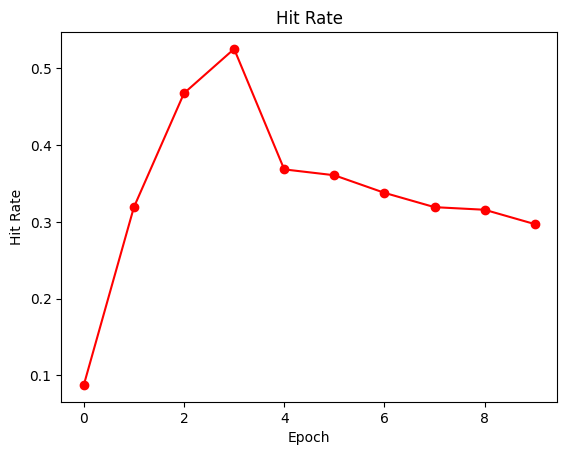

In [ ]:
from matplotlib import pyplot as plt

plt.plot(losses, marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.savefig("loss.png")

plt.clf()

plt.plot(hit_rates, marker="o", linestyle="-", color="red")
plt.xlabel("Epoch")
plt.ylabel("Hit Rate")
plt.title("Hit Rate")
plt.savefig("hit_rate.png")

